<a href="https://colab.research.google.com/github/dannynacker/strobe_depression/blob/main/WP2_strat_and_monitor_FINAL_current.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# WP2 EM-DRATS (Environment for the Monitoring of Demographics, Retention, Affect, Tolerability, and Stratification)

requires:
Drop out questions_XXX.csv
wp2_post_session_4_XXX.csv
wp2_post_sessions_1-3_XXX.csv
wp2_pre_screen_XXX.csv
wp2_pre_session_1_XXX.csv
wp2_pre_sessions_2-4_XXX.csv
wp2_sms_day1,3,5_XXX.csv
wp2_sms_post_XXX.csv

creates:
wp2_assignments.csv
stratified & blinded sequence name per new participant ID
monitoring of wellbeing & tolerability
monitoring of demographic data, exclusion & retention rate

script 1: sign-up, demographic, retention (not for researcher use -- PI use only)
- run after running script 2 as it requires wp2_assignments

script 2: main blind stratification script (for researcher use)
- requires pre-screen CSV and creates list of blinded sequence names per new successful bookings (calendly_event_booked)
- below it is a stratification balance check, though it exposes number of strata per condition, so may unblind (not for researcher use -- PI use only)
- below the stratification balance check is the fixed seed (=42) through which our 5 control and 5 intervention sequences were renamed -- no need to ever run this again

script 3: main longitudinal wellbeing monitoring per condition/measure (not for researcher use -- PI use only)
- requires all 7 wellbeing CSVs
- plots per measure per condition with "worsening" part_ids outlined in summary tables below each measure plot
- used to see when clinicians should reach out to specific participants (touch base with researcher to link part_id to email)

script 4: main tolerability monitoring per condition (for any use)
- requires all post-session CSVs to make sure that session tolerability never exceeds our specified threshold
- future updates will incorporate FIBSER ratings? unsure

# WP2 Sign-Up & Retention Data Monitoring
*   requires wp2_pre_screen_XXX.CSV
*   requires drop out questions_XXX.CSV
*   requires wp2_assignments.CSV from stratification script
*   monitors passed/excluded as well as retention rate








In [1]:
import pandas as pd
from pathlib import Path
from IPython.display import display

#####
# Setup
#####
DATA_DIR = Path('/content')

def find_csv(substring: str) -> Path:
    """Find exactly one CSV in DATA_DIR whose filename contains substring."""
    matches = list(DATA_DIR.glob(f'*{substring}*.csv'))
    if not matches:
        raise FileNotFoundError(f"No file matching '{substring}' in {DATA_DIR}")
    if len(matches) > 1:
        raise ValueError(f"Multiple files match '{substring}': {matches}")
    return matches[0]

#####
# 0) Load assignments
#####
assign = pd.read_csv(find_csv('wp2_assignments'), dtype=str)

# Pools of sequence codes for inferring arm later
INTERVENTION_SEQS = assign.loc[assign['condition']=='intervention', 'sequence_name'].unique().tolist()
CONTROL_SEQS      = assign.loc[assign['condition']=='control',      'sequence_name'].unique().tolist()

#####
# 0.1) Define participant ID categories with comments
#####
# IDs who never attended Session 1 (booked but no-shows or withdrawn before arrival):
NEVER_ATTENDED_IDS = {
    "11274", # unable to make first session; excluding preliminarily
    "11380", # successful reschedule, ignore first iteration in pre-screening file
    "11266", # cancelled without rescheduling
    "11198", # reserved for manual scheduling (no-show)
    "11382", # withdrew before Session 1, data deletion requested
    "11290", # missed Session 1 and never rescheduled
    "11302", # missed Session 1; pending reschedule
    "11357", # no-show for Session 1
    "11379", # no-show for Session 1
    "11254", # manual scheduling issue; effectively no-show
    "11298", # did not show up for Session 1
    "11187", # no-show for Session 1
    "11296",  # ineligible: not depressed
    "11316", # Session 1 no-show
    "11388", # Session 1 no-show
    "11286", # not in calendar; manual scheduling?
    "11182", # Session 1 no-show
    "11226", # not in calendar, assuming manual scheduling
    "11341", # cancelled before Session 1
    "11121", # Session 1 no-show
    "11245" # Session 1 no-show
}

# IDs who attended Session 1 but later dropped out (post-S1 drop-outs):
DROPOUT_AFTER_S1_IDS = {
    "11309", # dropout due to life events after Session 1
    "11162", # dropped out due to life events after Session 2
    "11152"  # too sick to make Session 2; will need to re-signup once feeling better
}

# IDs who dropped out after the taster session (not counted as post-S1 drop-outs):
TASTER_DROPOUT_IDS = {
    "11153"  # dropped out after taster session, exclude from S1 retention
}

# Derive true no-shows by removing any overlap
NOT_ATTENDED_IDS = NEVER_ATTENDED_IDS - DROPOUT_AFTER_S1_IDS - TASTER_DROPOUT_IDS
assert NOT_ATTENDED_IDS.isdisjoint(DROPOUT_AFTER_S1_IDS.union(TASTER_DROPOUT_IDS)), "ID sets overlap!"

# Sequence mappings for post-S1 drop-outs to infer condition
DROP_SEQ = {
    "11309": "WP2-6E363F", # intervention sequence
    "11162": "WP2-6E363F", # intervention sequence
    "11152": "WP2-3EB089"  # control sequence
}

#####
# 1) Load & summarize pre-screening
#####
df_pre = pd.read_csv(find_csv('wp2_pre_screen_'), dtype=str)
df_pre.columns = df_pre.columns.str.strip()

if 'part_id' not in df_pre.columns:
    df_pre.rename(columns={df_pre.columns[0]: 'part_id'}, inplace=True)
df_pre['part_id'] = df_pre['part_id'].fillna('').astype(str)
# Remove phantom import rows
df_pre = df_pre[~df_pre['part_id'].str.contains('ImportId', na=False)].copy()

# Keep only completed screeners or safety-outs
safety_cols = [f'safety_{i}' for i in range(1, 8)]
df_pre = df_pre[
    df_pre['incl_dem_light'].notna() |
    df_pre[safety_cols].notna().any(axis=1)
].copy()

# Exclusion summary
exc_counts = df_pre['excluded'].value_counts()
summary_excl = pd.DataFrame({
    'Category': [
        '# Passed pre-screen',
        '# Excluded for safety',
        '# Excluded for demographics',
        '# Excluded for PHQ-9'
    ],
    'Count': [
        exc_counts.get('FALSE', 0),
        exc_counts.get('safety_screening', 0),
        exc_counts.get('demographics', 0),
        exc_counts.get('phq_9', 0)
    ]
})
print("=== Pre-screen Exclusion Summary ===")
display(summary_excl)

# Demographics for passed pre-screen
passed_df = df_pre[df_pre['excluded'] == 'FALSE'].copy()
ages = pd.to_numeric(passed_df['incl_dem_age'], errors='coerce')
print(f"\n=== Passed Participants Demographics (n={len(passed_df)}) ===")
print(f"Age    Mean±SD: {ages.mean():.1f}±{ages.std():.1f}")
sex_counts = passed_df['incl_dem_sex'].fillna('Missing').str.capitalize().value_counts().rename_axis('Sex').reset_index(name='Count')
print("\nSex distribution:")
display(sex_counts)
if 'incl_dem_gender' in passed_df.columns:
    gender_counts = passed_df['incl_dem_gender'].fillna('Missing').str.capitalize().value_counts().rename_axis('Gender').reset_index(name='Count')
    print("\nGender distribution:")
    display(gender_counts)

#####
# 2) Load & clean Session 1 sign-ups
#####
df_s1 = pd.read_csv(find_csv('wp2_pre_session_1'), dtype=str, skiprows=1)
df_s1.columns = df_s1.columns.str.strip()
if 'part_id' not in df_s1.columns:
    df_s1.rename(columns={df_s1.columns[0]: 'part_id'}, inplace=True)
df_s1['part_id'] = df_s1['part_id'].fillna('').astype(str)
# Remove phantom rows
df_s1 = df_s1[~df_s1['part_id'].str.startswith('{"ImportId', na=False)].copy()

#####
# 3) Summarize Qualtrics drop-out reasons (filtered to true post-S1 drop-outs)
#####
df_drop = pd.read_csv(find_csv('Drop out questions_'), dtype=str)
df_drop.columns = df_drop.columns.str.strip()
if 'part_id' not in df_drop.columns:
    df_drop.rename(columns={df_drop.columns[0]: 'part_id'}, inplace=True)

# Merge assignment condition
df_drop = df_drop.merge(assign[['part_id','condition']], on='part_id', how='left')

# Map free-text reasons to categories
def map_reason(text):
    if pd.isna(text): return 'unknown'
    t = text.lower()
    if 'uncomfortable' in t: return 'tolerability'
    if 'too difficult' in t: return 'scheduling'
    if text.startswith('I did not enjoy'): return 'other'
    return 'unknown'

df_drop['reason_cat'] = df_drop['drop_out_why'].apply(map_reason)
# Filter to only post-S1 drop-out IDs
df_drop = df_drop[df_drop['part_id'].isin(DROPOUT_AFTER_S1_IDS)]

# Unique post-S1 dropouts
post1_drop_unique = df_drop[['part_id','condition','reason_cat']].drop_duplicates('part_id')
n_dropped_overall = len(DROPOUT_AFTER_S1_IDS)
print(f"\n=== Drop-out Reasons (Overall: {n_dropped_overall} dropped post- Session 1) ===")
display(pd.DataFrame({
    'Reason': ['Tolerability','Scheduling','Other'],
    'Count': [
        sum(post1_drop_unique['reason_cat']=='tolerability'),
        sum(post1_drop_unique['reason_cat']=='scheduling'),
        sum(post1_drop_unique['reason_cat']=='other')
    ]
}))

#####
# 4) Narrative & retention summary
#####
# 4.1) Sign-ups among passed
signed_ids = set(passed_df.loc[
    passed_df['calendly_event_booked'].fillna('').str.strip().str.lower().isin(['true','none_available']),
    'part_id'
])

# 4.2) Attended Session 1 (minus true no-shows)
attended_ids = (signed_ids & set(df_s1['part_id'])) - NOT_ATTENDED_IDS
attended_df = passed_df[passed_df['part_id'].isin(attended_ids)]
print(f"\n=== Attended Participants Demographics (n={len(attended_df)}) ===")
ages_att = pd.to_numeric(attended_df['incl_dem_age'], errors='coerce')
print(f"Age    Mean±SD: {ages_att.mean():.1f}±{ages_att.std():.1f}")
sex_att = attended_df['incl_dem_sex'].fillna('Missing').str.capitalize().value_counts().rename_axis('Sex').reset_index(name='Count')
print("\nSex distribution:")
display(sex_att)
if 'incl_dem_gender' in attended_df.columns:
    gender_att = attended_df['incl_dem_gender'].fillna('Missing').str.capitalize().value_counts().rename_axis('Gender').reset_index(name='Count')
    print("\nGender distribution:")
    display(gender_att)

# 4.3) Manual post-S1 dropouts
md_ids = DROPOUT_AFTER_S1_IDS & attended_ids
manual_drop_n = len(md_ids)

# 4.4) Retention
attended_n = len(attended_ids)
retained_n = attended_n - manual_drop_n
post_ret   = retained_n / attended_n if attended_n else 0

# 4.5) Summary
passed_n    = len(passed_df)
int_passed  = assign[(assign['condition']=='intervention') & (assign['part_id'].isin(passed_df['part_id']))]['part_id'].nunique()
ctrl_passed = assign[(assign['condition']=='control')      & (assign['part_id'].isin(passed_df['part_id']))]['part_id'].nunique()
int_signed  = sum((assign['part_id'].isin(signed_ids))   & (assign['condition']=='intervention'))
ctrl_signed = sum((assign['part_id'].isin(signed_ids))   & (assign['condition']=='control'))
int_att     = sum((assign['part_id'].isin(attended_ids)) & (assign['condition']=='intervention'))
ctrl_att    = sum((assign['part_id'].isin(attended_ids)) & (assign['condition']=='control'))

print(f"""
1) Of the {passed_n} who passed the pre-screen, {len(signed_ids)} signed up for Session 1.
2) Of those {len(signed_ids)}, {len(attended_ids)} attended Session 1.
3) Of those {len(attended_ids)}, {manual_drop_n} dropped out → retention {retained_n}/{len(attended_ids)} ({post_ret:.1%}).

Sign-ups by arm:
  • Intervention: {int_signed}/{int_passed} ({int_signed/int_passed:.1%})
  • Control:      {ctrl_signed}/{ctrl_passed} ({ctrl_signed/ctrl_passed:.1%})

Attendance by arm:
  • Intervention: {int_att}/{int_signed} ({int_att/int_signed:.1%})
  • Control:      {ctrl_att}/{ctrl_signed} ({ctrl_att/ctrl_signed:.1%})

Post-Session 1 drop-outs by arm:
  • Intervention: {sum(1 for pid in md_ids if DROP_SEQ.get(pid) in INTERVENTION_SEQS)}/{int_att} → retention {(int_att - sum(1 for pid in md_ids if DROP_SEQ.get(pid) in INTERVENTION_SEQS))/int_att:.1%}
  • Control:      {sum(1 for pid in md_ids if DROP_SEQ.get(pid) in CONTROL_SEQS)}/{ctrl_att} → retention {(ctrl_att - sum(1 for pid in md_ids if DROP_SEQ.get(pid) in CONTROL_SEQS))/ctrl_att:.1%}
"""
)

=== Pre-screen Exclusion Summary ===


Category  Count
0          # Passed pre-screen     86
1        # Excluded for safety     32
2  # Excluded for demographics     28
3         # Excluded for PHQ-9      3


=== Passed Participants Demographics (n=86) ===
Age    Mean±SD: 30.3±10.6

Sex distribution:


Sex  Count
0   Female     46
1     Male     36
2  Missing      4


Gender distribution:


Gender  Count
0   Female     42
1     Male     38
2  Missing      4
3    Other      2


=== Drop-out Reasons (Overall: 3 dropped post- Session 1) ===


Reason  Count
0  Tolerability      0
1    Scheduling      3
2         Other      0


=== Attended Participants Demographics (n=38) ===
Age    Mean±SD: 29.5±11.3

Sex distribution:


Sex  Count
0  Female     21
1    Male     17


Gender distribution:


Gender  Count
0  Female     18
1    Male     18
2   Other      2


1) Of the 86 who passed the pre-screen, 64 signed up for Session 1.
2) Of those 64, 38 attended Session 1.
3) Of those 38, 3 dropped out → retention 35/38 (92.1%).

Sign-ups by arm:
  • Intervention: 21/21 (100.0%)
  • Control:      18/18 (100.0%)

Attendance by arm:
  • Intervention: 19/21 (90.5%)
  • Control:      16/18 (88.9%)

Post-Session 1 drop-outs by arm:
  • Intervention: 1/19 → retention 94.7%
  • Control:      2/16 → retention 87.5%



# Participant Stratification

block size = 4 & strata = 4 (low/high PHQ-9 * yes/no pharmacological intervention)


*   requires wp2_pre_screen_XXX.CSV
*   requires wp2_assignments.CSV once script has been ran more than once to ensure participants are equally allocated and informed by previous randomizations -- MAKE SURE TO SAVE AND DATE THE LAST ITERATION!!! (then, when reuploading, remove data marker [just "wp2_assignments"])




In [2]:
import pandas as pd
import random
import hashlib
from pathlib import Path

#####
# Parameters
#####
DATA_DIR   = Path('/content')
OUTPUT_CSV = Path('wp2_assignments.csv')
BLOCK_SIZE = 4
SEED       = 42  # None for non-reproducible

#####
# 0) Define participant categories
#####
# IDs who never attended Session 1 (booked but no-shows or withdrew before arrival):
NEVER_ATTENDED_IDS = {
    "11274", # unable to make first session; excluding preliminarily
    "11380", # successful reschedule, ignore first iteration
    "11266", # cancelled without rescheduling
    "11198", # reserved for manual scheduling (no-show)
    "11382", # withdrew before S1, data deletion requested
    "11290", # missed S1 and never rescheduled
    "11302", # missed S1; pending reschedule
    "11357", # no-show S1
    "11379", # no-show S1
    "11393", # missed S1 after second reschedule
    "11316", # missed S1 and never rescheduled
    "11254", # manual scheduling issue; effectively no-show
    "11298", # did not show up for S1
    "11187", # no-show for S1
    "11296",  # ineligible: not depressed
    "11388", # no-show for Session 1
    "11286", # not in calendar; manual scheduling?
    "11182", # Session 1 no-show
    "11226", # not in calendar, assuming manual scheduling
    "11341", # cancelled before Session 1
    "11121", # Session 1 no-show
    "11245" # Session 1 no-show
}

# IDs who dropped out after the taster session
TASTER_DROPOUT_IDS = {"11153"}
# IDs who attended S1 but later dropped out (true post-S1 drop-outs)
DROPOUT_AFTER_S1_IDS = {"11309","11162","11152"}

# Combine all exclusions before randomization
EXCLUDE_IDS = NEVER_ATTENDED_IDS.union(TASTER_DROPOUT_IDS).union(DROPOUT_AFTER_S1_IDS)

#####
# 1) Utility to find exactly one CSV
#####
def find_csv(sub: str) -> Path:
    matches = list(DATA_DIR.glob(f"*{sub}*.csv"))
    if not matches:
        raise FileNotFoundError(f"No file matching '{sub}' in {DATA_DIR}")
    if len(matches) > 1:
        raise ValueError(f"Multiple files match '{sub}': {matches}")
    return matches[0]

#####
# 2) Generate blinded sequence pools
#####
def gen_sequences(condition: str, count: int = 5) -> list[str]:
    return [
        f"WP2-{hashlib.sha256(f'{SEED}-{condition}-{i}'.encode()).hexdigest().upper()[:6]}"
        for i in range(count)
    ]
INTERVENTION_SEQS = gen_sequences('intervention')
CONTROL_SEQS      = gen_sequences('control')

#####
# 3) Load & filter pre-screen
#####
df = pd.read_csv(find_csv('wp2_pre_screen_'), dtype=str)
df.columns    = df.columns.str.strip()
df['part_id'] = df['part_id'].str.strip()

# (a) only those who passed pre-screen
df = df[df['excluded'].str.strip().str.lower() == 'false'].copy()
# (b) only those who booked or none_available
df['cal_book'] = df['calendly_event_booked'].fillna('').str.strip().str.lower()
df = df[df['cal_book'].isin(['true','none_available'])].copy()
df.drop(columns=['cal_book'], inplace=True)
# (c) remove all exclusion categories before randomization
df = df[~df['part_id'].isin(EXCLUDE_IDS)].copy()

# define strata
df['phq9_sum'] = pd.to_numeric(df['phq9_sum'], errors='coerce')
def phq9_bin(x):
    if 5 <= x <= 16: return 'low'
    if 17 <= x <= 27: return 'high'
    return None
df['stratum'] = df['phq9_sum'].apply(phq9_bin).fillna('') + '_' + df['incl_dem_med'].astype(str).str.strip().str.lower()
df = df[df['stratum'].str.contains('_')].copy()
# preserve arrival order
df['_order'] = range(len(df))

#####
# 4) Load existing assignments & free slots
#####
if OUTPUT_CSV.exists():
    existing = pd.read_csv(OUTPUT_CSV, dtype=str)
    existing.columns    = existing.columns.str.strip()
    existing['part_id'] = existing['part_id'].str.strip()
    # free up slots for excluded IDs
    existing = existing[~existing['part_id'].isin(EXCLUDE_IDS)]
else:
    existing = pd.DataFrame(columns=['part_id','stratum','condition','sequence_name'])
assigned = existing[['part_id','stratum','condition']].copy()

#####
# 5) Merge to find new participants
#####
merged = df[['part_id','stratum','_order']].merge(assigned, on=['part_id','stratum'], how='left').reset_index(drop=True)
merged['is_new'] = merged['condition'].isna()

#####
# 6) Block randomization per stratum
#####
existing_counts = assigned.groupby('stratum').size()
mask_new         = merged['is_new']
start_counts     = merged['stratum'].map(existing_counts).fillna(0).astype(int)
new_cumcnt       = merged[mask_new].groupby('stratum').cumcount()
merged.loc[mask_new, 'stratum_idx'] = start_counts[mask_new] + new_cumcnt
merged['stratum_idx'] = merged['stratum_idx'].fillna(0).astype(int)

def assign_block_stratum(stratum: str, idx: int) -> str:
    block_num = idx // BLOCK_SIZE
    seed_int  = None if SEED is None else int(hashlib.sha256(f"{SEED}-{stratum}-{block_num}".encode()).hexdigest(), 16)
    rng = random.Random(seed_int)
    block = ['intervention']*(BLOCK_SIZE//2) + ['control']*(BLOCK_SIZE//2)
    rng.shuffle(block)
    return block[idx % BLOCK_SIZE]
merged['condition'] = merged.apply(lambda r: r['condition'] if pd.notna(r['condition']) else assign_block_stratum(r['stratum'], r['stratum_idx']), axis=1)

#####
# 7) Assign sequence codes
#####
merged = merged.sort_values('_order').reset_index(drop=True)
merged['seq_idx'] = merged.groupby('condition').cumcount()
merged['sequence_name'] = merged.apply(lambda r: (INTERVENTION_SEQS[r.seq_idx % len(INTERVENTION_SEQS)] if r.condition=='intervention' else CONTROL_SEQS[r.seq_idx % len(CONTROL_SEQS)]), axis=1)

#####
# 8) Save & report
#####
full = merged[['part_id','stratum','condition','sequence_name']]
full.to_csv(OUTPUT_CSV, index=False)
print("Newly assigned participants:")
print(merged.loc[merged['is_new'], ['part_id','sequence_name']])

Newly assigned participants:
   part_id sequence_name
39   11213    WP2-7F6D87
40   11191    WP2-0BDE7F


Assess Stratification Balance
*   run the previous stratification script so that the df "full" exists in this environment
*   ONLY run every 4+ participants -- otherwise, you run the risk of unblinding

In [ ]:
#####
# 9) Blind stratification check
#####
# 'merged' is the DataFrame you built in Script B, with columns
# ['part_id','stratum','condition','sequence_name','is_new',…]
new_out   = merged[merged['is_new']]
new_count = len(new_out)

if new_count >= BLOCK_SIZE:
    if new_count == BLOCK_SIZE:
        prompt = "At least one full new block has been added. Proceed with stratification check? [y/n] "
    else:
        prompt = (
            "WARNING: A block is still in progress. "
            "Checking stratification now may unblind. "
            "Continue anyway? [y/n] "
        )
    ans = input(prompt)
    if ans.strip().lower() in ('y','yes'):
        summary = (
            new_out
            .groupby(['stratum','condition'])
            .size()
            .unstack(fill_value=0)
            .rename_axis(index='Stratum', columns='Condition')
        )
        print("Blind Stratification Check (new block):")
        print(summary)
        print("Assignment counts by arm:")
        print(full['condition'].value_counts(), "\n")
    else:
        print("Stratification check aborted by user.")
else:
    print(f"Only {new_count} new participants added (< {BLOCK_SIZE}); skipping stratification check.")

Only 1 new participants added (< 4); skipping stratification check.


Total Stratification Checker -- Condition & Strata

In [3]:
import pandas as pd
from pathlib import Path

#####
# Helper to find CSVs
#####
DATA_DIR = Path('/content')
def find_csv(substring: str) -> Path:
    matches = list(DATA_DIR.glob(f'*{substring}*.csv'))
    if not matches:
        raise FileNotFoundError(f"No file matching '{substring}' in {DATA_DIR}")
    if len(matches) > 1:
        raise ValueError(f"Multiple files match '{substring}': {matches}")
    return matches[0]

#####
# 0) Load "live" assignments (drop-outs removed)
#####
wp2_assignments = pd.read_csv(find_csv('wp2_assignments'), dtype=str)

#####
# 0.1) Define exclusion & dropout categories
#####
# Participants who never attended Session 1 (no-shows)
NEVER_ATTENDED_IDS = {
    '11274','11380','11266','11198','11382','11290','11302',
    '11357','11379','11393','11316','11254','11298','11187','11296',
    '11388', '11182', '11226', '11341', '11121', '11245'
}
# Participants who dropped out after the taster session (exclude)
TASTER_DROPOUT_IDS = {
    '11153'
}
# Participants who attended S1 but later dropped out (include in augment)
POST_S1_DROPOUT_IDS = {
    '11309','11162','11152'
}

#####
# 0.2) Sequence pools and mapping
#####
# Live assignment pools:
INTERVENTION_SEQS = wp2_assignments.loc[
    wp2_assignments['condition']=='intervention','sequence_name'
].unique().tolist()
CONTROL_SEQS = wp2_assignments.loc[
    wp2_assignments['condition']=='control','sequence_name'
].unique().tolist()
# Manual mapping for post-S1 dropouts:
MANUAL_DROPOUT_SEQ = {
    '11309':'WP2-6E363F',
    '11162':'WP2-6E363F',
    '11152':'WP2-3EB089'
}

#####
# 1) Recompute strata for post-S1 dropouts
#####
df_pre = pd.read_csv(find_csv('wp2_pre_screen_'), dtype=str)
df_pre.columns = df_pre.columns.str.strip()
df_pre['part_id'] = df_pre['part_id'].str.strip()
# Numeric PHQ-9
df_pre['phq9_sum'] = pd.to_numeric(df_pre['phq9_sum'],errors='coerce')
# Medication indicator
df_pre['incl_dem_med'] = df_pre['incl_dem_med'].fillna('').str.strip().str.lower()

def phq9_bin(x):
    if 5 <= x <= 16: return 'low'
    if 17 <= x <= 27: return 'high'
    return None

df_pre['stratum'] = df_pre['phq9_sum'].apply(phq9_bin) + '_' + df_pre['incl_dem_med']
# extract strata for post-S1 dropouts
strata_md = df_pre[df_pre['part_id'].isin(POST_S1_DROPOUT_IDS)][['part_id','stratum']].drop_duplicates()

#####
# 2) Build DataFrame for post-S1 dropouts
#####
df_md = pd.DataFrame({'part_id':list(POST_S1_DROPOUT_IDS)})
df_md['sequence_name'] = df_md['part_id'].map(MANUAL_DROPOUT_SEQ)
df_md['condition'] = df_md['sequence_name'].apply(
    lambda seq: 'intervention' if seq in INTERVENTION_SEQS else 'control'
)
df_md = df_md.merge(strata_md, on='part_id', how='left')

#####
# 3) Augment live assignments (exclude no-shows & taster dropouts)
#####
aug = pd.concat([
    wp2_assignments[['part_id','stratum','condition']],
    df_md[['part_id','stratum','condition']]
],ignore_index=True)
# exclude participants who never attended or dropped at taster
exclude_ids = NEVER_ATTENDED_IDS.union(TASTER_DROPOUT_IDS)
aug = aug[~aug['part_id'].isin(exclude_ids)]

#####
# 4) Balance checks
#####
print("Assignment counts by condition (excluding no-shows & taster dropouts):")
print(aug['condition'].value_counts().sort_index(),"\n")
print("Assignment counts by stratum (excluding no-shows & taster dropouts):")
print(aug['stratum'].value_counts().sort_index())

Assignment counts by condition (excluding no-shows & taster dropouts):
condition
control         21
intervention    23
Name: count, dtype: int64 

Assignment counts by stratum (excluding no-shows & taster dropouts):
stratum
high_no      6
high_yes     4
low_no      19
low_yes     15
Name: count, dtype: int64


Blinded Sequence Name Generator, 5/5 Intervention/Control with a Fixed Seed
*   the same seed is used for the stratification cells above for researchers to remain blinded

In [ ]:
#####
# 7) Duplicate template files for each sequence
#####
import shutil
# Define your template text files (adjust paths if needed)
CONTROL_TEMPLATE       = DATA_DIR / 'z_control_adj2.txt'
INTERVENTION_TEMPLATE = DATA_DIR / 'z_intervention_adj2.txt'

# Ensure templates exist
if not CONTROL_TEMPLATE.exists():
    raise FileNotFoundError(f"Control template not found at {CONTROL_TEMPLATE}")
if not INTERVENTION_TEMPLATE.exists():
    raise FileNotFoundError(f"Intervention template not found at {INTERVENTION_TEMPLATE}")

# Create copies named by sequence codes
for seq in CONTROL_SEQS:
    dest = DATA_DIR / f"{seq}.txt"
    shutil.copy(CONTROL_TEMPLATE, dest)

for seq in INTERVENTION_SEQS:
    dest = DATA_DIR / f"{seq}.txt"
    shutil.copy(INTERVENTION_TEMPLATE, dest)

print(f"Created {len(CONTROL_SEQS)} control and {len(INTERVENTION_SEQS)} intervention files.")

In [ ]:
from datetime import datetime

def generate_debrief(part_id: str, assignments_df: pd.DataFrame) -> str:
    """
    Given a part_id and the augmented assignments DataFrame,
    return your personalized debrief paragraph.
    """
    # look up the row
    row = assignments_df.loc[assignments_df['part_id'] == part_id]
    if row.empty:
        raise ValueError(f"No assignment found for part_id {part_id!r}")

    # pull & format condition and day
    condition = row['condition'].iloc[0].capitalize()
    day_of_week = datetime.now().strftime('%A')

    # fill the template
    return f"""Hello again and Happy {day_of_week}!

    Thank you for participating in our investigation into strobe light therapy as a treatment of depression.

    We wanted to let you know that you were in the {condition} condition.

    Attached (and printed below) is your debrief information. If you have any questions, please don't hesitate to get in touch.

    Depressive disorders are a leading contributor to the global health-related burden. There is
    great need for the development of cost-effective and sustainable therapeutic treatments
    that can complement existing treatment approaches for depression.

    One existing treatment, bright light therapy, has been shown to reduce symptoms of
    seasonal affective disorder (SAD) and non-seasonal depression. Stroboscopic light has
    been suggested to have enhanced therapeutic effects over bright light therapy. In a mouse
    model of depression, relatively short exposure to stroboscopic light stimulation was shown
    to reduce depression-like behaviours significantly better than the commonly used anti-depressant fluoxetine (Kim et al, 2016).
    In humans, stroboscopic light on closed eyes, at certain frequencies, typically gives rise to
    vivid visual experiences (e.g., colours, geometric patterns, movement, complex scenes), as
    well as, for some people, powerful emotional responses. Recently, we completed a large-scale public art-science experience, the Dreamachine, which enabled more than 40,000
    people to safely experience visual hallucinations induced by strobe light. Everyone
    participating in this event had a unique experience, despite being exposed to the same
    flickering white light. Almost all participants reported a new appreciation of the power of
    their own minds and brains to create their perceptual experiences. The vast majority also
    reported positive emotions, including many spontaneous reports of positive benefits for
    depression, anxiety, and related mental states.

    The goal of this study is to assess the feasibility and tolerability of a stroboscopic
    intervention for depressive symptoms, while controlling for the influence of expectation on
    the potential efficacy of the strobe sessions. To control for placebo effects - where people
    may report improvements simply because they believe they are receiving an effective
    treatment - this study included both an experimental and a control condition. Researchers
    were blinded to which condition participants were randomly assigned to. Participants in
    both groups completed the same questionnaires and four strobe light sessions. However,
    the control condition's strobe sessions were slightly altered so that they would cause
    minimal stroboscopic experiences.

    It is our hope that this study will deliver the critical data needed to enable further testing of
    stroboscopic light therapy for depression.

    Again, we stress that this study is not a clinical trial and is intended as an initial step in
    assessing the potential of stroboscopic therapy to reduce depressive symptoms.

    If you are concerned about your own emotional wellbeing or mental health, then here
    are some sources of support to consider:

    https://www.https://www.mind.org.uk/information-support/types-of-mental-health-problems/seasonal-affectivedisorder-sad/about-sad/

    If you are a student at the University of Sussex:

    Student Life Centre (University of Sussex)
    Website: https://www.sussex.ac.uk/studentlifecentre/
    Phone: 01273 876767 Email: studentlifecentre@sussex.ac.uk

    If you have any questions or concerns about this study, please get in touch with the lead
    researcher Dr. David Schwartzman (d.schwartzman@sussex.ac.uk).

    Thank you for your participation in this study.

    Dr. David Schwartzman - Postdoctoral Research Fellow
    The Sussex Centre for Consciousness Science
"""

# Enter part_id below to generate your email to copy and paste:
print(generate_debrief("11335", aug))

Hello again and Happy Friday!

    Thank you for participating in our investigation into strobe light therapy as a treatment of depression.

    We wanted to let you know that you were in the Control condition.

    Attached (and printed below) is your debrief information. If you have any questions, please don't hesitate to get in touch.

    Depressive disorders are a leading contributor to the global health-related burden. There is
    great need for the development of cost-effective and sustainable therapeutic treatments
    that can complement existing treatment approaches for depression.

    One existing treatment, bright light therapy, has been shown to reduce symptoms of
    seasonal affective disorder (SAD) and non-seasonal depression. Stroboscopic light has
    been suggested to have enhanced therapeutic effects over bright light therapy. In a mouse
    model of depression, relatively short exposure to stroboscopic light stimulation was shown
    to reduce depression-like beh

# Participant Wellbeing Live Monitoring

requires:
*   wp2_pre_session_1_XXX.CSV
*   wp2_sms_day1,3,5_XXX.CSV
*   wp2_pre_sessions_2-4_XXX.CSV
*   wp2_post_sessions_1-3_XXX.CSV
*   wp2_post_session_4_XXX.CSV
*   wp2_sms_post_XXX.CSV
*   wp2_assignments.CSV from the stratification script

This monitor will unblind researchers to part_id:condition allocation; please run the one below for a condition-blind part_id monitoring of wellbeing.






In [4]:
import re
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

#####
# 0) SETTINGS
#####
DATA_DIR = Path('/content')

#####
# 1) UTILITY TO FIND EXACTLY ONE CSV
#####
def find_csv(substring: str) -> Path:
    matches = list(DATA_DIR.glob(f'*{substring}*.csv'))
    if not matches:
        raise FileNotFoundError(f"No file matching '{substring}' in {DATA_DIR}")
    if len(matches) > 1:
        raise ValueError(f"Multiple files match '{substring}': {matches}")
    return matches[0]

#####
# 1b) TRY TO LOAD A CSV, BUT SKIP IF MISSING OR AMBIGUOUS
#####
def try_load(substring: str) -> pd.DataFrame | None:
    try:
        path = find_csv(substring)
    except (FileNotFoundError, ValueError) as e:
        print(f"Skipping '{substring}': {e}")
        return None
    print(f"Loaded '{substring}' from {path.name}")
    return pd.read_csv(path, dtype=str)

#####
# 2) LOAD ALL WELLBEING CSVS (skipping any that aren’t there yet)
#####
df_s1_pre     = try_load('pre_session_1')
df_s2to4_pre  = try_load('pre_sessions_2-4')
df_s2to4_post = try_load('post_sessions_1-3')
df_s4_post    = try_load('post_session_4')
df_sms        = try_load('sms_day1,3,5')

#  — new step: trim SMS part_ids —
if df_sms is not None:
    df_sms['part_id'] = (
        df_sms['part_id']
              .astype(str)
              .str.strip()
              .str[:5]
    )
    print("Trimmed df_sms.part_id to first 5 characters")

df_final      = try_load('sms_post')

# Collect only the ones that actually loaded
all_dfs = [df for df in (
    df_s1_pre,
    df_s2to4_pre,
    df_s2to4_post,
    df_s4_post,
    df_sms,
    df_final
) if df is not None]

if not all_dfs:
    raise RuntimeError("No data files found to process!")

#####
# 3) CLEAN BDI ITEMS (extract leading number)
#####
for df in all_dfs:
    bdi_raw = [c for c in df.columns if re.fullmatch(r"bdi_\d+(?:_1)?", c)]
    for col in bdi_raw:
        df[col] = (
            df[col].astype(str)
                  .str.extract(r'^(\d+)')[0]
                  .astype(float)
        )

#####
# 4) SUM SCALES
#####
def sum_scale(df, cols, new_col):
    df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')
    df[new_col] = df[cols].sum(axis=1)

def get_scale_cols(df, prefix, count, allow_suffix=False):
    cols = []
    for i in range(1, count+1):
        main = f"{prefix}_{i}"
        alt  = f"{prefix}_{i}_1"
        if main in df.columns:
            cols.append(main)
        elif allow_suffix and alt in df.columns:
            cols.append(alt)
    return cols

for df in all_dfs:
    # BAI
    bai_cols = get_scale_cols(df, 'bai', 21)
    if bai_cols:
        sum_scale(df, bai_cols, 'bai_sum')
    # BDI
    bdi_cols = get_scale_cols(df, 'bdi', 21)
    if bdi_cols:
        sum_scale(df, bdi_cols, 'bdi_sum')
    # MADRS
    madrs_cols = get_scale_cols(df, 'madrs', 9, allow_suffix=True)
    if madrs_cols:
        sum_scale(df, madrs_cols, 'MADRS_S_sum')

#####
# 5) STANDARDIZE M3VAS
#####
def standardize_m3vas(df):
    for var in ('mood','pleasure','suicidal'):
        ch_cols  = [c for c in df.columns if re.fullmatch(f"m3vas_ch_{var}(?:_1)?", c)]
        raw_cols = [c for c in df.columns if re.fullmatch(f"m3vas_{var}(?:_1)?",    c)]
        if ch_cols:
            df[f"m3vas_{var}"] = pd.to_numeric(df[ch_cols[0]], errors='coerce') + 50
        elif raw_cols:
            df[f"m3vas_{var}"] = pd.to_numeric(df[raw_cols[0]], errors='coerce')
    # invert pleasure
    if 'm3vas_pleasure' in df.columns:
        df['m3vas_pleasure'] = 100 - df['m3vas_pleasure']
    # drop raw/input cols
    drop_pattern = re.compile(
        r"^(?:m3vas_ch_(?:mood|pleasure|suicidal)(?:_1)?|m3vas_(?:mood|pleasure|suicidal)_1)$"
    )
    to_drop = [c for c in df.columns if drop_pattern.match(c)]
    if to_drop:
        df.drop(columns=to_drop, inplace=True)

for df in all_dfs:
    standardize_m3vas(df)

#####
# 6) CLEAN FISBER
#####
for df in all_dfs:
    for col in ('fisber_1','fisber_2','fisber_3'):
        if col in df.columns:
            df[col] = (
                df[col].astype(str)
                       .str.extract(r'(\d+)$')[0]
                       .astype(float)
            )

#####
# 7) COERCE TYPES
#####
# session_n for sessions
for df in (df_s1_pre, df_s2to4_pre, df_s2to4_post, df_s4_post):
    if df is not None and 'session_n' in df.columns:
        df['session_n'] = pd.to_numeric(df['session_n'], errors='coerce').astype('Int64')

# session_n & sms_n for SMS
if df_sms is not None:
    for col in ('session_n','sms_n'):
        if col in df_sms.columns:
            df_sms[col] = pd.to_numeric(df_sms[col], errors='coerce').astype('Int64')

# numeric scales
numeric_cols = [
    'phq9_sum','spane_p','spane_n',
    'm3vas_mood','m3vas_pleasure','m3vas_suicidal',
    'fisber_1','fisber_2','fisber_3',
    'bai_sum','bdi_sum','MADRS_S_sum'
]
for df in all_dfs:
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

#####
# 8) ENSURE EVERY DF HAS part_id
#####
for df in all_dfs:
    if 'part_id' not in df.columns:
        if 'ProlificID' in df.columns:
            df.rename(columns={'ProlificID':'part_id'}, inplace=True)
        else:
            df['part_id'] = df.index.astype(str)
    df['part_id'] = df['part_id'].astype(str).str.strip()

#####
# 9) TAG TIMEPOINTS
#####
if df_s1_pre    is not None: df_s1_pre    ['timepoint'] = 'session1_pre'
if df_s2to4_pre is not None: df_s2to4_pre ['timepoint'] = df_s2to4_pre.apply(lambda r: f"session{r.session_n}_pre",  axis=1)
if df_s2to4_post is not None: df_s2to4_post['timepoint'] = df_s2to4_post.apply(lambda r: f"session{r.session_n}_post", axis=1)
if df_s4_post   is not None: df_s4_post   ['timepoint'] = 'session4_post'
if df_sms       is not None: df_sms       ['timepoint'] = df_sms.apply(lambda r: f"SMS_{r.session_n}_{r.sms_n}", axis=1)
if df_final     is not None: df_final     ['timepoint'] = 'final_post'

#####
# 10) CONCATENATE
#####
df_long = pd.concat(all_dfs, ignore_index=True)

#####
# 11) DROP NON-NUMERIC part_id
#####
df_long = df_long[df_long['part_id'].str.match(r'^\d+$', na=False)]

#####
# 12) MERGE IN CONDITION (if assignments file was found)
#####
df_assign = try_load('wp2_assignments')
if df_assign is not None:
    df_long = df_long.merge(
        df_assign[['part_id','condition']],
        on='part_id',
        how='inner'
    )
else:
    print("No assignments file: skipping merge with 'condition' column")

#####
# 13) DEFINE & APPLY ORDERED CATEGORICAL FOR timepoint
#####
ordered_timepoints = [
    'session1_pre','session1_post',
    'SMS_1_1','SMS_1_2','SMS_1_3',
    'session2_pre','session2_post',
    'SMS_2_1','SMS_2_2','SMS_2_3',
    'session3_pre','session3_post',
    'SMS_3_1','SMS_3_2','SMS_3_3',
    'session4_pre','session4_post',
    'final_post'
]
df_long['timepoint'] = pd.Categorical(
    df_long['timepoint'],
    categories=ordered_timepoints,
    ordered=True
)

#####
# 14) PLOTTING + FLAGGING BY CONDITION
#####
bad_if_higher = {
    'phq9_sum',
    'spane_n',
    'fisber_1','fisber_2','fisber_3',
    'bai_sum','bdi_sum','MADRS_S_sum',
    'm3vas_suicidal'   # higher = more suicidal = worse
}

bad_if_lower = {
    'spane_p',
    'm3vas_mood',      # higher = better mood, so a drop is worsening
    'm3vas_pleasure'   # higher = better pleasure, so a drop is worsening
}

mcid_thresholds = {
    'phq9_sum': 5,
    'spane_p': 2,
    'spane_n': 2,
    'm3vas_mood': 12,
    'm3vas_pleasure': 12,
    'm3vas_suicidal': 12
}

#####
# ADJUST M3VAS SO 50 → 0 (“no change”), 0 → –50 (worse), 100 → +50 (better)
#####
def standardize_m3vas(df):
    to_drop = []
    for var in ('suicidal','mood','pleasure'):
        # find change‐score first, then raw‐score
        ch_col  = next((c for c in df.columns
                        if re.fullmatch(rf"m3vas_ch_{var}(?:_1)?", c)), None)
        raw_col = next((c for c in df.columns
                        if re.fullmatch(rf"m3vas_{var}(?:_1)?",    c)), None)

        if ch_col:
            vals = pd.to_numeric(df[ch_col], errors='coerce') - 50
            to_drop.append(ch_col)
        elif raw_col:
            vals = pd.to_numeric(df[raw_col], errors='coerce') - 50
            to_drop.append(raw_col)
        else:
            continue

        if var == 'suicidal':
            # leave as-is: + means more suicidal (worse), so improvement → down
            df[f"m3vas_{var}"] = vals
        else:
            # mood & pleasure: + means improvement, so flip sign
            df[f"m3vas_{var}"] = -vals

    # drop only the original raw/change columns
    df.drop(columns=to_drop, inplace=True, errors='ignore')

# apply to each dataframe
for df in all_dfs:
    standardize_m3vas(df)

def plot_and_flag_by_condition(measure):
    if measure not in df_long.columns:
        print(f"→ skipping '{measure}': not in df_long")
        return

    # For these measures, remove any session*_post timepoints
    df_plot = df_long.copy()
    if measure in ('phq9_sum','spane_p','spane_n'):
        df_plot = df_plot[~df_plot['timepoint'].str.match(r'^session\d+_post$')]

    for cond, dfc in df_plot.groupby('condition', dropna=False):
        print(f"\n── {measure}  |  Condition: {cond} ──")
        fig, ax = plt.subplots(figsize=(12,6))
        x_final = len(ordered_timepoints) - 1

        # Plot trajectories
        for pid, grp in dfc.groupby('part_id'):
            s = grp.dropna(subset=['timepoint', measure]).sort_values('timepoint')
            if s.empty:
                continue
            x = s['timepoint'].cat.codes
            y = s[measure].astype(float)
            ax.plot(x, y, linewidth=1, alpha=0.6)
            ax.text(x_final+0.2, y.iloc[-1], pid, fontsize=6, va='center')

        ax.set_xlim(-0.5, x_final+1.5)
        ax.set_xticks(range(len(ordered_timepoints)))
        ax.set_xticklabels(ordered_timepoints, rotation=45, ha='right')
        ax.set_ylabel(measure)
        ax.set_title(f"{measure} — {cond}")
        plt.tight_layout(); plt.show()

        # Flag first MCID‐level worsening events
        if measure in mcid_thresholds:
            th = mcid_thresholds[measure]
            breach_events = []
            for pid, grp_pid in dfc.groupby('part_id'):
                seq = (
                    grp_pid
                    .dropna(subset=['timepoint', measure])
                    .sort_values('timepoint')
                    .loc[:, ['part_id','timepoint', measure]]
                    .assign(change=lambda d: d[measure] - d[measure].iloc[0])
                )
                mask = seq['change'] >= th if measure in bad_if_higher else seq['change'] <= -th
                if mask.any():
                    breach_events.append(seq[mask].iloc[0])
            if breach_events:
                print(f"First MCID‐level worsening events (threshold ≥ {th}):")
                display(pd.DataFrame(breach_events))
            else:
                print(f"No participants worsened by at least the MCID of {th} for {measure}.")
        else:
            # fallback: ever‐worsened
            worsened = []
            for pid, grp_pid in dfc.groupby('part_id'):
                seq = grp_pid.dropna(subset=['timepoint', measure])\
                            .sort_values('timepoint')[measure].astype(float)
                if len(seq)<2: continue
                if ((measure in bad_if_higher and seq.iloc[-1]>seq.iloc[0]) or
                    (measure in bad_if_lower  and seq.iloc[-1]<seq.iloc[0])):
                    worsened.append(pid)
            if worsened:
                print("Worsened trajectories:")
                display(
                    dfc[dfc['part_id'].isin(worsened)]
                       [['part_id','timepoint',measure]]
                       .dropna(subset=[measure])
                       .sort_values(['part_id','timepoint'])
                       .reset_index(drop=True)
                )
            else:
                print("No worsening in this condition.")

# RUN PLOTS FOR ALL MEASURES
measures = [
    'phq9_sum','spane_p','spane_n',
    'm3vas_mood','m3vas_pleasure','m3vas_suicidal',
    'fisber_1','fisber_2','fisber_3',
    'bai_sum','bdi_sum','MADRS_S_sum'
]
#for m in measures:
#    plot_and_flag_by_condition(m)

Loaded 'pre_session_1' from wp2_pre_session_1_July 29, 2025_08.55.csv
Loaded 'pre_sessions_2-4' from wp2_pre_sessions_2-4_July 29, 2025_08.55.csv
Loaded 'post_sessions_1-3' from wp2_post_sessions_1-3_July 29, 2025_08.55.csv
Loaded 'post_session_4' from wp2_post_session_4_July 29, 2025_08.56.csv
Loaded 'sms_day1,3,5' from wp2_sms_day1,3,5_July 29, 2025_08.55.csv
Trimmed df_sms.part_id to first 5 characters
Loaded 'sms_post' from wp2_sms_post_July 29, 2025_08.54.csv
Loaded 'wp2_assignments' from wp2_assignments.csv


CONDITION-BLIND WELLBEING MONITORING

Loaded 'pre_session_1' from wp2_pre_session_1_July 29, 2025_08.55.csv
Loaded 'pre_sessions_2-4' from wp2_pre_sessions_2-4_July 29, 2025_08.55.csv
Loaded 'post_sessions_1-3' from wp2_post_sessions_1-3_July 29, 2025_08.55.csv
Loaded 'post_session_4' from wp2_post_session_4_July 29, 2025_08.56.csv
Loaded 'sms_day1,3,5' from wp2_sms_day1,3,5_July 29, 2025_08.55.csv
Trimmed df_sms.part_id to first 5 characters
Loaded 'sms_post' from wp2_sms_post_July 29, 2025_08.54.csv
Loaded 'wp2_assignments' from wp2_assignments.csv


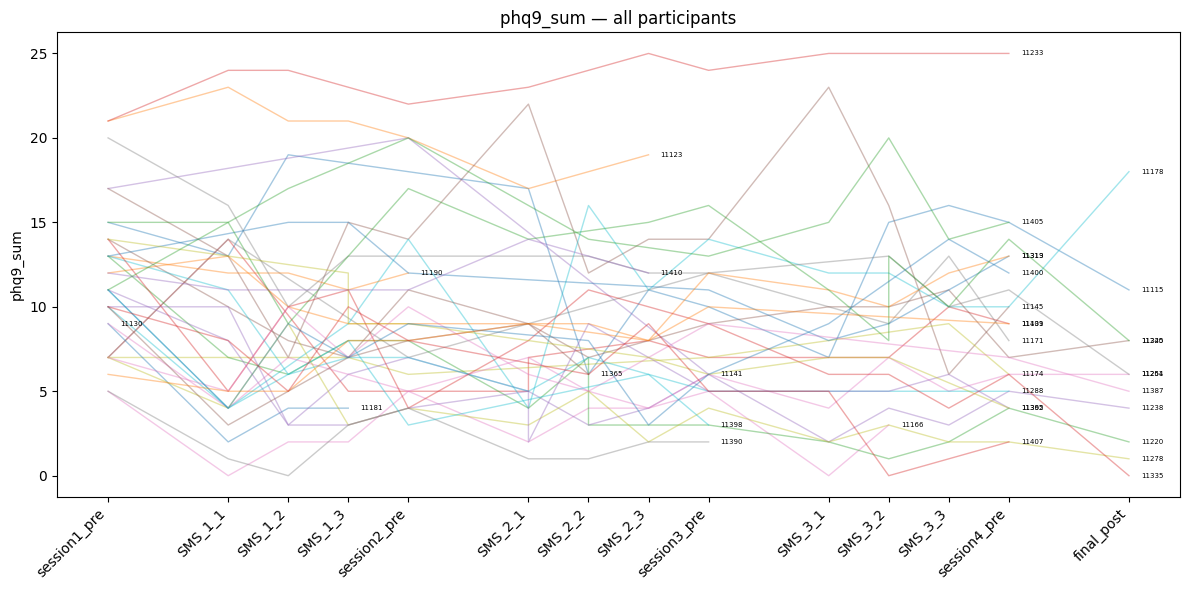

First MCID‐level worsening events (threshold ≥ 5):


part_id timepoint  phq9_sum  change
330   11139   SMS_1_1      14.0     7.0
389   11145   SMS_2_1      22.0     5.0
267   11171   SMS_1_1      14.0     7.0
367   11178   SMS_2_2      16.0     6.0
253   11405   SMS_1_2      17.0     6.0

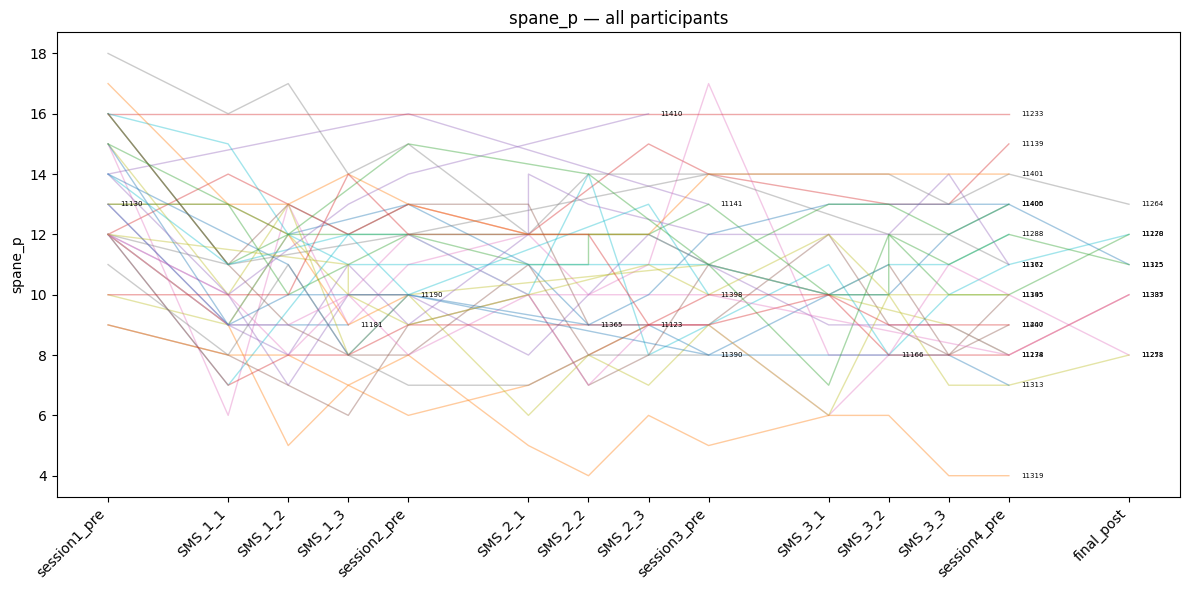

First MCID‐level worsening events (threshold ≥ 2):


part_id     timepoint  spane_p  change
249   11115       SMS_1_1      9.0    -3.0
415   11123       SMS_1_1      9.0    -3.0
336   11145       SMS_1_1     11.0    -5.0
395   11166       SMS_1_1      6.0    -9.0
77    11174  session4_pre      8.0    -2.0
295   11178       SMS_1_1      7.0    -5.0
451   11181       SMS_1_1      9.0    -4.0
459   11190       SMS_1_3      9.0    -4.0
284   11220       SMS_1_1     11.0    -5.0
274   11238       SMS_1_1     10.0    -2.0
269   11240       SMS_1_2      7.0    -2.0
245   11251       SMS_1_1     10.0    -2.0
300   11264       SMS_1_1     16.0    -2.0
246   11278       SMS_1_1     10.0    -5.0
357   11288       SMS_1_2     12.0    -4.0
287   11313       SMS_1_2     11.0    -3.0
314   11319       SMS_1_3      7.0    -2.0
266   11325       SMS_1_2     10.0    -3.0
256   11335       SMS_1_1      7.0    -5.0
250   11362       SMS_1_1      9.0    -4.0
436   11365       SMS_1_1     11.0    -5.0
268   11387       SMS_1_1      9.0    -3.0
409   11390       SMS_1_1      8.0    -3.0
334   11395       SMS_1_3     10.0    -2.0
412   11398       SMS_1_1     11.0    -3.0
374   11400       SMS_1_1      9.0    -6.0
255   11401       SMS_1_1     13.0    -4.0
253   11405       SMS_1_2     12.0    -3.0
418   11410       SMS_1_1     10.0    -4.0

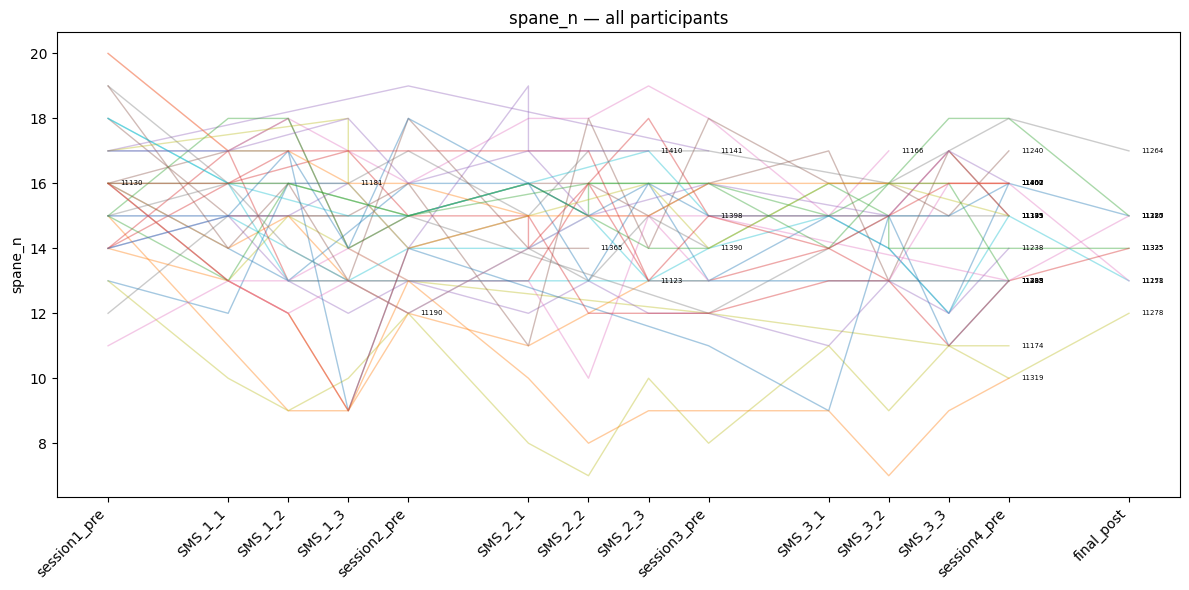

First MCID‐level worsening events (threshold ≥ 2):


part_id     timepoint  spane_n  change
330   11139       SMS_1_1     16.0     2.0
103   11141  session2_pre     19.0     2.0
356   11145       SMS_1_2     18.0     2.0
267   11171       SMS_1_1     15.0     3.0
456   11181       SMS_1_2     16.0     3.0
284   11220       SMS_1_1     18.0     3.0
307   11233       SMS_1_1     17.0     3.0
276   11362       SMS_1_3     16.0     2.0
268   11387       SMS_1_1     13.0     2.0
384   11400       SMS_1_2     17.0     3.0

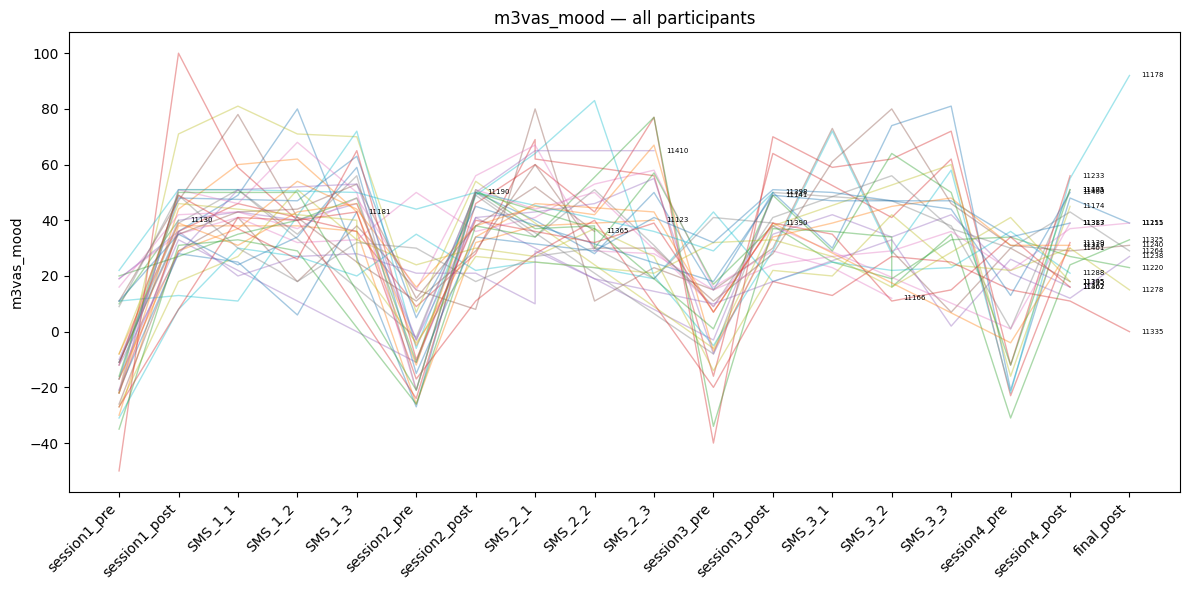

First MCID‐level worsening events (threshold ≥ 12):


part_id     timepoint  m3vas_mood  change
39    11115  session2_pre       -27.0   -16.0
65    11178  session2_pre        -6.0   -17.0
56    11220  session2_pre       -11.0   -31.0
361   11362       SMS_3_3         2.0   -17.0
94    11400  session2_pre       -15.0   -26.0

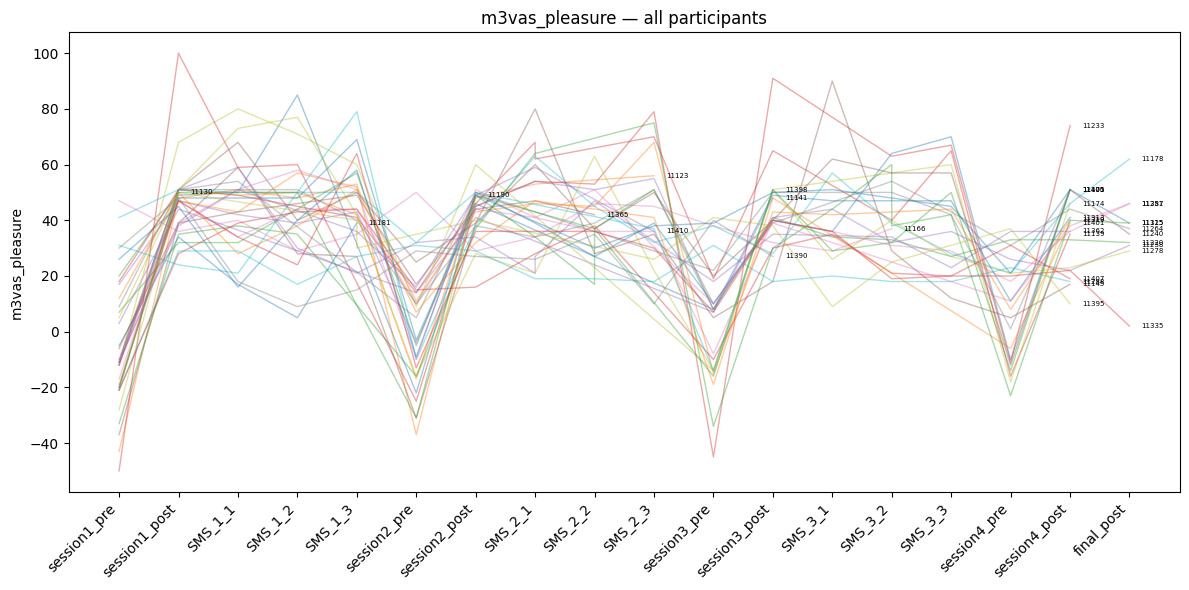

First MCID‐level worsening events (threshold ≥ 12):


part_id     timepoint  m3vas_pleasure  change
113   11139  session4_pre           -16.0   -34.0
405   11166       SMS_1_2            29.0   -18.0
65    11178  session2_pre           -10.0   -41.0
56    11220  session2_pre            -5.0   -12.0
50    11238  session2_pre            -4.0   -21.0
409   11390       SMS_1_1            18.0   -12.0
121   11398  session3_pre           -14.0   -55.0
94    11400  session2_pre            -9.0   -35.0
57    11401  session3_pre           -19.0   -31.0

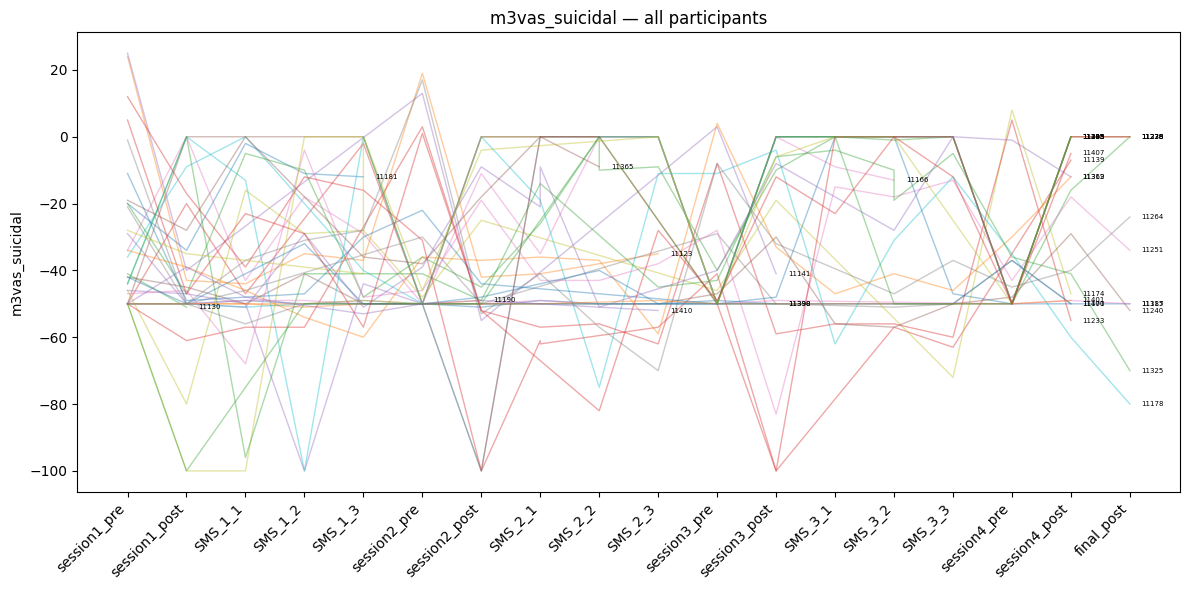

First MCID‐level worsening events (threshold ≥ 12):


part_id      timepoint  m3vas_suicidal  change
168   11139  session1_post           -20.0    30.0
172   11145  session1_post             0.0    50.0
191   11166  session1_post             0.0    34.0
251   11174        SMS_1_1           -16.0    30.0
152   11178  session1_post            -9.0    27.0
451   11181        SMS_1_1            -2.0    18.0
284   11220        SMS_1_1            -5.0    15.0
67    11233   session2_pre             3.0    53.0
159   11238  session2_post             0.0    46.0
175   11240  session3_post           -30.0    12.0
248   11251        SMS_1_2            -4.0    43.0
64    11264   session2_pre            17.0    18.0
254   11278        SMS_1_2             0.0    50.0
171   11288  session1_post             0.0    44.0
86    11319   session3_pre             4.0    38.0
130   11325  session1_post             0.0    44.0
145   11362  session2_post            -9.0    20.0
436   11365        SMS_1_1             0.0    19.0
334   11395        SMS_1_3             0.0    28.0
285   11405        SMS_2_2             0.0    50.0

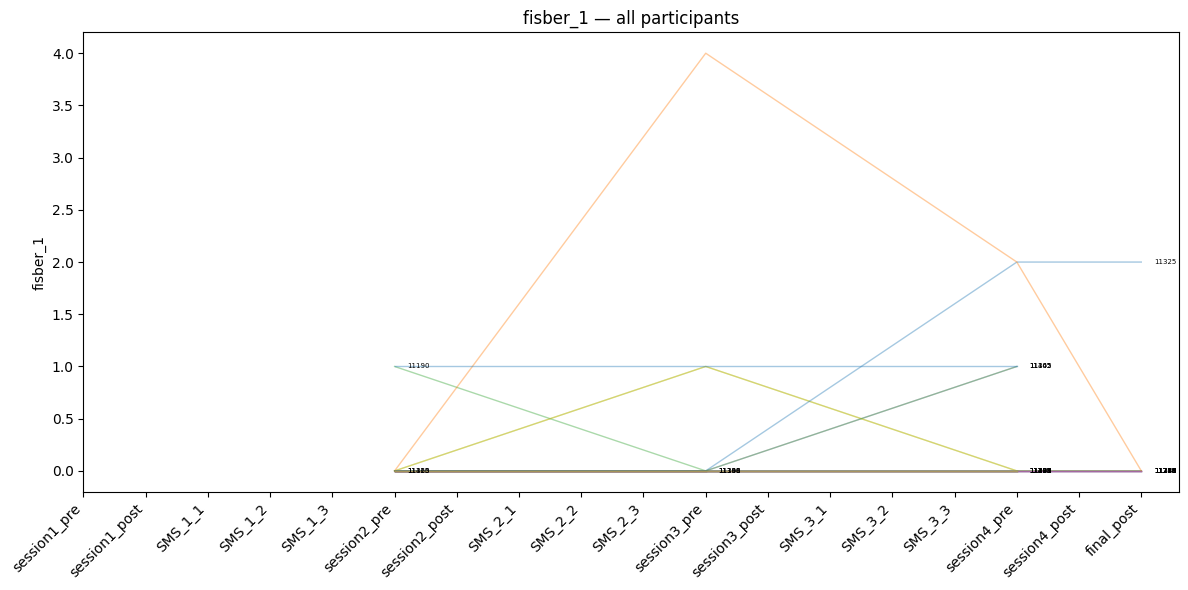

Worsened trajectories (blinded):


part_id     timepoint  fisber_1
0   11145  session2_pre       0.0
1   11145  session3_pre       0.0
2   11145  session4_pre       1.0
3   11325  session2_pre       0.0
4   11325  session3_pre       0.0
5   11325  session4_pre       2.0
6   11325    final_post       2.0
7   11362  session2_pre       0.0
8   11362  session3_pre       0.0
9   11362  session4_pre       1.0

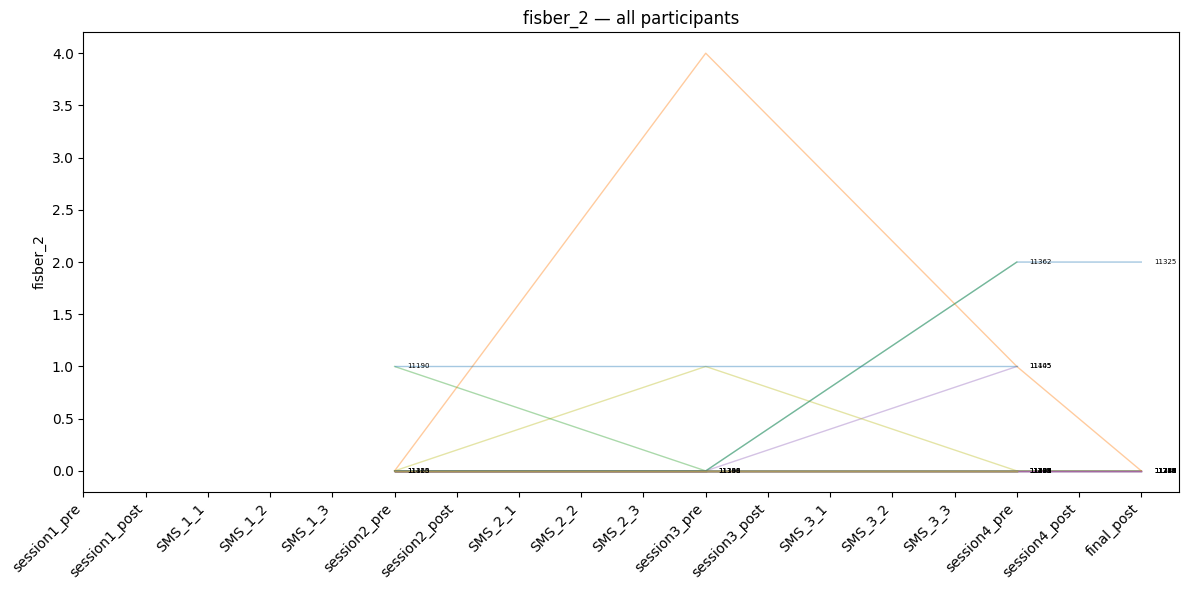

Worsened trajectories (blinded):


part_id     timepoint  fisber_2
0   11145  session2_pre       0.0
1   11145  session3_pre       0.0
2   11145  session4_pre       1.0
3   11325  session2_pre       0.0
4   11325  session3_pre       0.0
5   11325  session4_pre       2.0
6   11325    final_post       2.0
7   11362  session2_pre       0.0
8   11362  session3_pre       0.0
9   11362  session4_pre       2.0

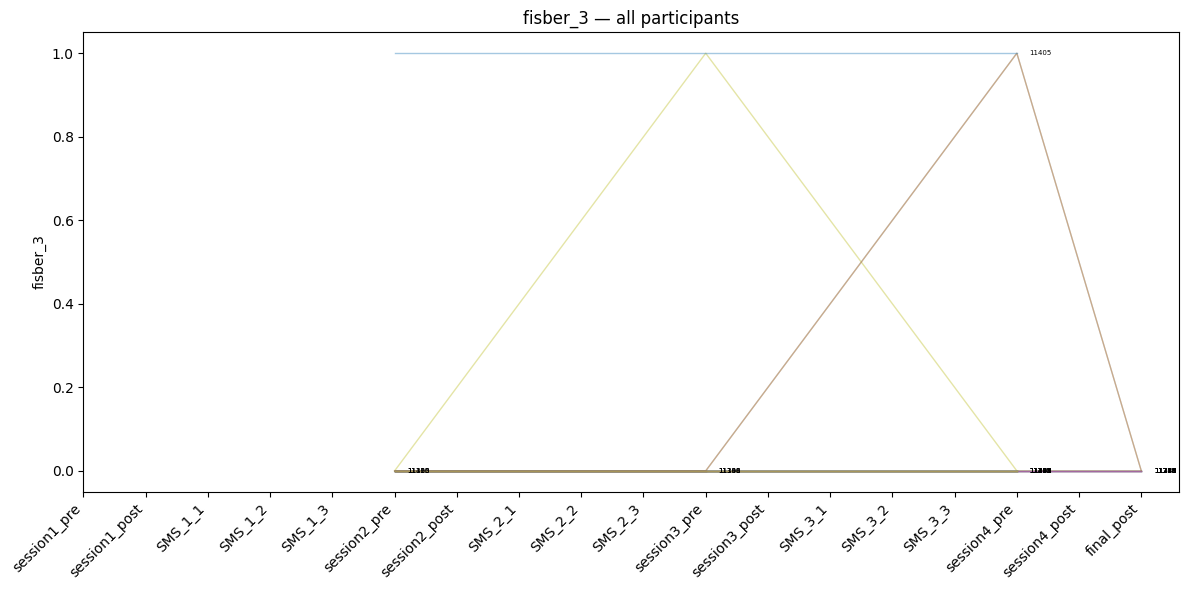

No worsening detected across the sample.


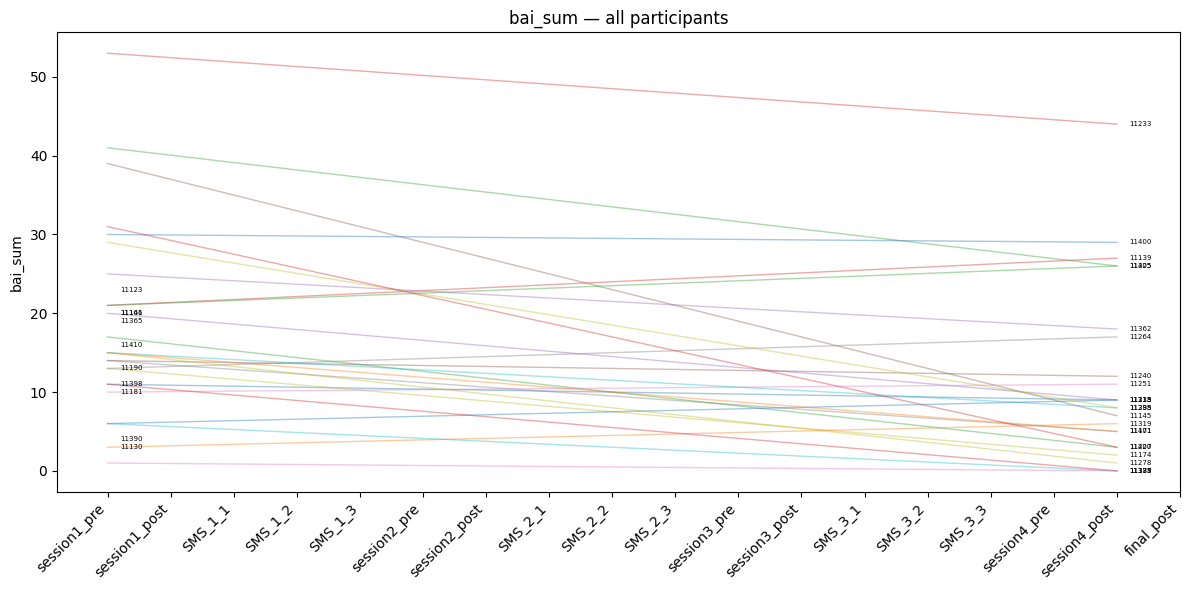

Worsened trajectories (blinded):


part_id      timepoint  bai_sum
0    11139   session1_pre     21.0
1    11139  session4_post     27.0
2    11251   session1_pre     10.0
3    11251  session4_post     11.0
4    11264   session1_pre     13.0
5    11264  session4_post     17.0
6    11313   session1_pre      6.0
7    11313  session4_post      9.0
8    11319   session1_pre      3.0
9    11319  session4_post      6.0
10   11405   session1_pre     21.0
11   11405  session4_post     26.0

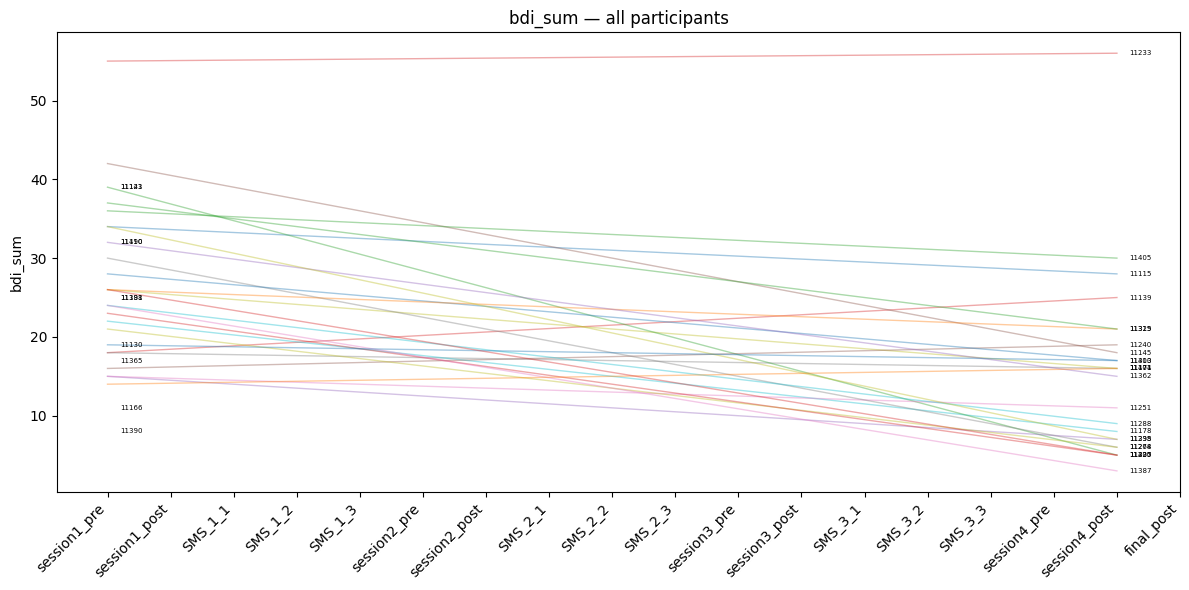

Worsened trajectories (blinded):


part_id      timepoint  bdi_sum
0   11139   session1_pre     18.0
1   11139  session4_post     25.0
2   11233   session1_pre     55.0
3   11233  session4_post     56.0
4   11240   session1_pre     16.0
5   11240  session4_post     19.0
6   11401   session1_pre     14.0
7   11401  session4_post     16.0

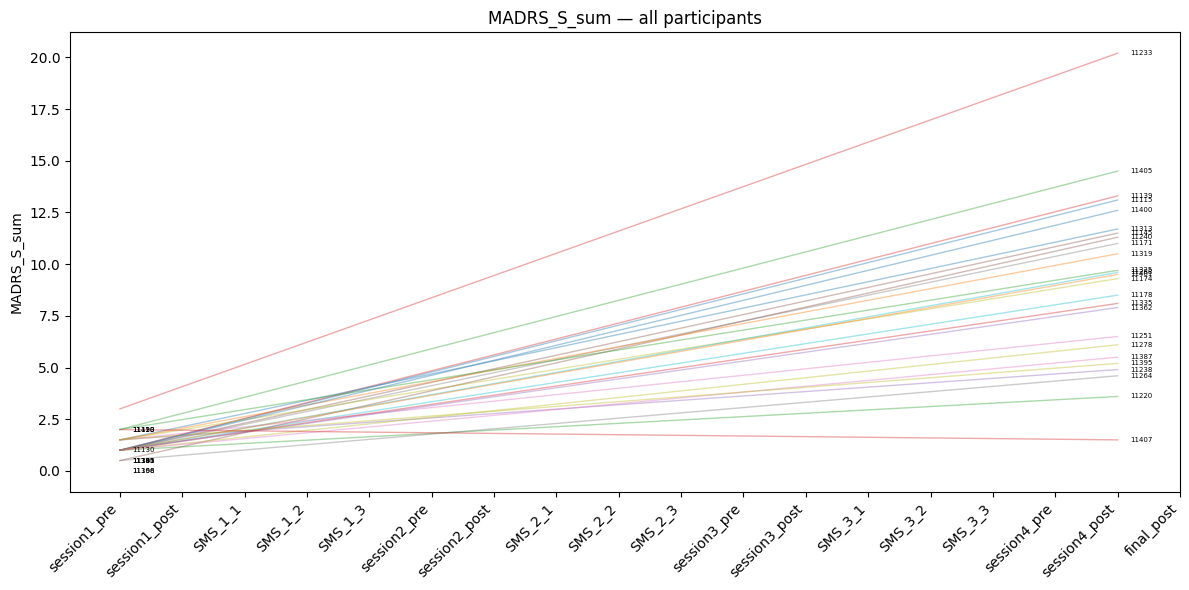

Worsened trajectories (blinded):


part_id      timepoint  MADRS_S_sum
0    11115   session1_pre          1.0
1    11115  session4_post         13.1
2    11139   session1_pre          1.0
3    11139  session4_post         13.3
4    11145   session1_pre          1.0
5    11145  session4_post         11.5
6    11171   session1_pre          1.0
7    11171  session4_post         11.0
8    11174   session1_pre          1.5
9    11174  session4_post          9.3
10   11178   session1_pre          1.0
11   11178  session4_post          8.5
12   11220   session1_pre          1.0
13   11220  session4_post          3.6
14   11233   session1_pre          3.0
15   11233  session4_post         20.2
16   11238   session1_pre          1.5
17   11238  session4_post          4.9
18   11240   session1_pre          0.5
19   11240  session4_post         11.3
20   11251   session1_pre          1.5
21   11251  session4_post          6.5
22   11264   session1_pre          0.5
23   11264  session4_post          4.6
24   11278   session1_pre          1.0
25   11278  session4_post          6.1
26   11288   session1_pre          1.0
27   11288  session4_post          9.6
28   11313   session1_pre          1.5
29   11313  session4_post         11.7
30   11319   session1_pre          1.5
31   11319  session4_post         10.5
32   11325   session1_pre          2.0
33   11325  session4_post          9.7
34   11335   session1_pre          1.0
35   11335  session4_post          8.1
36   11362   session1_pre          1.0
37   11362  session4_post          7.9
38   11387   session1_pre          1.0
39   11387  session4_post          5.5
40   11395   session1_pre          1.5
41   11395  session4_post          5.2
42   11400   session1_pre          1.0
43   11400  session4_post         12.6
44   11401   session1_pre          1.0
45   11401  session4_post          9.5
46   11405   session1_pre          2.0
47   11405  session4_post         14.5

In [5]:
import re
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

#####
# 0) SETTINGS
#####
DATA_DIR = Path('/content')

#####
# 1) UTILITY TO FIND EXACTLY ONE CSV
#####
def find_csv(substring: str) -> Path:
    matches = list(DATA_DIR.glob(f'*{substring}*.csv'))
    if not matches:
        raise FileNotFoundError(f"No file matching '{substring}' in {DATA_DIR}")
    if len(matches) > 1:
        raise ValueError(f"Multiple files match '{substring}': {matches}")
    return matches[0]

#####
# 1b) TRY TO LOAD A CSV, BUT SKIP IF MISSING OR AMBIGUOUS
#####
def try_load(substring: str) -> pd.DataFrame | None:
    try:
        path = find_csv(substring)
    except (FileNotFoundError, ValueError) as e:
        print(f"Skipping '{substring}': {e}")
        return None
    print(f"Loaded '{substring}' from {path.name}")
    return pd.read_csv(path, dtype=str)

#####
# 2) LOAD ALL WELLBEING CSVS (skipping any that aren’t there yet)
#####
df_s1_pre     = try_load('pre_session_1')
df_s2to4_pre  = try_load('pre_sessions_2-4')
df_s2to4_post = try_load('post_sessions_1-3')
df_s4_post    = try_load('post_session_4')
df_sms        = try_load('sms_day1,3,5')

#  — new step: trim SMS part_ids —
if df_sms is not None:
    df_sms['part_id'] = (
        df_sms['part_id']
              .astype(str)
              .str.strip()
              .str[:5]
    )
    print("Trimmed df_sms.part_id to first 5 characters")

df_final      = try_load('sms_post')

# Collect only the ones that actually loaded
all_dfs = [df for df in (
    df_s1_pre,
    df_s2to4_pre,
    df_s2to4_post,
    df_s4_post,
    df_sms,
    df_final
) if df is not None]

if not all_dfs:
    raise RuntimeError("No data files found to process!")

#####
# 3) CLEAN BDI ITEMS (extract leading number)
#####
for df in all_dfs:
    bdi_raw = [c for c in df.columns if re.fullmatch(r"bdi_\d+(?:_1)?", c)]
    for col in bdi_raw:
        df[col] = (
            df[col].astype(str)
                  .str.extract(r'^(\d+)')[0]
                  .astype(float)
        )

#####
# 4) SUM SCALES
#####
def sum_scale(df, cols, new_col):
    df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')
    df[new_col] = df[cols].sum(axis=1)

def get_scale_cols(df, prefix, count, allow_suffix=False):
    cols = []
    for i in range(1, count+1):
        main = f"{prefix}_{i}"
        alt  = f"{prefix}_{i}_1"
        if main in df.columns:
            cols.append(main)
        elif allow_suffix and alt in df.columns:
            cols.append(alt)
    return cols

for df in all_dfs:
    # BAI
    bai_cols = get_scale_cols(df, 'bai', 21)
    if bai_cols:
        sum_scale(df, bai_cols, 'bai_sum')
    # BDI
    bdi_cols = get_scale_cols(df, 'bdi', 21)
    if bdi_cols:
        sum_scale(df, bdi_cols, 'bdi_sum')
    # MADRS
    madrs_cols = get_scale_cols(df, 'madrs', 9, allow_suffix=True)
    if madrs_cols:
        sum_scale(df, madrs_cols, 'MADRS_S_sum')

#####
# 5) STANDARDIZE M3VAS
#####
def standardize_m3vas(df):
    to_drop = []
    for var in ('suicidal','mood','pleasure'):
        # find change‐score first, then raw‐score
        ch_col  = next((c for c in df.columns
                        if re.fullmatch(rf"m3vas_ch_{var}(?:_1)?", c)), None)
        raw_col = next((c for c in df.columns
                        if re.fullmatch(rf"m3vas_{var}(?:_1)?",    c)), None)

        if ch_col:
            vals = pd.to_numeric(df[ch_col], errors='coerce') - 50
            to_drop.append(ch_col)
        elif raw_col:
            vals = pd.to_numeric(df[raw_col], errors='coerce') - 50
            to_drop.append(raw_col)
        else:
            continue

        if var == 'suicidal':
            # leave as-is: + means more suicidal (worse), so improvement → down
            df[f"m3vas_{var}"] = vals
        else:
            # mood & pleasure: + means improvement, so flip sign
            df[f"m3vas_{var}"] = -vals

    # drop only the original raw/change columns
    df.drop(columns=to_drop, inplace=True, errors='ignore')

# apply to each dataframe
for df in all_dfs:
    standardize_m3vas(df)

#####
# 6) CLEAN FISBER
#####
for df in all_dfs:
    for col in ('fisber_1','fisber_2','fisber_3'):
        if col in df.columns:
            df[col] = (
                df[col].astype(str)
                       .str.extract(r'(\d+)$')[0]
                       .astype(float)
            )

#####
# 7) COERCE TYPES
#####
# session_n for sessions
for df in (df_s1_pre, df_s2to4_pre, df_s2to4_post, df_s4_post):
    if df is not None and 'session_n' in df.columns:
        df['session_n'] = pd.to_numeric(df['session_n'], errors='coerce').astype('Int64')

# session_n & sms_n for SMS
if df_sms is not None:
    for col in ('session_n','sms_n'):
        if col in df_sms.columns:
            df_sms[col] = pd.to_numeric(df_sms[col], errors='coerce').astype('Int64')

# numeric scales
numeric_cols = [
    'phq9_sum','spane_p','spane_n',
    'm3vas_mood','m3vas_pleasure','m3vas_suicidal',
    'fisber_1','fisber_2','fisber_3',
    'bai_sum','bdi_sum','MADRS_S_sum'
]
for df in all_dfs:
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

#####
# 8) ENSURE EVERY DF HAS part_id
#####
for df in all_dfs:
    if 'part_id' not in df.columns:
        if 'ProlificID' in df.columns:
            df.rename(columns={'ProlificID':'part_id'}, inplace=True)
        else:
            df['part_id'] = df.index.astype(str)
    df['part_id'] = df['part_id'].astype(str).str.strip()

#####
# 9) TAG TIMEPOINTS
#####
if df_s1_pre    is not None: df_s1_pre    ['timepoint'] = 'session1_pre'
if df_s2to4_pre is not None: df_s2to4_pre ['timepoint'] = df_s2to4_pre.apply(lambda r: f"session{r.session_n}_pre",  axis=1)
if df_s2to4_post is not None: df_s2to4_post['timepoint'] = df_s2to4_post.apply(lambda r: f"session{r.session_n}_post", axis=1)
if df_s4_post   is not None: df_s4_post   ['timepoint'] = 'session4_post'
if df_sms       is not None: df_sms       ['timepoint'] = df_sms.apply(lambda r: f"SMS_{r.session_n}_{r.sms_n}", axis=1)
if df_final     is not None: df_final     ['timepoint'] = 'final_post'

#####
# 10) CONCATENATE
#####
df_long = pd.concat(all_dfs, ignore_index=True)

#####
# 11) DROP NON-NUMERIC part_id
#####
df_long = df_long[df_long['part_id'].str.match(r'^\d+$', na=False)]

#####
# 12) MERGE IN CONDITION (if assignments file was found)
#####
df_assign = try_load('wp2_assignments')
if df_assign is not None:
    df_long = df_long.merge(
        df_assign[['part_id','condition']],
        on='part_id',
        how='inner'
    )
else:
    print("No assignments file: skipping merge with 'condition' column")

#####
# 13) DEFINE & APPLY ORDERED CATEGORICAL FOR timepoint
#####
ordered_timepoints = [
    'session1_pre','session1_post',
    'SMS_1_1','SMS_1_2','SMS_1_3',
    'session2_pre','session2_post',
    'SMS_2_1','SMS_2_2','SMS_2_3',
    'session3_pre','session3_post',
    'SMS_3_1','SMS_3_2','SMS_3_3',
    'session4_pre','session4_post',
    'final_post'
]
df_long['timepoint'] = pd.Categorical(
    df_long['timepoint'],
    categories=ordered_timepoints,
    ordered=True
)

#####
# 14) PLOTTING + FLAGGING ACROSS ALL PARTICIPANTS (BLINDED)
#####
bad_if_higher = {
    'phq9_sum',
    'spane_n',
    'fisber_1','fisber_2','fisber_3',
    'bai_sum','bdi_sum','MADRS_S_sum',
    'm3vas_suicidal'   # higher = more suicidal = worse
}

bad_if_lower = {
    'spane_p',
    'm3vas_mood',      # higher = better mood, so a drop is worsening
    'm3vas_pleasure'   # higher = better pleasure, so a drop is worsening
}

mcid_thresholds = {
    'phq9_sum': 5,
    'spane_p': 2,
    'spane_n': 2,
    'm3vas_mood': 12,
    'm3vas_pleasure': 12,
    'm3vas_suicidal': 12
}

#####
# ADJUST M3VAS SO 50 → 0 (“no change”), 0 → –50 (worse), 100 → +50 (better)
#####
def standardize_m3vas(df):
    for var in ('suicidal','mood','pleasure'):
        # detect the two possible inputs
        raw_col = next((c for c in df.columns
                        if re.fullmatch(f"m3vas_{var}(?:_1)?", c)), None)
        ch_col  = next((c for c in df.columns
                        if re.fullmatch(f"m3vas_ch_{var}(?:_1)?", c)),  None)

        if raw_col is not None:
            # pre‐session raw VAS: 0 (best) → 100 (worst)
            vals = pd.to_numeric(df[raw_col], errors='coerce') - 50
        elif ch_col is not None:
            # post‐session change VAS: already –50 (better) → +50 (worse)
            vals = pd.to_numeric(df[ch_col], errors='coerce')
        else:
            continue

        # for mood & pleasure, invert so higher = more distress
        if var in ('mood','pleasure'):
            vals = -vals

        df[f"m3vas_{var}"] = vals

    # drop all the old raw / ch columns
    drop_re = re.compile(
        r"^(?:m3vas_ch_(?:mood|pleasure|suicidal)(?:_1)?"
        r"|m3vas_(?:mood|pleasure|suicidal)_1)$"
    )
    to_drop = [c for c in df.columns if drop_re.match(c)]
    df.drop(columns=to_drop, errors='ignore', inplace=True)

# Apply to each dataframe
for df in all_dfs:
    standardize_m3vas(df)

#####
# PLOTTING & FLAGGING FUNCTION
#####
def plot_trajectories_and_flag(measure):
    if measure not in df_long.columns:
        print(f"→ skipping '{measure}': not in df_long")
        return

    # 1) Copy & drop session*_post for PHQ-9 and SPANE scales
    df_plot = df_long.copy()
    if measure in ('phq9_sum','spane_p','spane_n'):
        mask = df_plot['timepoint'].astype(str).str.match(r'^session\d+_post$')
        df_plot = df_plot[~mask]

    # 2) Determine which timepoints remain, preserving order
    timepoints_present = [tp for tp in ordered_timepoints if tp in df_plot['timepoint'].values]
    code_map = {tp: i for i, tp in enumerate(ordered_timepoints)}

    # 3) Plot trajectories
    fig, ax = plt.subplots(figsize=(12,6))
    for pid, grp in df_plot.groupby('part_id'):
        s = grp.dropna(subset=['timepoint', measure]).sort_values('timepoint')
        if s.empty:
            continue
        x = s['timepoint'].cat.codes
        y = s[measure].astype(float)
        ax.plot(x, y, linewidth=1, alpha=0.4)
        ax.text(x.iloc[-1] + 0.2, y.iloc[-1], pid, fontsize=5, va='center')

    # 4) Set ticks only for the retained timepoints
    tick_locs   = [code_map[tp] for tp in timepoints_present]
    tick_labels = timepoints_present
    ax.set_xticks(tick_locs)
    ax.set_xticklabels(tick_labels, rotation=45, ha='right')

    ax.set_ylabel(measure)
    ax.set_title(f"{measure} — all participants")
    plt.tight_layout()
    plt.show()

    # 5) Flag first MCID‐level worsening events
    if measure in mcid_thresholds:
        th = mcid_thresholds[measure]
        breach_events = []

        for pid, grp_pid in df_plot.groupby('part_id'):
            seq = (
                grp_pid
                .dropna(subset=['timepoint', measure])
                .sort_values('timepoint')
                .loc[:, ['part_id','timepoint', measure]]
                .assign(change=lambda d: d[measure] - d[measure].iloc[0])
            )
            if measure in bad_if_higher:
                mask = seq['change'] >= th
            else:
                mask = seq['change'] <= -th

            if mask.any():
                breach_events.append(seq[mask].iloc[0])

        if breach_events:
            df_breaches = pd.DataFrame(breach_events)
            print(f"First MCID‐level worsening events (threshold ≥ {th}):")
            display(df_breaches)
        else:
            print(f"No participants worsened by at least the MCID of {th} for {measure}.")

    else:
        # 6) Fallback: any participant whose final point is worse than their first
        worsened = []
        for pid, grp_pid in df_plot.groupby('part_id'):
            seq = grp_pid.dropna(subset=['timepoint', measure]) \
                         .sort_values('timepoint')[measure] \
                         .astype(float)
            if len(seq) < 2:
                continue
            if ((measure in bad_if_higher and seq.iloc[-1] > seq.iloc[0]) or
                (measure in bad_if_lower  and seq.iloc[-1] < seq.iloc[0])):
                worsened.append(pid)

        if worsened:
            print("Worsened trajectories (blinded):")
            display(
                df_plot[df_plot['part_id'].isin(worsened)]
                       [['part_id','timepoint',measure]]
                       .dropna(subset=[measure])
                       .sort_values(['part_id','timepoint'])
                       .reset_index(drop=True)
            )
        else:
            print("No worsening detected across the sample.")

#####
# RUN FOR ALL MEASURES
#####
for m in measures:
    plot_trajectories_and_flag(m)

Mean Tolerability ± SD Assessment Across Sessions (Whole-Sample & Just-Adverse)
*   run previous monitoring and stratification scripts first to generate necessary dfs

In [6]:
import numpy as np
import pandas as pd
from pathlib import Path

#####
# 0) Load and clean all post-session data (sessions 1–4)
#####
from pathlib import Path
import glob

DATA_DIR = Path('/content')
# Glob all post-session CSVs (e.g. sessions 1-3 and session 4)
post_files = sorted(str(f) for f in DATA_DIR.glob('wp2_post_session*csv'))

# Read each file, skip metadata row, and assign timepoint
frames = []
for fpath in post_files:
    temp = pd.read_csv(fpath, header=0, skiprows=[1], dtype=str)
    temp.columns = temp.columns.str.strip()
    temp['part_id'] = temp['part_id'].astype(str).str.strip()
    # If session_n column present, map it
    if 'session_n' in temp.columns:
        temp['session_n'] = pd.to_numeric(temp['session_n'], errors='coerce')
        temp['timepoint'] = temp['session_n'].apply(lambda x: f'session{int(x)}_post' if pd.notna(x) else None)
    else:
        # infer session4_post from filename
        temp['timepoint'] = 'session4_post'
    frames.append(temp)

# Concatenate all sessions
df_raw = pd.concat(frames, ignore_index=True)

#####
# 1) Compute tol_score (max across all tol_follow items)
##### tol_score per row (max across all tol_follow items)
#####
tol_cols = [c for c in df_raw.columns if c.lower().startswith('tol_follow')]
for col in tol_cols:
    df_raw[col] = pd.to_numeric(df_raw[col], errors='coerce').fillna(0)

df_raw['tol_score'] = df_raw[tol_cols].max(axis=1)

#####
# 2) Merge in condition assignments
#####
assign = pd.read_csv('wp2_assignments.csv', dtype=str)[['part_id','condition']]
df = df_raw.merge(assign, on='part_id', how='left')

#####
# 3) Summarize per-participant-session
#####
tol_summary = (
    df
      .groupby(['part_id','condition','timepoint'], observed=False)
      .agg(tol_score=('tol_score', 'max'))
      .reset_index()
)

#####
# 4a) Mean ± SD including zeros, by arm and session
#####
tol_stats_all = (
    tol_summary
      .groupby(['condition','timepoint'], observed=False)
      .agg(
          tol_mean_all=('tol_score', 'mean'),
          tol_sd_all=('tol_score', 'std')
      )
      .round(2)
      .reset_index()
)

print("Tolerability score including zeros (mean ± SD), by condition and session:")
display(
    tol_stats_all.pivot(
        index='condition',
        columns='timepoint',
        values=['tol_mean_all','tol_sd_all']
    )
)

#####
# 4b) Mean ± SD & N among those with any side effect (tol_score > 0)
#####
tol_stats_nonzero = (
    tol_summary[tol_summary['tol_score'] > 0]
      .groupby(['condition','timepoint'], observed=False)
      .agg(
          tol_mean_nonzero=('tol_score', 'mean'),
          tol_sd_nonzero=('tol_score', lambda x: x.std(ddof=0)),
          n_side_effects=('tol_score', 'count')
      )
      .round(2)
      .reset_index()
)

print("Tolerability score among those with side effects (mean ± SD, N), by condition and session:")
display(
    tol_stats_nonzero.pivot(
        index='condition',
        columns='timepoint',
        values=['tol_mean_nonzero','tol_sd_nonzero','n_side_effects']
    )
)

Tolerability score including zeros (mean ± SD), by condition and session:


tol_mean_all                                            \
timepoint    session1_post session2_post session3_post session4_post   
condition                                                              
control               0.00          0.19          0.00           0.1   
intervention          0.32          0.06          0.12           0.0   

                tol_sd_all                                            
timepoint    session1_post session2_post session3_post session4_post  
condition                                                             
control               0.00          0.54          0.00          0.32  
intervention          0.82          0.24          0.49          0.00

Tolerability score among those with side effects (mean ± SD, N), by condition and session:


tol_mean_nonzero                                            \
timepoint       session1_post session2_post session3_post session4_post   
condition                                                                 
control                   NaN           1.5           NaN           1.0   
intervention              2.0           1.0           2.0           NaN   

             tol_sd_nonzero                                            \
timepoint     session1_post session2_post session3_post session4_post   
condition                                                               
control                 NaN           0.5           NaN           0.0   
intervention           0.82           0.0           0.0           NaN   

             n_side_effects                                            
timepoint     session1_post session2_post session3_post session4_post  
condition                                                              
control                 NaN           2.0           NaN           1.0  
intervention            3.0           1.0           1.0           NaN

## Modeling Junkyard

Trimmed df_sms.part_id to first 5 characters


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 51.502505
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipython-input-7-3150894577.py:240: FutureWarning: The default of observed=False is deprecated and will be changed to True

                    Mixed Linear Model Regression Results
Model:                     MixedLM        Dependent Variable:        phq9_sum 
No. Observations:          353            Method:                    REML     
No. Groups:                35             Scale:                     5.5551   
Min. group size:           1              Log-Likelihood:            -951.8330
Max. group size:           15             Converged:                 No       
Mean group size:           10.1                                               
------------------------------------------------------------------------------
                                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------
Intercept                           11.224    1.643  6.832 0.000  8.004 14.445
condition[T.intervention]           -1.333    2.230 -0.598 0.550 -5.704  3.038
time_num                            -0.145    0.343 -0.423 0.672 -0.818  

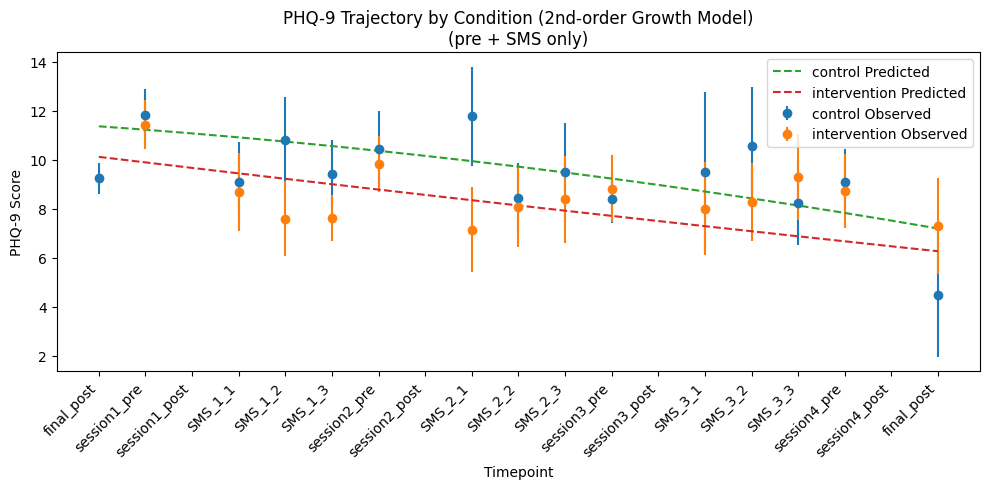

In [7]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import statsmodels.formula.api as smf

#####
# 0) SETTINGS
#####
DATA_DIR = Path('/content')

#####
# 1) UTILITIES TO LOAD CSVs
#####
def find_csv(substring: str) -> Path:
    matches = list(DATA_DIR.glob(f'*{substring}*.csv'))
    if not matches:
        raise FileNotFoundError(f"No file matching '{substring}'")
    if len(matches) > 1:
        raise ValueError(f"Multiple files match '{substring}': {matches}")
    return matches[0]

def try_load(substring: str) -> pd.DataFrame | None:
    try:
        path = find_csv(substring)
    except (FileNotFoundError, ValueError):
        return None
    return pd.read_csv(path, dtype=str)

#####
# 2) LOAD ALL WELLBEING CSVS (skipping any that aren’t there yet)
#####
df_s1_pre     = try_load('pre_session_1')
df_s2to4_pre  = try_load('pre_sessions_2-4')
df_s2to4_post = try_load('post_sessions_1-3')
df_s4_post    = try_load('post_session_4')
df_sms        = try_load('sms_day1,3,5')

#  — new step: trim SMS part_ids —
if df_sms is not None:
    df_sms['part_id'] = (
        df_sms['part_id']
              .astype(str)
              .str.strip()
              .str[:5]
    )
    print("Trimmed df_sms.part_id to first 5 characters")

df_final      = try_load('sms_post')

# Collect only the ones that actually loaded
all_dfs = [df for df in (
    df_s1_pre,
    df_s2to4_pre,
    df_s2to4_post,
    df_s4_post,
    df_sms,
    df_final
) if df is not None]

if not all_dfs:
    raise RuntimeError("No data files found to process!")

#####
# 2) CLEAN & SUM SCALES (BDI, BAI, MADRS)
#####
def sum_scale(df, cols, out):
    df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')
    df[out] = df[cols].sum(axis=1)

def get_scale_cols(df, prefix, count, allow_suffix=False):
    cols = []
    for i in range(1, count+1):
        main = f"{prefix}_{i}"
        alt  = f"{prefix}_{i}_1"
        if main in df.columns:
            cols.append(main)
        elif allow_suffix and alt in df.columns:
            cols.append(alt)
    return cols

for df in all_dfs:
    # extract numeric from BDI
    for col in [c for c in df.columns if re.fullmatch(r"bdi_\d+(?:_1)?", c)]:
        df[col] = df[col].astype(str).str.extract(r"^(\d+)")[0].astype(float)
    # BAI
    bai = get_scale_cols(df, 'bai', 21)
    if bai: sum_scale(df, bai, 'bai_sum')
    # BDI
    bdi = get_scale_cols(df, 'bdi', 21)
    if bdi: sum_scale(df, bdi, 'bdi_sum')
    # MADRS
    madrs = get_scale_cols(df, 'madrs', 9, allow_suffix=True)
    if madrs: sum_scale(df, madrs, 'MADRS_S_sum')

#####
# 3) STANDARDIZE M3VAS TO –50…+50
#####
def standardize_m3vas(df):
    for var in ('suicidal','mood','pleasure'):
        raw = next((c for c in df.columns if re.fullmatch(f"m3vas_{var}(?:_1)?", c)), None)
        ch  = next((c for c in df.columns if re.fullmatch(f"m3vas_ch_{var}(?:_1)?", c)),  None)
        if var == 'suicidal':
            if raw is not None:
                df['m3vas_suicidal'] = pd.to_numeric(df[raw], errors='coerce') - 50
            elif ch is not None:
                df['m3vas_suicidal'] = pd.to_numeric(df[ch],  errors='coerce') - 50
        else:
            if raw is not None:
                df[f"m3vas_{var}"] = 50 - pd.to_numeric(df[raw], errors='coerce')
            elif ch is not None:
                df[f"m3vas_{var}"] = pd.to_numeric(df[ch], errors='coerce') - 50
    # drop old raw / change columns
    drop_pattern = re.compile(
        r"^(?:m3vas_ch_(?:mood|pleasure|suicidal)(?:_1)?|m3vas_(?:mood|pleasure|suicidal)_1)$"
    )
    to_drop = [c for c in df.columns if drop_pattern.match(c)]
    df.drop(columns=to_drop, errors='ignore', inplace=True)

for df in all_dfs:
    standardize_m3vas(df)

#####
# 4) CLEAN FISBER & COERCE TYPES
#####
for df in all_dfs:
    for c in ('fisber_1','fisber_2','fisber_3'):
        if c in df.columns:
            df[c] = df[c].astype(str).str.extract(r"(\d+)$")[0].astype(float)
    # numeric scales
    for col in [
        'phq9_sum','spane_p','spane_n',
        'm3vas_suicidal','m3vas_mood','m3vas_pleasure',
        'fisber_1','fisber_2','fisber_3',
        'bai_sum','bdi_sum','MADRS_S_sum'
    ]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

#####
# 5) ENSURE part_id & TAG TIMEPOINTS
#####
for df in all_dfs:
    if 'part_id' not in df.columns:
        if 'ProlificID' in df.columns:
            df.rename(columns={'ProlificID':'part_id'}, inplace=True)
        else:
            df['part_id'] = df.index.astype(str)
    df['part_id'] = df['part_id'].astype(str).str.strip()

if df_s1_pre is not None:
    df_s1_pre['timepoint'] = 'session1_pre'
if df_s2to4_pre is not None:
    df_s2to4_pre['timepoint'] = df_s2to4_pre.apply(
        lambda r: f"session{r.session_n}_pre", axis=1
    )
if df_s2to4_post is not None:
    df_s2to4_post['timepoint'] = df_s2to4_post.apply(
        lambda r: f"session{r.session_n}_post", axis=1
    )
if df_s4_post is not None:
    df_s4_post['timepoint'] = 'session4_post'
if df_sms is not None:
    df_sms['timepoint'] = df_sms.apply(
        lambda r: f"SMS_{r.session_n}_{r.sms_n}", axis=1
    )
if df_final is not None:
    df_final['timepoint'] = 'final_post'

# Concatenate
df_long = pd.concat(all_dfs, ignore_index=True)
df_long = df_long[df_long['part_id'].str.match(r'^\d+$', na=False)]

# Merge condition assignments if available
df_assign = try_load('wp2_assignments')
if df_assign is not None:
    df_long = df_long.merge(df_assign[['part_id','condition']],
                            on='part_id', how='inner')

#####
# 6) ORDER TIMEPOINTS & CREATE TIME VARIABLES
#####
ordered_timepoints = [
    'session1_pre','session1_post',
    'SMS_1_1','SMS_1_2','SMS_1_3',
    'session2_pre','session2_post',
    'SMS_2_1','SMS_2_2','SMS_2_3',
    'session3_pre','session3_post',
    'SMS_3_1','SMS_3_2','SMS_3_3',
    'session4_pre','session4_post',
    'final_post'
]
df_long['timepoint'] = pd.Categorical(
    df_long['timepoint'], categories=ordered_timepoints, ordered=True
)
df_long['time_num']  = df_long['timepoint'].cat.codes
df_long['time_num2'] = df_long['time_num']**2

# — after df_long['time_num2'] = df_long['time_num']**2 —

# 7a) EXCLUDE ALL sessionN_post TIMEPOINTS FOR THE PHQ-9 MODEL
mask_post = df_long['timepoint'].astype(str).str.match(r'^session\d+_post$')
df_model = df_long[~mask_post].copy()

#####
# 7b) FIT 2ND-ORDER MIXED-EFFECTS GROWTH MODEL FOR PHQ-9 (pre + SMS only)
#####
# — right after creating df_model —
# drop any rows missing the outcome or any of the predictors
df_model = df_model.dropna(
    subset=[
        'phq9_sum',    # outcome
        'time_num',
        'time_num2',   # quadratic term
        'condition'
    ]
)

# optionally ensure condition is treated as categorical
df_model['condition'] = df_model['condition'].astype('category')

# now fit
model = smf.mixedlm(
    "phq9_sum ~ time_num * condition + time_num2 * condition",
    data=df_model,
    groups="part_id",
    re_formula="~time_num"
)
res = model.fit(method='lbfgs')
print(res.summary())


#####
# 8) PLOT OBSERVED MEANS ± SEM AND MODEL PREDICTIONS (pre + SMS only)
#####
# Observed summary on df_model
obs = (
    df_model
    .groupby(['condition','time_num'])['phq9_sum']
    .agg(['mean','sem'])
    .reset_index()
)

# Prediction grid stays the same
time_vals = np.arange(df_model['time_num'].min(),
                      df_model['time_num'].max()+1)
conds     = df_model['condition'].dropna().unique()
pred = pd.DataFrame([
    {'time_num': t, 'time_num2': t**2, 'condition': c}
    for c in conds for t in time_vals
])
pred['predicted'] = res.predict(pred)

# Plot
plt.figure(figsize=(10,5))
for cond, grp in obs.groupby('condition'):
    plt.errorbar(grp['time_num'], grp['mean'], yerr=grp['sem'],
                 fmt='o', label=f"{cond} Observed")
for cond in conds:
    sub = pred[pred['condition']==cond]
    plt.plot(sub['time_num'], sub['predicted'], '--',
             label=f"{cond} Predicted")

# Only label the timepoints actually in df_model
labels = [ordered_timepoints[i] for i in time_vals]
plt.xticks(time_vals, labels, rotation=45, ha='right')

plt.xlabel("Timepoint")
plt.ylabel("PHQ-9 Score")
plt.title("PHQ-9 Trajectory by Condition (2nd-order Growth Model)\n(pre + SMS only)")
plt.legend()
plt.tight_layout()
plt.show()

                 Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      phq9_sum 
No. Observations:       353          Method:                  REML     
No. Groups:             35           Scale:                   7.5964   
Min. group size:        1            Log-Likelihood:          -917.1457
Max. group size:        15           Converged:               Yes      
Mean group size:        10.1                                           
-----------------------------------------------------------------------
                             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------
Intercept                    10.038    1.200  8.366 0.000  7.686 12.390
condition[T.intervention]    -1.541    1.629 -0.946 0.344 -4.733  1.651
tc                           -0.107    0.047 -2.251 0.024 -0.200 -0.014
tc:condition[T.intervention] -0.078    0.062 -1.257 0.209 -0.200  0.044
part_id V

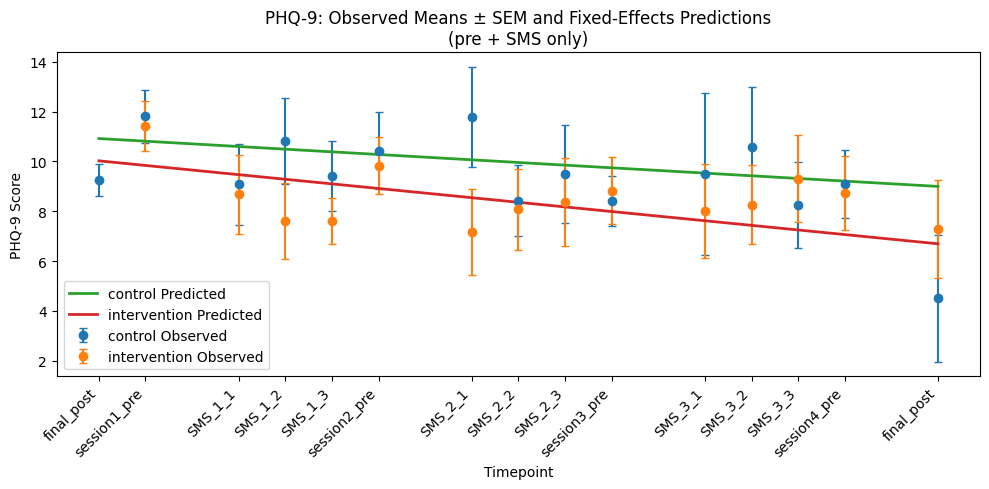

In [8]:
# 6) ORDER TIMEPOINTS & CREATE TIME VARIABLES
df_long['timepoint'] = pd.Categorical(
    df_long['timepoint'],
    categories=ordered_timepoints,
    ordered=True
)
df_long['time_num'] = df_long['timepoint'].cat.codes

# center time
df_long['tc'] = df_long['time_num'] - df_long['time_num'].mean()

# 7) EXCLUDE sessionN_post FOR THE PHQ-9 LINEAR MODEL
# (so you only model pre + SMS assessments)
mask_post = df_long['timepoint'].astype(str).str.match(r'^session\d+_post$')
df_model = df_long[~mask_post].copy()

import statsmodels.formula.api as smf

# Random‐intercepts‐only linear growth with centered time
# — right before you call smf.mixedlm —

# 1) drop any remaining rows missing your outcome / predictors
df_model = df_model.dropna(
    subset=[
        'phq9_sum',  # outcome
        'tc',        # centered time
        'condition'  # grouping / interaction
    ]
)

# 2) reset to a fresh 0..N-1 index so that row_indices line up
df_model = df_model.reset_index(drop=True)

# now fit your random-intercepts model
model0 = smf.mixedlm(
    "phq9_sum ~ tc * condition",
    data=df_model,
    groups="part_id",
    re_formula="~1"
)
res0 = model0.fit(method='lbfgs')
print(res0.summary())

import matplotlib.pyplot as plt

# 1) Observed means + SEM by condition & time_num (on df_model)
obs = (
    df_model
    .groupby(['condition','time_num'])['phq9_sum']
    .agg(['mean','sem'])
    .reset_index()
)

# 2) Fixed‐effects predictions from the random‐intercepts model
fe = res0.fe_params
mean_time = df_model['time_num'].mean()
preds = []
conds = df_model['condition'].dropna().unique()
time_vals = sorted(df_model['time_num'].unique())

for cond in conds:
    is_int = int(cond == 'intervention')
    for t in time_vals:
        tc = t - mean_time
        pred = (
            fe['Intercept']
            + fe.get('condition[T.intervention]', 0) * is_int
            + fe['tc'] * tc
            + fe.get('tc:condition[T.intervention]', 0) * tc * is_int
        )
        preds.append({'condition': cond, 'time_num': t, 'predicted': pred})

pred_df = pd.DataFrame(preds)

# 3) Plot
plt.figure(figsize=(10,5))
for cond, grp in obs.groupby('condition'):
    plt.errorbar(
        grp['time_num'], grp['mean'], yerr=grp['sem'],
        fmt='o', capsize=3, label=f"{cond} Observed"
    )
for cond in conds:
    sub = pred_df[pred_df['condition']==cond]
    plt.plot(
        sub['time_num'], sub['predicted'], '-',
        lw=2, label=f"{cond} Predicted"
    )

# xticks: only the timepoints in df_model
labels = [ordered_timepoints[i] for i in time_vals]
plt.xticks(time_vals, labels, rotation=45, ha='right')

plt.xlabel("Timepoint")
plt.ylabel("PHQ-9 Score")
plt.title("PHQ-9: Observed Means ± SEM and Fixed-Effects Predictions\n(pre + SMS only)")
plt.legend()
plt.tight_layout()
plt.show()

In [9]:
model_lin = smf.mixedlm(
    "phq9_sum ~ tc * condition",
    data=df_model,
    groups="part_id",
    re_formula="~1"   # random intercept only
)
res_lin = model_lin.fit(method='lbfgs', reml=False)
print(res_lin.summary())

                 Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      phq9_sum 
No. Observations:       353          Method:                  ML       
No. Groups:             35           Scale:                   7.5484   
Min. group size:        1            Log-Likelihood:          -914.8045
Max. group size:        15           Converged:               Yes      
Mean group size:        10.1                                           
-----------------------------------------------------------------------
                             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------
Intercept                    10.037    1.165  8.613 0.000  7.753 12.321
condition[T.intervention]    -1.538    1.582 -0.972 0.331 -4.638  1.562
tc                           -0.107    0.047 -2.260 0.024 -0.200 -0.014
tc:condition[T.intervention] -0.078    0.062 -1.255 0.209 -0.199  0.044
part_id V

Model Comparisons (Simple Linear Model 2 wins -- see BIC/AIC below for model degradation via adding quadratic term)

In [10]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf

# 1) Prepare time variables
ordered_timepoints = [
    'session1_pre','session1_post',
    'SMS_1_1','SMS_1_2','SMS_1_3',
    'session2_pre','session2_post',
    'SMS_2_1','SMS_2_2','SMS_2_3',
    'session3_pre','session3_post',
    'SMS_3_1','SMS_3_2','SMS_3_3',
    'session4_pre','session4_post',
    'final_post'
]

df_long['timepoint'] = pd.Categorical(
    df_long['timepoint'],
    categories=ordered_timepoints,
    ordered=True
)
df_long['time_num']  = df_long['timepoint'].cat.codes
df_long['time_num2'] = df_long['time_num']**2

# center time for models 2 & 3
df_long['tc'] = df_long['time_num'] - df_long['time_num'].mean()

# 2) Subset to “pre + SMS” only
mask_post = df_long['timepoint'].astype(str).str.match(r'^session\d+_post$')
df_model = (
    df_long[~mask_post]
    .dropna(subset=['phq9_sum','time_num','condition','tc'])  # remove any incomplete rows
    .reset_index(drop=True)
)
df_model['condition'] = df_model['condition'].astype('category')

# 3) Model 1: Quadratic growth with random intercepts & slopes (REML)
model1 = smf.mixedlm(
    "phq9_sum ~ time_num * condition + time_num2 * condition",
    data=df_model,
    groups="part_id",
    re_formula="~time_num"
)
res1 = model1.fit(method='lbfgs')  # default reml=True
print("\n=== Model 1: Quadratic + random slopes (REML) ===")
print(res1.summary())

# 4) Model 2: Linear growth with random intercept only (REML)
model2 = smf.mixedlm(
    "phq9_sum ~ tc * condition",
    data=df_model,
    groups="part_id",
    re_formula="~1"
)
res2 = model2.fit(method='lbfgs')  # default reml=True
print("\n=== Model 2: Linear + random intercept (REML) ===")
print(res2.summary())

# 5) Model 3: Linear growth with random intercept only (ML)
model3 = smf.mixedlm(
    "phq9_sum ~ tc * condition",
    data=df_model,
    groups="part_id",
    re_formula="~1"
)
res3 = model3.fit(method='lbfgs', reml=False)
print("\n=== Model 3: Linear + random intercept (ML) ===")
print(res3.summary())

# 6) Compare AICs (lower = better fit under ML/REML)
print(f"\nAICs:")
print(f"  Model 1 (quadratic, REML):   {res1.aic:.1f}")
print(f"  Model 2 (linear, REML):      {res2.aic:.1f}")
print(f"  Model 3 (linear, ML):        {res3.aic:.1f}")


=== Model 1: Quadratic + random slopes (REML) ===
                    Mixed Linear Model Regression Results
Model:                     MixedLM        Dependent Variable:        phq9_sum 
No. Observations:          353            Method:                    REML     
No. Groups:                35             Scale:                     5.5551   
Min. group size:           1              Log-Likelihood:            -951.8330
Max. group size:           15             Converged:                 No       
Mean group size:           10.1                                               
------------------------------------------------------------------------------
                                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------
Intercept                           11.224    1.643  6.832 0.000  8.004 14.445
condition[T.intervention]           -1.333    2.230 -0.598 0.550 -5.704  3.038
time_num              

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 51.502505
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [11]:
# ML‐based quadratic model
res_quad_ml = smf.mixedlm(
    "phq9_sum ~ time_num * condition + time_num2 * condition",
    data=df_model,
    groups="part_id",
    re_formula="~time_num"
).fit(method='lbfgs', reml=False)

# ML‐based linear model
res_lin_ml = smf.mixedlm(
    "phq9_sum ~ tc * condition",
    data=df_model,
    groups="part_id",
    re_formula="~1"
).fit(method='lbfgs', reml=False)

# Now you can pull out AIC & BIC
print("Quadratic (ML) AIC:", res_quad_ml.aic, "BIC:", res_quad_ml.bic)
print("Linear    (ML) AIC:", res_lin_ml.aic,   "BIC:", res_lin_ml.bic)

Quadratic (ML) AIC: 1897.8408664633484 BIC: 1936.5055470326813
Linear    (ML) AIC: 1841.6090833926473 BIC: 1864.807891734247


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 62.207723
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [12]:
# --- Re-fit both models under ML (reml=False) and give them the names res_lin_ml / res_quad_ml ---

# linear model (ML):
res_lin_ml = smf.mixedlm(
    "phq9_sum ~ tc * condition",
    data=df_model,
    groups="part_id",
    re_formula="~1"
).fit(method='lbfgs', reml=False)

# quadratic model (ML):
res_quad_ml = smf.mixedlm(
    "phq9_sum ~ time_num * condition + time_num2 * condition",
    data=df_model,
    groups="part_id",
    re_formula="~time_num"
).fit(method='lbfgs', reml=False)

# now you can pull out log-likelihoods:
from scipy.stats import chi2

llf_lin  = res_lin_ml.llf
llf_quad = res_quad_ml.llf

# LRT statistic:
lr_stat = 2 * (llf_quad - llf_lin)

# df difference = # of extra fixed-effect parameters in quadratic:
df_diff = res_quad_ml.k_fe - res_lin_ml.k_fe

p_val = chi2.sf(lr_stat, df_diff)

print("Likelihood‐ratio test:")
print(f"  χ² = {lr_stat:.2f}")
print(f"  df = {df_diff}")
print(f"  p  = {p_val:.3f}")

# and for completeness, print AIC/BIC
print(f"\nAIC (linear):    {res_lin_ml.aic:.2f}")
print(f"AIC (quadratic): {res_quad_ml.aic:.2f}")
print(f"BIC (linear):    {res_lin_ml.bic:.2f}")
print(f"BIC (quadratic): {res_quad_ml.bic:.2f}")


Likelihood‐ratio test:
  χ² = -48.23
  df = 2
  p  = 1.000

AIC (linear):    1841.61
AIC (quadratic): 1897.84
BIC (linear):    1864.81
BIC (quadratic): 1936.51


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 62.207723
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [13]:
import pandas as pd
import statsmodels.formula.api as smf
from scipy.stats import chi2

# 1) define your four models
model_specs = {
    'quad_REML': dict(
        formula    = "phq9_sum ~ time_num * condition + time_num2 * condition",
        re_formula = "~time_num",
        reml       = True
    ),
    'lin_REML': dict(
        formula    = "phq9_sum ~ tc * condition",
        re_formula = "~1",
        reml       = True
    ),
    'quad_ML': dict(
        formula    = "phq9_sum ~ time_num * condition + time_num2 * condition",
        re_formula = "~time_num",
        reml       = False
    ),
    'lin_ML': dict(
        formula    = "phq9_sum ~ tc * condition",
        re_formula = "~1",
        reml       = False
    ),
}

# 2) fit them all and store results
results = {}
for name, spec in model_specs.items():
    print(f"\n\n=== Fitting {name} (REML={spec['reml']}) ===")
    mod = smf.mixedlm(
        spec['formula'],
        data=df_model,
        groups="part_id",
        re_formula=spec['re_formula']
    )
    res = mod.fit(method='lbfgs', reml=spec['reml'])
    results[name] = res
    print(res.summary())

# 3) build a comparison table using the original spec to flag REML vs ML
cmp = pd.DataFrame({
    name: {
        'REML?':    spec['reml'],
        'LogLik':   results[name].llf,
        'AIC':      results[name].aic,
        'BIC':      results[name].bic,
        'n_params': len(results[name].params)
    }
    for name, spec in model_specs.items()
}).T

print("\n\n=== Model comparison ===")
print(cmp.sort_values(['REML?', 'AIC']))

# 4) ML‐based LRT: quad_ML vs lin_ML
llf_q = results['quad_ML'].llf
llf_l = results['lin_ML'].llf
lr_stat = 2 * (llf_q - llf_l)
df_diff = results['quad_ML'].k_fe - results['lin_ML'].k_fe
p_val   = chi2.sf(lr_stat, df_diff)

print(f"\nLRT (quad vs lin, ML): χ²({df_diff}) = {lr_stat:.2f}, p = {p_val:.3f}")



=== Fitting quad_REML (REML=True) ===


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 51.502505
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


                    Mixed Linear Model Regression Results
Model:                     MixedLM        Dependent Variable:        phq9_sum 
No. Observations:          353            Method:                    REML     
No. Groups:                35             Scale:                     5.5551   
Min. group size:           1              Log-Likelihood:            -951.8330
Max. group size:           15             Converged:                 No       
Mean group size:           10.1                                               
------------------------------------------------------------------------------
                                    Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------
Intercept                           11.224    1.643  6.832 0.000  8.004 14.445
condition[T.intervention]           -1.333    2.230 -0.598 0.550 -5.704  3.038
time_num                            -0.145    0.343 -0.423 0.672 -0.818  

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 62.207723
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [14]:
# assume res_quad_ml is your ML‐fit of the quadratic model
from scipy import stats

# Wald test via statsmodels
hyp = "time_num:condition[T.intervention]=0, time_num2:condition[T.intervention]=0"
print(res_quad_ml.wald_test(hyp))

<Wald test (chi2): statistic=[[1.42907637]], p-value=0.4894180799097355, df_denom=2>


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


In [15]:
# “no interaction” nested model
mod_noint = smf.mixedlm(
    "phq9_sum ~ time_num + time_num2 + condition",
    data=df_model,
    groups="part_id",
    re_formula="~time_num"
).fit(method='lbfgs', reml=False)

# likelihood‐ratio test
llf_full  = res_quad_ml.llf
llf_noint = mod_noint.llf
lr_stat   = 2*(llf_full - llf_noint)
df_diff   = res_quad_ml.k_fe - mod_noint.k_fe
p_val     = stats.chi2.sf(lr_stat, df_diff)
print(f"Joint LRT for all cond×poly terms: χ²({df_diff})={lr_stat:.2f}, p={p_val:.3f}")

Joint LRT for all cond×poly terms: χ²(2)=1.02, p=0.602


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 62.467100
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [16]:
import numpy as np

# pick a time—for example, t = max(time_num)
t0 = df_model['time_num'].max()

# linear coefficient
b1 = res_quad_ml.params['time_num:condition[T.intervention]']
# quad coefficient
b2 = res_quad_ml.params['time_num2:condition[T.intervention]']

# derivative difference
d = b1 + 2*t0*b2
print(f"Slope diff at t={t0}: {d:.3f}")
# …then get its SE via res_quad_ml.cov_params() and compute a z‐test…

Slope diff at t=17: 0.131


In [17]:
# ML‐fit partial polynomial model
res_partial = smf.mixedlm(
    "phq9_sum ~ time_num*condition + time_num2",
    data=df_model,
    groups="part_id",
    re_formula="~time_num"
).fit(method='lbfgs', reml=False)

print(res_partial.summary())

                    Mixed Linear Model Regression Results
Model:                    MixedLM        Dependent Variable:        phq9_sum 
No. Observations:         353            Method:                    ML       
No. Groups:               35             Scale:                     5.5369   
Min. group size:          1              Log-Likelihood:            -939.5022
Max. group size:          15             Converged:                 No       
Mean group size:          10.1                                               
-----------------------------------------------------------------------------
                                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------
Intercept                          11.156    1.521  7.335 0.000  8.175 14.137
condition[T.intervention]          -1.206    2.063 -0.584 0.559 -5.250  2.838
time_num                           -0.149    0.295 -0.504 0.614 -0.726  0.429
time_n

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 62.367290
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [20]:
import pandas as pd
import statsmodels.formula.api as smf
from scipy.stats import chi2

# ─── Fit three ML models ────────────────────────────────────────────────────
# 1) Linear only
mod_lin = smf.mixedlm(
    "phq9_sum ~ time_num * condition",
    data=df_model,
    groups="part_id",
    re_formula="~1"
)
res_lin = mod_lin.fit(method='lbfgs', reml=False)

# 2) Partial quadratic (common curvature, slope×cond only)
mod_part = smf.mixedlm(
    "phq9_sum ~ time_num * condition + time_num2",
    data=df_model,
    groups="part_id",
    re_formula="~time_num"
)
res_part = mod_part.fit(method='lbfgs', reml=False)

# 3) Full quadratic (both linear & quadratic × condition)
mod_full = smf.mixedlm(
    "phq9_sum ~ time_num * condition + time_num2 * condition",
    data=df_model,
    groups="part_id",
    re_formula="~time_num"
)
res_full = mod_full.fit(method='lbfgs', reml=False)

# ─── Summaries ───────────────────────────────────────────────────────────────
print("\n=== Linear ML ==="); print(res_lin.summary())
print("\n=== Partial-quadratic ML ==="); print(res_part.summary())
print("\n=== Full-quadratic ML ==="); print(res_full.summary())

# ─── Comparison table ────────────────────────────────────────────────────────
cmp = pd.DataFrame({
    'linear':       {'llf': res_lin.llf,  'AIC': res_lin.aic,  'BIC': res_lin.bic},
    'partial_quad': {'llf': res_part.llf, 'AIC': res_part.aic, 'BIC': res_part.bic},
    'full_quad':    {'llf': res_full.llf, 'AIC': res_full.aic, 'BIC': res_full.bic},
}).T
print("\n=== model comparison ===")
print(cmp)

# ─── LRT for slope×condition within the partial-quadratic model ─────────────
#    (i.e. compare partial-quad vs same model without time:cond term)
mod_noint = smf.mixedlm(
    "phq9_sum ~ time_num + time_num2 + condition",
    data=df_model,
    groups="part_id",
    re_formula="~time_num"
).fit(method='lbfgs', reml=False)

lr = 2*(res_part.llf - mod_noint.llf)
df_diff = res_part.k_fe - mod_noint.k_fe
pval = chi2.sf(lr, df_diff)

print(f"\nSlope×condition LRT (partial): χ²({df_diff}) = {lr:.2f}, p = {pval:.3f}")

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 62.367290
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization fai


=== Linear ML ===
                    Mixed Linear Model Regression Results
Model:                    MixedLM        Dependent Variable:        phq9_sum 
No. Observations:         353            Method:                    ML       
No. Groups:               35             Scale:                     7.5484   
Min. group size:          1              Log-Likelihood:            -914.8045
Max. group size:          15             Converged:                 Yes      
Mean group size:          10.1                                               
-----------------------------------------------------------------------------
                                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------
Intercept                          10.828    1.198  9.036 0.000  8.479 13.176
condition[T.intervention]          -0.962    1.633 -0.589 0.556 -4.161  2.238
time_num                           -0.107    0.047 -2.260 0.024 -

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 62.467100
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [21]:
# from your partial-quadratic fit `res_part`
coef = res_part.params['time_num:condition[T.intervention]']
se   = res_part.bse['time_num:condition[T.intervention]']
ci_lower, ci_upper = coef - 1.96*se, coef + 1.96*se
print(f"Slope diff = {coef:.3f}, 95% CI = [{ci_lower:.3f}, {ci_upper:.3f}]")

Slope diff = -0.079, 95% CI = [-0.871, 0.713]


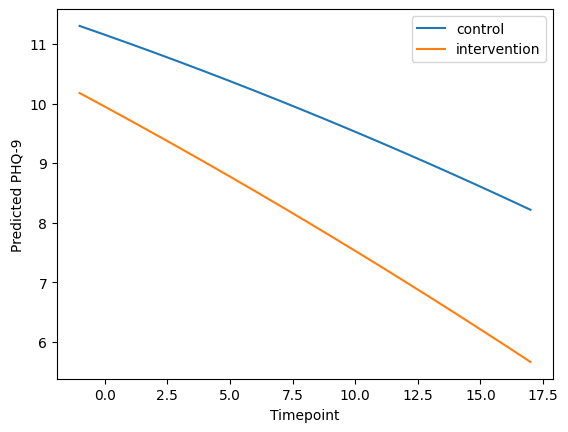

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Build prediction DataFrame
grid = np.arange(df_model['time_num'].min(), df_model['time_num'].max()+1)
pred = pd.DataFrame({
    'time_num':    np.tile(grid, 2),
    'time_num2':   np.tile(grid**2, 2),
    'condition':   ['control']*len(grid) + ['intervention']*len(grid),
    'part_id':     df_model['part_id'].iloc[0],  # dummy
})
pred['phq9'] = res_part.predict(pred)

# 2) Plot
plt.figure()
for grp, sub in pred.groupby('condition'):
    plt.plot(sub['time_num'], sub['phq9'], label=grp)
plt.xlabel('Timepoint')
plt.ylabel('Predicted PHQ-9')
plt.legend()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from tqdm import trange

def fit_slope_diff(df):
    # fit the partial-quadratic ML model
    res = smf.mixedlm(
        "phq9_sum ~ time_num * condition + time_num2",
        data=df,
        groups="part_id",
        re_formula="~time_num"
    ).fit(method='lbfgs', reml=False)
    return res.params['time_num:condition[T.intervention]']

n_boot = 2000
boot_est = np.zeros(n_boot)
part_ids = df_model['part_id'].unique()

for i in trange(n_boot):
    # resample participants with replacement
    samp_ids = np.random.choice(part_ids, size=len(part_ids), replace=True)
    df_boot = pd.concat([df_model[df_model.part_id==pid] for pid in samp_ids], ignore_index=True)
    boot_est[i] = fit_slope_diff(df_boot)

# bootstrap percentile 95% CI
ci_lower, ci_upper = np.percentile(boot_est, [2.5, 97.5])
print(f"Bootstrap slope×cond diff 95% CI: [{ci_lower:.3f}, {ci_upper:.3f}]")

# density or histogram
import matplotlib.pyplot as plt
plt.hist(boot_est, bins=30, density=True)
plt.axvline(ci_lower, color='k', linestyle='--')
plt.axvline(ci_upper, color='k', linestyle='--')
plt.xlabel("Slope Diff"); plt.title("Bootstrap Distribution")
plt.show()

In [ ]:
# install Bayesian stuff

# the “%” magic ensures it installs into the current kernel
%pip install pymc3 arviz

# install the missing Debian packages
!apt-get update -qq
!apt-get install -y -qq python3-distutils libopenblas-dev liblapack-dev
# then install PyMC3/Aesara via pip
%pip install pymc3 arviz

In [ ]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az

# --- prepare your data arrays ---
y        = df_model['phq9_sum'].values
time     = df_model['time_num'].values
time2    = df_model['time_num2'].values
cond     = (df_model['condition']=='intervention').astype(int).values
pid, pid_idx = np.unique(df_model['part_id'], return_inverse=True)
n_pat    = len(pid)

with pm.Model() as partial_quad:

    # Hyperpriors for random effects (independent)
    σ_a = pm.HalfNormal('σ_a', sigma=5)         # intercept SD
    σ_b = pm.HalfNormal('σ_b', sigma=1)         # slope SD

    # Subject-level effects
    a = pm.Normal('a', mu=0, sigma=σ_a, shape=n_pat)    # random intercept
    b = pm.Normal('b', mu=0, sigma=σ_b, shape=n_pat)    # random linear slope

    # Fixed effects
    intercept  = pm.Normal('Intercept',     mu=10, sigma=5)
    b_time     = pm.Normal('b_time',        mu=-0.1, sigma=0.1)
    b_time2    = pm.Normal('b_time2',       mu= 0.0, sigma=0.05)
    b_cond     = pm.Normal('b_cond',        mu= 0.0, sigma=5)
    b_time_c   = pm.Normal('b_time:cond',   mu= 0.0, sigma=0.1)
    # no quadratic×cond in partial-quadratic:
    b_time2_c  = pm.ConstantData('b_time2:cond', 0.0)

    # Linear predictor
    μ = (
        intercept
        + a[pid_idx]
        + (b_time + b[pid_idx])*time
        + b_time2*time2
        + b_cond*cond
        + b_time_c*time*cond
        + b_time2_c*time2*cond
    )

    # Residual SD
    σ_y = pm.HalfNormal('σ_y', sigma=5)

    # Likelihood
    y_obs = pm.Normal('y_obs', mu=μ, sigma=σ_y, observed=y)

    # Sample
    trace = pm.sample(2000, tune=2000, target_accept=0.9)

# --- Summarize slope×condition posterior ---
az.plot_posterior(trace, var_names=['b_time:cond'], hdi_prob=0.95)
print(az.summary(trace, var_names=['b_time:cond']))
print("P(b_time:cond < 0) =",
      np.mean(trace.posterior['b_time:cond'].values < 0))

In [ ]:
from scipy.stats import gaussian_kde
import numpy as np

post = trace.posterior['b_time:cond'].values.flatten()
# P(effect < –0.05)
print("P(b_time:cond < –0.05) =", np.mean(post < -0.05))
# P(effect within ±0.05)
print("P(|b_time:cond| < 0.05) =", np.mean(np.abs(post) < 0.05))

kde = gaussian_kde(post)
posterior_density_at_zero = kde(0)[0]
# prior for b_time:cond was Normal(0,0.1), so its density at zero is:
prior_density_at_zero = 1/(0.1 * np.sqrt(2*np.pi))
BF10 = prior_density_at_zero / posterior_density_at_zero
print("BF₁₀ (neg effect vs. null) ≈", BF10)

P(b_time:cond < –0.05) = 0.68675
P(|b_time:cond| < 0.05) = 0.2865
BF₁₀ (neg effect vs. null) ≈ 1.30767203639337


In [ ]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

# ── 0) PREPARE YOUR DATA ────────────────────────────────────────────────
# (Assumes you already have df_model from the frequentist pipeline.)
y        = df_model['phq9_sum'].values
time     = df_model['time_num'].values
cond     = (df_model['condition'] == 'intervention').astype(int).values
pid_ids, pid_idx = np.unique(df_model['part_id'], return_inverse=True)
n_pat    = len(pid_ids)

# ── 1) BUILD & SAMPLE THE BAYESIAN LINEAR GROWTH MODEL ─────────────────
with pm.Model() as linear_growth:

    # Hyperprior for subject‐level intercept SD
    σ_a = pm.HalfNormal('σ_a', sigma=5)

    # Random intercepts for each participant
    a = pm.Normal('a', mu=0, sigma=σ_a, shape=n_pat)

    # Fixed effects
    intercept  = pm.Normal('Intercept', mu=10, sigma=5)
    b_time     = pm.Normal('b_time',      mu=-0.1,  sigma=0.1)
    b_cond     = pm.Normal('b_cond',      mu= 0.0,  sigma=5)
    b_time_c   = pm.Normal('b_time:cond', mu= 0.0,  sigma=0.1)

    # Residual error
    σ_y = pm.HalfNormal('σ_y', sigma=5)

    # Linear predictor
    μ = (
        intercept
        + a[pid_idx]
        + b_time * time
        + b_cond * cond
        + b_time_c * time * cond
    )

    # Likelihood
    y_obs = pm.Normal('y_obs', mu=μ, sigma=σ_y, observed=y)

    # Sample from the posterior
    trace = pm.sample(2000, tune=2000, target_accept=0.9, return_inferencedata=True)

# ── 2) POSTERIOR SUMMARY & PLOT INTERACTION ────────────────────────────
# Posterior summary for the time×condition effect:
print(az.summary(trace, var_names=['b_time:cond'], hdi_prob=0.95))

# Plot its full posterior density:
az.plot_posterior(trace, var_names=['b_time:cond'], hdi_prob=0.95,
                  ref_val=0, textsize=12)
plt.title("Posterior of time × condition interaction")
plt.show()

# ── 3) PLOT PREDICTED TRAJECTORIES WITH 95% CREDIBLE BANDS ────────────
# 3a) Construct a grid of times and both conditions
time_grid = np.unique(time)
cond_grid = [0, 1]
preds = []

# Extract posterior samples into arrays
post = trace.posterior
n_samps = post.sizes['chain'] * post.sizes['draw']

# Flatten chains & draws
b0_samps   = post['Intercept'].stack(samp=('chain','draw')).values
b_time_samps = post['b_time'].stack(samp=('chain','draw')).values
b_cond_samps = post['b_cond'].stack(samp=('chain','draw')).values
b_tc_samps   = post['b_time:cond'].stack(samp=('chain','draw')).values

for t in time_grid:
    for c in cond_grid:
        # compute μ for each posterior sample
        mu_samps = (
            b0_samps
            + b_time_samps * t
            + b_cond_samps * c
            + b_tc_samps * (t * c)
        )
        # summarize
        median = np.median(mu_samps)
        hdi    = az.hdi(mu_samps, hdi_prob=0.95)
        preds.append({'time_num': t,
                      'cond': 'intervention' if c==1 else 'control',
                      'median': median,
                      'hdi_lower': hdi[0],
                      'hdi_upper': hdi[1]})

pred_df = pd.DataFrame(preds)

# 3b) observed means + SEM
obs = (
    df_model
    .groupby(['condition','time_num'])['phq9_sum']
    .agg(['mean','sem'])
    .reset_index()
)

# 3c) plot
plt.figure(figsize=(10,6))

# observed
for cond, grp in obs.groupby('condition'):
    plt.errorbar(grp['time_num'], grp['mean'], yerr=grp['sem'],
                 fmt='o', capsize=3, label=f"{cond.capitalize()} Observed")

# predicted with credible bands
for cond in ['control','intervention']:
    sub = pred_df[pred_df['cond']==cond]
    x = sub['time_num']
    plt.plot(x, sub['median'], '-', lw=2, label=f"{cond.capitalize()} Predicted")
    plt.fill_between(x, sub['hdi_lower'], sub['hdi_upper'], alpha=0.2)

# xticks labels
labels = [ordered_timepoints[i] for i in time_grid]
plt.xticks(time_grid, labels, rotation=45, ha='right')

plt.xlabel("Timepoint")
plt.ylabel("PHQ-9 Score")
plt.title("Bayesian Linear Growth Model\nPHQ‑9 Trajectory by Condition (pre + SMS only)")
plt.legend()
plt.tight_layout()
plt.show()

Future P(< 0)           = 0.9996
Future P(< –0.05)       = 0.9939
Future P(|effect|<0.05) = 0.0061


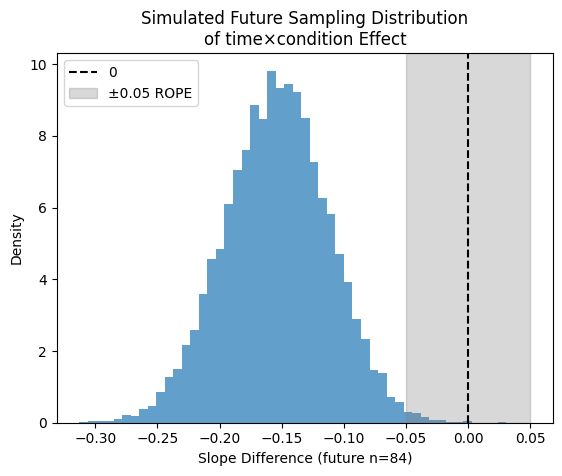

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Pull out the estimate and its SE from your fitted model (res0)
beta_hat = res0.params['tc:condition[T.intervention]']
se_hat   = res0.bse['tc:condition[T.intervention]']

# current effective sample size: number of subjects
n_current = df_model['part_id'].nunique()

# choose the future N you care about
n_future = 84

# 2) Scale the SE to the future N
#    Var(β̂) ∝ 1/N, so SE_future = SE_current * sqrt(N_current/N_future)
sd_future = se_hat * np.sqrt(n_current / n_future)

# 3) simulate 10 000 “future” estimates
sim = np.random.normal(loc=beta_hat, scale=sd_future, size=10_000)

# 4) compute the quantities you care about
print("Future P(< 0)           =", np.mean(sim < 0))
print("Future P(< –0.05)       =", np.mean(sim < -0.05))
print("Future P(|effect|<0.05) =", np.mean(np.abs(sim) < 0.05))

# 5) visualize
plt.hist(sim, bins=50, density=True, alpha=0.7)
plt.axvline(0, color='k', linestyle='--', label="0")
plt.axvspan(-0.05, +0.05, color='gray', alpha=0.3, label="±0.05 ROPE")
plt.legend()
plt.xlabel("Slope Difference (future n=84)")
plt.ylabel("Density")
plt.title("Simulated Future Sampling Distribution\nof time×condition Effect")
plt.show()

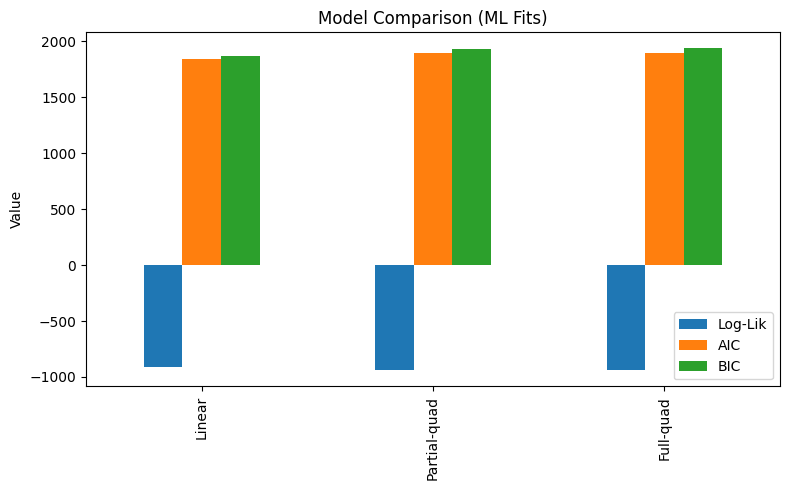

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Collect the metrics
model_names = ['Linear', 'Partial-quad', 'Full-quad']
llf  = [res_lin.llf,  res_part.llf,  res_full.llf]
aic  = [res_lin.aic,  res_part.aic,  res_full.aic]
bic  = [res_lin.bic,  res_part.bic,  res_full.bic]

df_metrics = pd.DataFrame({
    'Log-Lik': llf,
    'AIC':     aic,
    'BIC':     bic
}, index=model_names)

# 2. Plot grouped bar chart
ax = df_metrics.plot(kind='bar', figsize=(8,5))
ax.set_ylabel('Value')
ax.set_title('Model Comparison (ML Fits)')
ax.legend(loc='best')
plt.tight_layout()
plt.show()

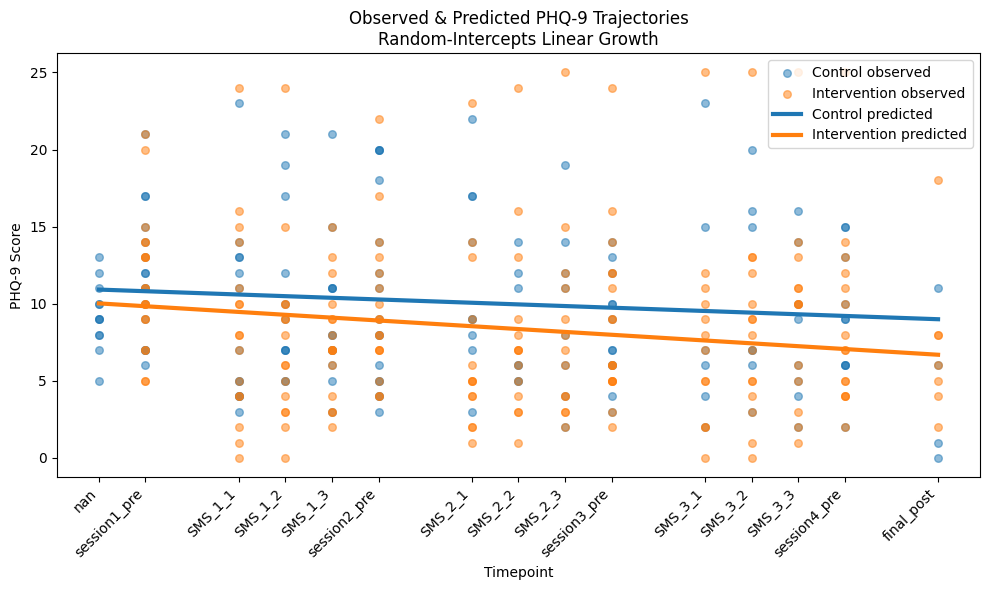

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ── ASSUMPTION: you’ve already fit your linear mixedlm and named the result `res0`,
# and you have your analysis DataFrame `df_model` with columns ['time_num','phq9_sum','condition','part_id'].

# 1) Use only the time_nums actually in your analysis set
time_vals = sorted(df_model['time_num'].unique())

# 2) Build the prediction grid from those
pred_df = pd.DataFrame({
    'time_num':  np.tile(time_vals, 2),
    'condition': ['control']*len(time_vals) + ['intervention']*len(time_vals),
    'part_id':   df_model['part_id'].iloc[0]
})
# recompute tc
pred_df['tc'] = pred_df['time_num'] - df_model['time_num'].mean()
pred_df['phq9_pred'] = res0.predict(pred_df)

# 3) Plot
fig, ax = plt.subplots(figsize=(10,6))
colors = {'control':'tab:blue','intervention':'tab:orange'}

# (a) Observed scatter
for cond, grp in df_model.groupby('condition', observed=True):
    ax.scatter(grp['time_num'], grp['phq9_sum'],
               color=colors[cond], alpha=0.5, s=30,
               label=f"{cond.capitalize()} observed")

# (b) Fitted lines
for cond in ['control','intervention']:
    sub = pred_df[pred_df['condition']==cond]
    ax.plot(sub['time_num'], sub['phq9_pred'],
            color=colors[cond], lw=3,
            label=f"{cond.capitalize()} predicted")

# (c) X‐ticks from the *actual* time_vals and their labels
label_map = (
    df_model[['time_num','timepoint']]
    .drop_duplicates()
    .set_index('time_num')['timepoint']
    .to_dict()
)
ax.set_xticks(time_vals)
ax.set_xticklabels([label_map[t] for t in time_vals],
                   rotation=45, ha='right')

ax.set_xlabel("Timepoint")
ax.set_ylabel("PHQ‑9 Score")
ax.set_title("Observed & Predicted PHQ‑9 Trajectories\nRandom‑Intercepts Linear Growth")
ax.legend()
plt.tight_layout()
plt.show()

/tmp/ipython-input-24-2855758623.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for cond, df_sub in df_model.groupby('condition'):


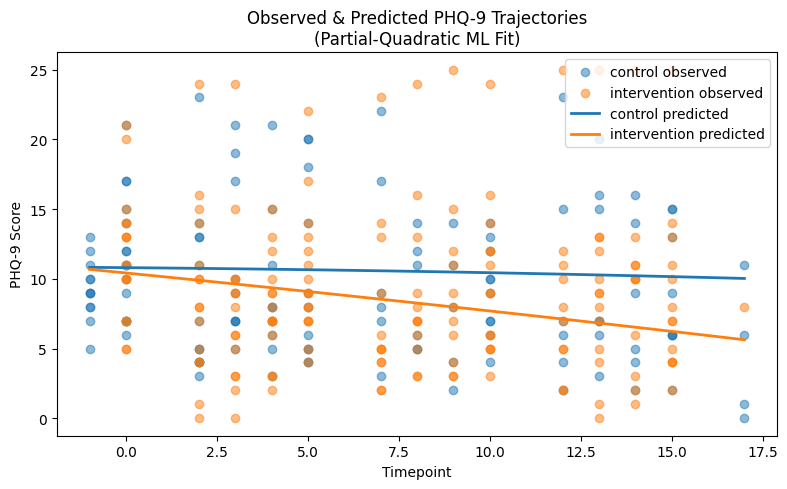

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 1. Build a prediction grid
time_grid = np.arange(df_model['time_num'].min(),
                      df_model['time_num'].max()+1)

pred_df = pd.DataFrame({
    'time_num':  np.tile(time_grid, 2),
    'time_num2': np.tile(time_grid**2, 2),
    'condition': ['control']*len(time_grid) + ['intervention']*len(time_grid),
    # part_id just needs to be present; we use the first ID as a placeholder
    'part_id':   df_model['part_id'].iloc[0]
})

# 2. Generate predictions
pred_df['phq9_pred'] = res_part.predict(pred_df)

# 3. Plot
fig, ax = plt.subplots(figsize=(8,5))
colors = {'control':'tab:blue', 'intervention':'tab:orange'}

# scatter raw observations
for cond, df_sub in df_model.groupby('condition'):
    ax.scatter(df_sub['time_num'], df_sub['phq9_sum'],
               color=colors[cond], alpha=0.5, label=f'{cond} observed')

# plot fitted curves
for cond in ['control','intervention']:
    df_sub = pred_df[pred_df['condition']==cond]
    ax.plot(df_sub['time_num'], df_sub['phq9_pred'],
            color=colors[cond], lw=2, label=f'{cond} predicted')

ax.set_xlabel('Timepoint')
ax.set_ylabel('PHQ-9 Score')
ax.set_title('Observed & Predicted PHQ-9 Trajectories\n(Partial-Quadratic ML Fit)')
ax.legend()
plt.tight_layout()
plt.show()

FINAL MODEL TWO (Linear REML)

In [27]:
import statsmodels.formula.api as smf

# (Re)fit the final linear REML model
final_model = smf.mixedlm(
    "phq9_sum ~ tc * condition",
    data=df_model,
    groups="part_id",
    re_formula="~1"
).fit(method='lbfgs')  # default reml=True

print(final_model.summary())

                 Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      phq9_sum 
No. Observations:       353          Method:                  REML     
No. Groups:             35           Scale:                   7.5964   
Min. group size:        1            Log-Likelihood:          -917.1457
Max. group size:        15           Converged:               Yes      
Mean group size:        10.1                                           
-----------------------------------------------------------------------
                             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------
Intercept                    10.038    1.200  8.366 0.000  7.686 12.390
condition[T.intervention]    -1.541    1.629 -0.946 0.344 -4.733  1.651
tc                           -0.107    0.047 -2.251 0.024 -0.200 -0.014
tc:condition[T.intervention] -0.078    0.062 -1.257 0.209 -0.200  0.044
part_id V

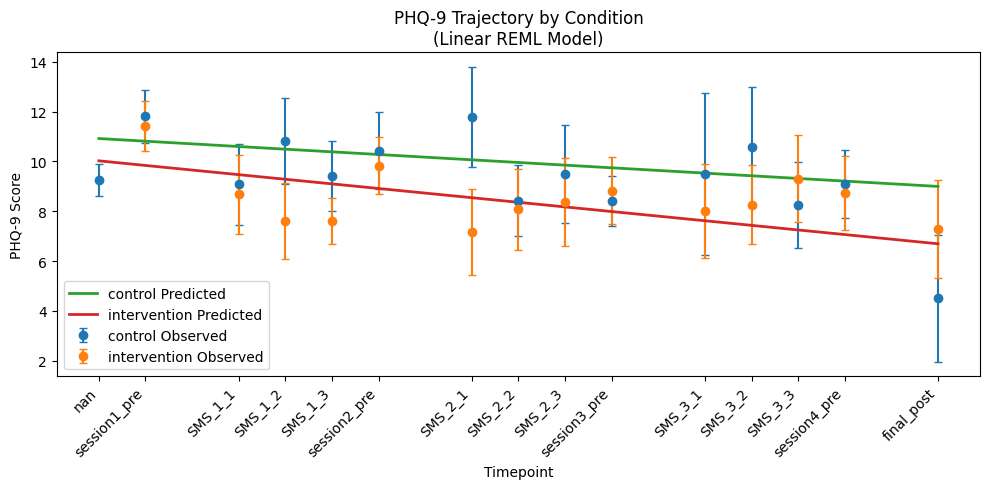

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Observed means ± SEM, silencing the warning
obs = (
    df_model
    .groupby(['condition','time_num'], observed=True)['phq9_sum']
    .agg(['mean','sem'])
    .reset_index()
)

# 2) Build fixed-effects predictions
fe        = final_model.fe_params
time_vals = sorted(df_model['time_num'].unique())
mean_t    = df_model['time_num'].mean()
conds     = df_model['condition'].cat.categories

preds = []
for cond in conds:
    is_int = int(cond == 'intervention')
    for t in time_vals:
        tc   = t - mean_t
        pred = (
            fe['Intercept']
            + fe.get(f'condition[T.{cond}]', 0) * is_int
            + fe['tc'] * tc
            + fe.get('tc:condition[T.intervention]', 0) * tc * is_int
        )
        preds.append({'condition': cond, 'time_num': t, 'predicted': pred})

pred_df = pd.DataFrame(preds)

# 3) Dynamically map time_num → label
label_map = (
    df_model[['time_num','timepoint']]
    .drop_duplicates()
    .set_index('time_num')['timepoint']
    .to_dict()
)
labels = [label_map[t] for t in time_vals]

# 4) Plot observed ± SEM and model fits
plt.figure(figsize=(10,5))

# Observed
for cond, grp in obs.groupby('condition', observed=True):
    plt.errorbar(
        grp['time_num'], grp['mean'], yerr=grp['sem'],
        fmt='o', capsize=3, label=f"{cond} Observed"
    )

# Predicted
for cond in conds:
    sub = pred_df[pred_df['condition']==cond]
    plt.plot(
        sub['time_num'], sub['predicted'], '-',
        lw=2, label=f"{cond} Predicted"
    )

plt.xticks(time_vals, labels, rotation=45, ha='right')
plt.xlabel("Timepoint")
plt.ylabel("PHQ-9 Score")
plt.title("PHQ-9 Trajectory by Condition\n(Linear REML Model)")
plt.legend()
plt.tight_layout()
plt.show()

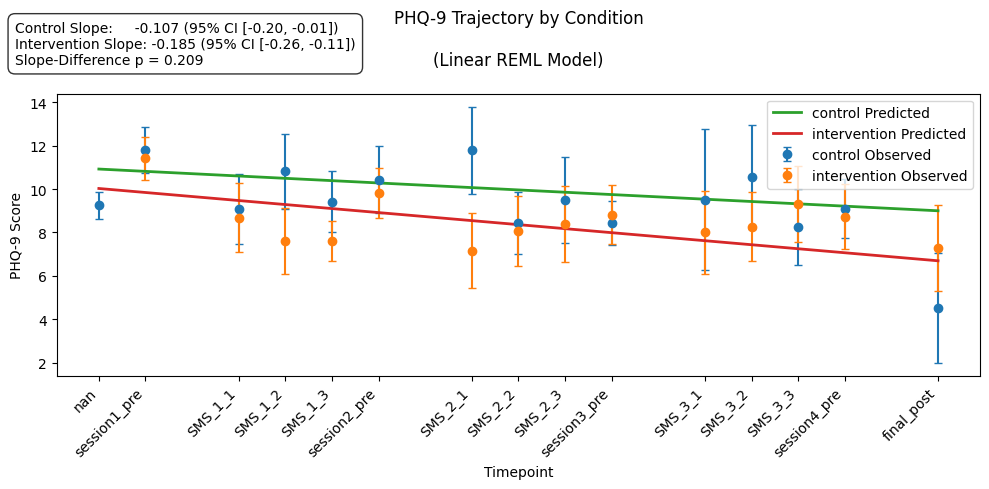

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# ─── 1) EXTRACT FIXED‐EFFECTS & COVARIANCE ─────────────────────────────
params = final_model.fe_params
vcov   = final_model.cov_params()

# control slope & SE
s_ctrl = params['tc']
se_ctrl = np.sqrt(vcov.loc['tc','tc'])

# intervention slope & SE (s_ctrl + delta)
delta = params['tc:condition[T.intervention]']
var_delta = vcov.loc['tc:condition[T.intervention]','tc:condition[T.intervention]']
covar = vcov.loc['tc','tc:condition[T.intervention]']
se_int = np.sqrt(se_ctrl**2 + var_delta + 2*covar)
s_int = s_ctrl + delta

# 95% CIs
z = norm.ppf(0.975)
ci_ctrl = (s_ctrl - z*se_ctrl, s_ctrl + z*se_ctrl)
ci_int  = (s_int  - z*se_int,  s_int  + z*se_int)

# p‐value for slope difference = p of the interaction
p_diff = final_model.pvalues['tc:condition[T.intervention]']

# ─── 2) COMPUTE PREDICTED OBS + FIT ────────────────────────────────────
# (this is your plotting data from before)
# obs  = ...   # dataframe with ['condition','time_num','mean','sem']
# pred_df = ... # dataframe with ['condition','time_num','predicted']
time_vals = sorted(df_model['time_num'].unique())

# ─── 3) COMPUTE TIMEPOINT‐WISE SIGNIFICANCE OF GAP ────────────────────
# for each t, gap = pred_int - pred_ctrl; its se via delta‐method
# pre‐compute var(beta_cond), var(delta), cov(beta_cond,delta)
vc_b  = vcov.loc['condition[T.intervention]','condition[T.intervention]']
cov_b_d = vcov.loc['condition[T.intervention]','tc:condition[T.intervention]']

gaps, ses, sig = [], [], []
for t in time_vals:
    tc = t - df_model['time_num'].mean()
    # gap = condition main effect + tc×condition effect
    gap = params['condition[T.intervention]'] + delta * tc
    var_gap = vc_b + (tc**2)*var_delta + 2*tc*cov_b_d
    se_gap = np.sqrt(var_gap)
    gaps.append(gap); ses.append(se_gap)
    sig.append(abs(gap) > z*se_gap)

# ─── 4) PLOTTING ───────────────────────────────────────────────────────
plt.figure(figsize=(10,5))

# observed
for cond, grp in obs.groupby('condition', observed=True):
    plt.errorbar(grp['time_num'], grp['mean'], yerr=grp['sem'],
                 fmt='o', capsize=3, label=f"{cond} Observed")

# predicted
for cond in pred_df['condition'].unique():
    sub = pred_df[pred_df['condition']==cond]
    plt.plot(sub['time_num'], sub['predicted'], '-', lw=2,
             label=f"{cond} Predicted")

# annotate significant gaps
ymax = max(pred_df['predicted']) + 0.5
for t, is_sig in zip(time_vals, sig):
    if is_sig:
        plt.text(t, ymax, '*', ha='center', va='bottom', fontsize=14)

# add slope‐text box
txt = (
    f"Control Slope:     {s_ctrl:.3f} "
    f"(95% CI [{ci_ctrl[0]:.2f}, {ci_ctrl[1]:.2f}])\n"
    f"Intervention Slope: {s_int:.3f} "
    f"(95% CI [{ci_int[0]:.2f}, {ci_int[1]:.2f}])\n"
    f"Slope‐Difference p = {p_diff:.3f}"
)
plt.gcf().text(0.02, 0.86, txt, fontsize=10,
               bbox=dict(boxstyle="round,pad=0.5", facecolor="white", alpha=0.8))

# finalize axes
label_map = (
    df_model[['time_num','timepoint']]
    .drop_duplicates()
    .set_index('time_num')['timepoint']
    .to_dict()
)
plt.xticks(time_vals, [label_map[t] for t in time_vals],
           rotation=45, ha='right')
plt.xlabel("Timepoint")
plt.ylabel("PHQ-9 Score")
plt.title("PHQ-9 Trajectory by Condition\n\n(Linear REML Model)\n")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

Loaded 'pre_session_1' from wp2_pre_session_1_July 29, 2025_08.55.csv
Loaded 'pre_sessions_2-4' from wp2_pre_sessions_2-4_July 29, 2025_08.55.csv
Loaded 'post_sessions_1-3' from wp2_post_sessions_1-3_July 29, 2025_08.55.csv
Loaded 'post_session_4' from wp2_post_session_4_July 29, 2025_08.56.csv
Loaded 'sms_day1,3,5' from wp2_sms_day1,3,5_July 29, 2025_08.55.csv
Trimmed df_sms.part_id to first 5 characters
Loaded 'sms_post' from wp2_sms_post_July 29, 2025_08.54.csv
Loaded 'wp2_assignments' from wp2_assignments.csv


/tmp/ipython-input-30-2377877828.py:333: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['timepoint','condition'])[measure]


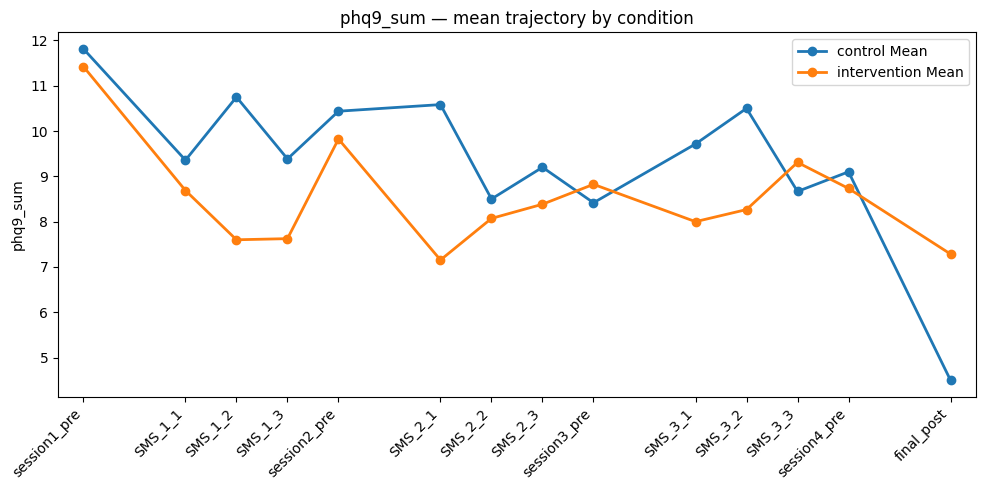

/tmp/ipython-input-30-2377877828.py:333: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['timepoint','condition'])[measure]


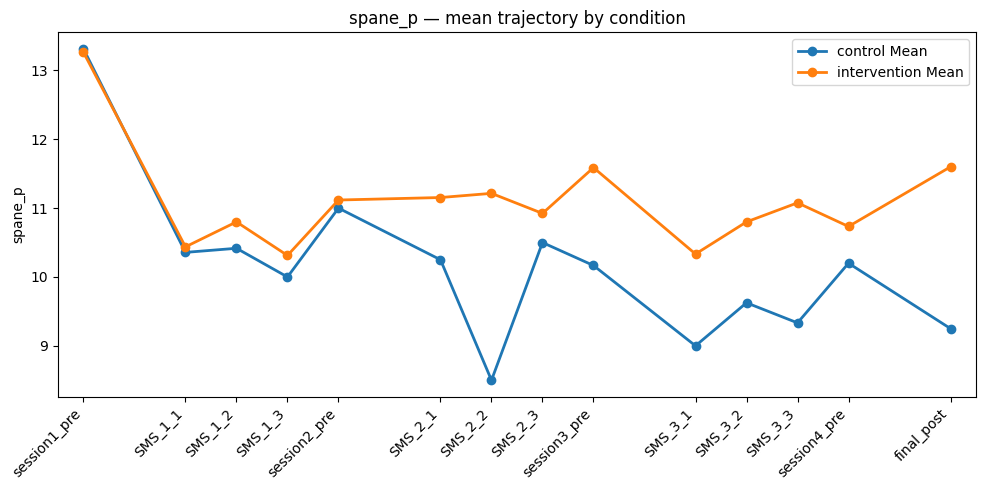

/tmp/ipython-input-30-2377877828.py:333: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['timepoint','condition'])[measure]


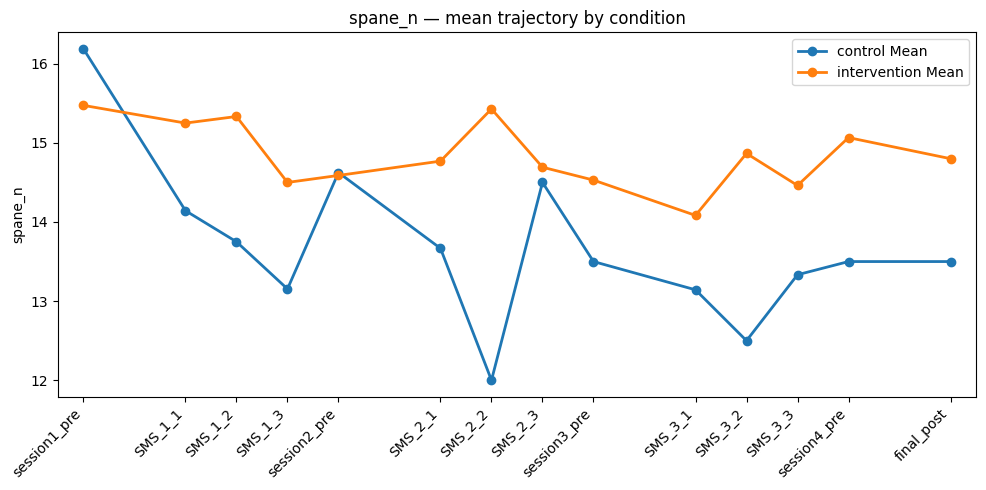

/tmp/ipython-input-30-2377877828.py:333: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['timepoint','condition'])[measure]


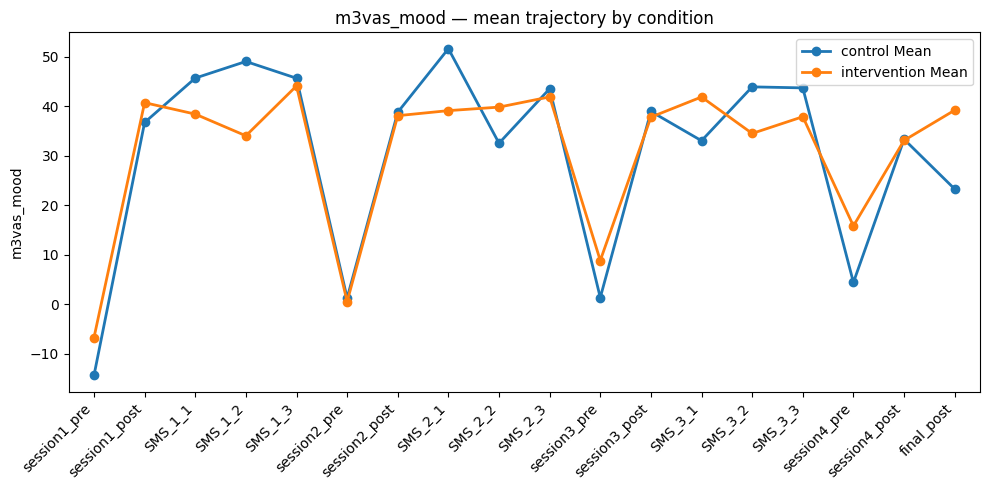

/tmp/ipython-input-30-2377877828.py:333: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['timepoint','condition'])[measure]


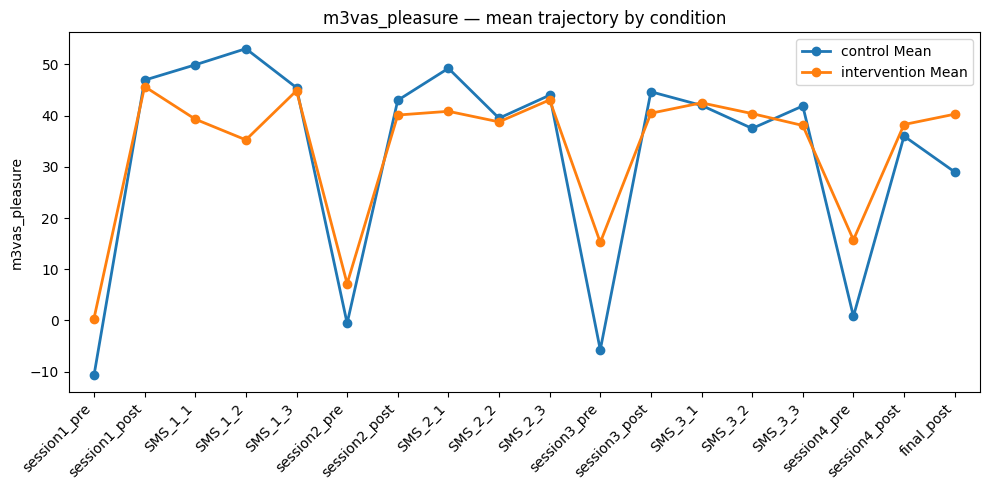

/tmp/ipython-input-30-2377877828.py:333: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['timepoint','condition'])[measure]


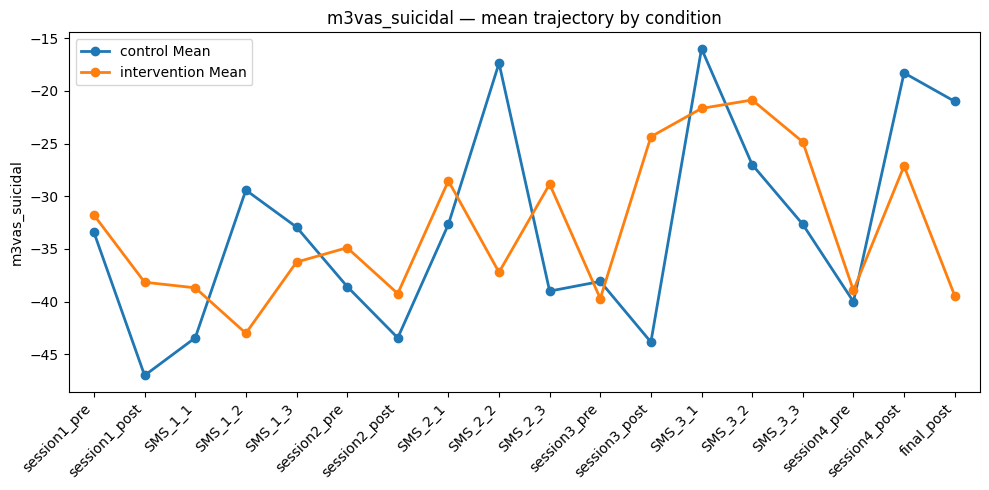

/tmp/ipython-input-30-2377877828.py:333: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['timepoint','condition'])[measure]


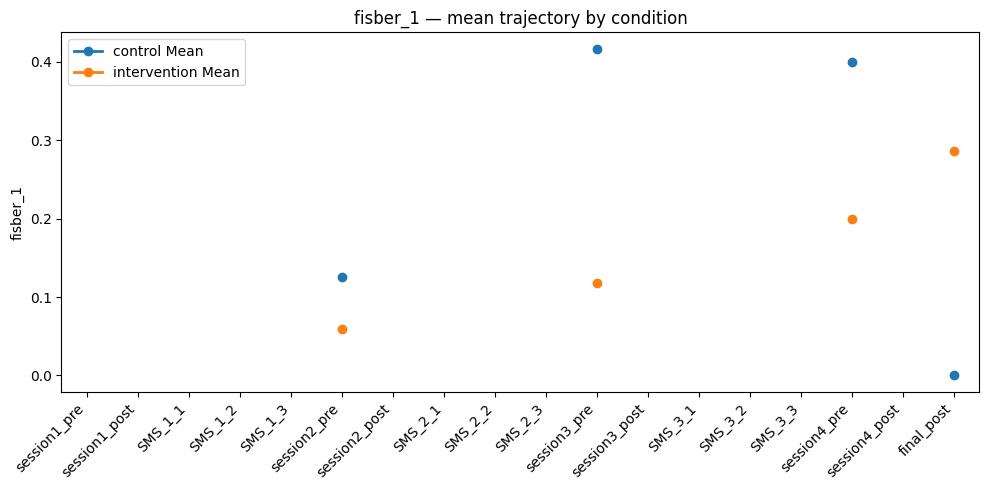

/tmp/ipython-input-30-2377877828.py:333: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['timepoint','condition'])[measure]


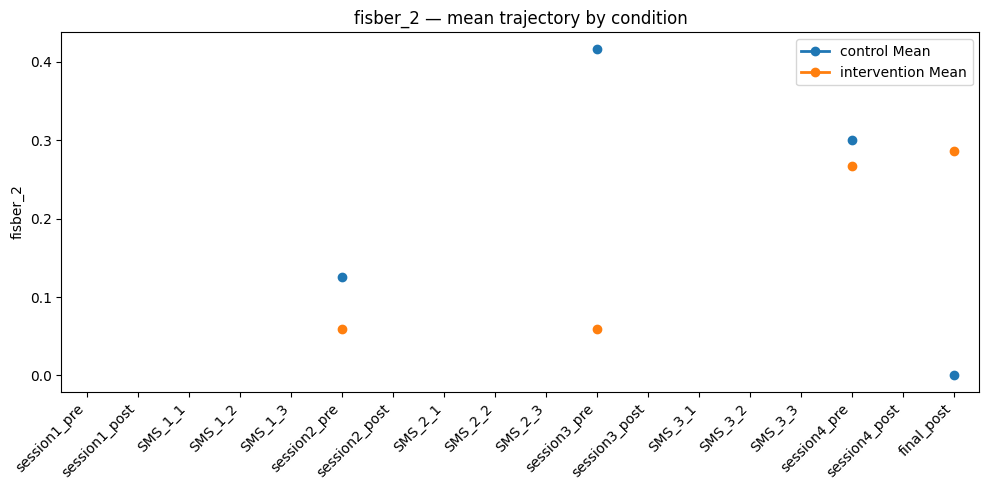

/tmp/ipython-input-30-2377877828.py:333: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['timepoint','condition'])[measure]


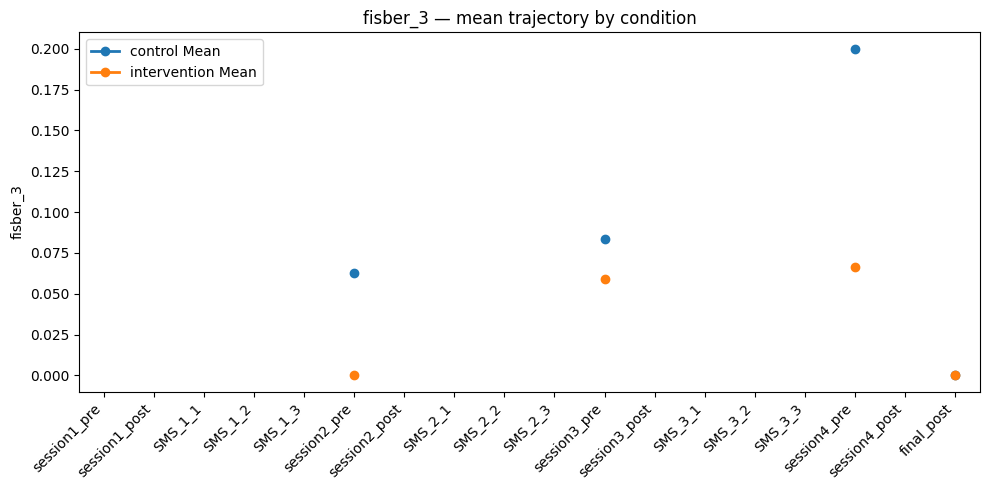

/tmp/ipython-input-30-2377877828.py:333: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['timepoint','condition'])[measure]


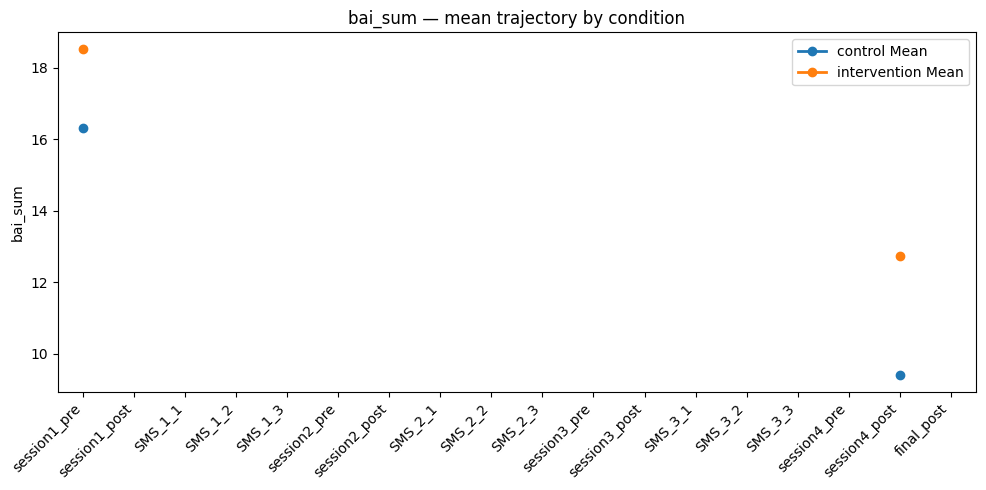

/tmp/ipython-input-30-2377877828.py:333: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['timepoint','condition'])[measure]


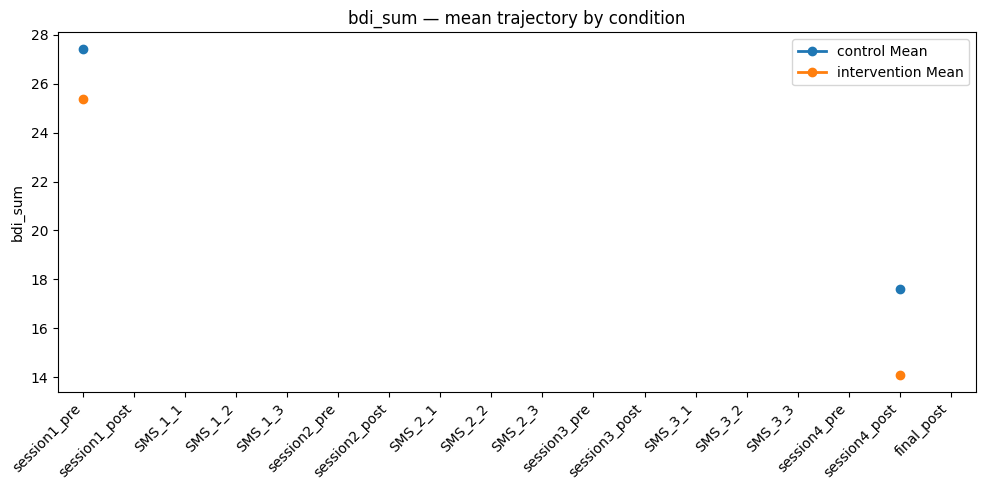

/tmp/ipython-input-30-2377877828.py:333: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['timepoint','condition'])[measure]


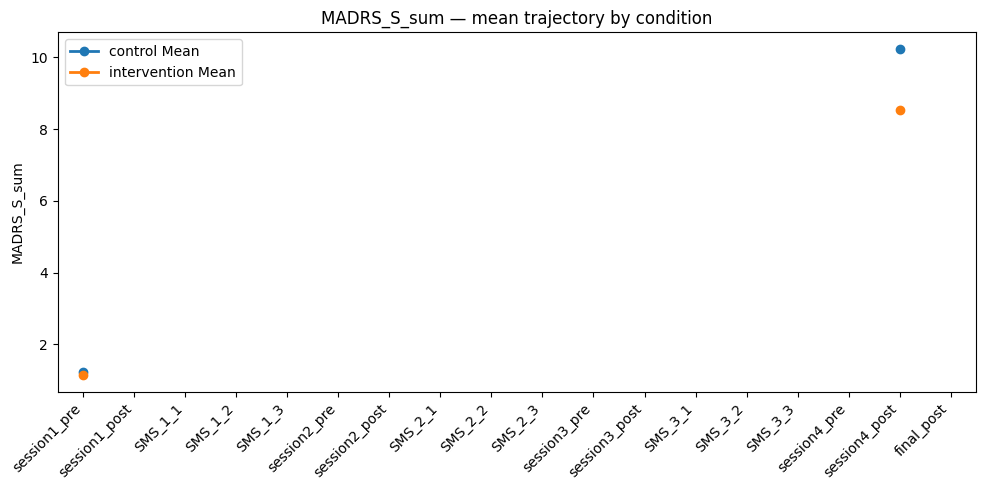

In [30]:
import re
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

#####
# 0) SETTINGS
#####
DATA_DIR = Path('/content')

#####
# 1) UTILITY TO FIND EXACTLY ONE CSV
#####
def find_csv(substring: str) -> Path:
    matches = list(DATA_DIR.glob(f'*{substring}*.csv'))
    if not matches:
        raise FileNotFoundError(f"No file matching '{substring}' in {DATA_DIR}")
    if len(matches) > 1:
        raise ValueError(f"Multiple files match '{substring}': {matches}")
    return matches[0]

#####
# 1b) TRY TO LOAD A CSV, BUT SKIP IF MISSING OR AMBIGUOUS
#####
def try_load(substring: str) -> pd.DataFrame | None:
    try:
        path = find_csv(substring)
    except (FileNotFoundError, ValueError) as e:
        print(f"Skipping '{substring}': {e}")
        return None
    print(f"Loaded '{substring}' from {path.name}")
    return pd.read_csv(path, dtype=str)

#####
# 2) LOAD ALL WELLBEING CSVS (skipping any that aren’t there yet)
#####
df_s1_pre     = try_load('pre_session_1')
df_s2to4_pre  = try_load('pre_sessions_2-4')
df_s2to4_post = try_load('post_sessions_1-3')
df_s4_post    = try_load('post_session_4')
df_sms        = try_load('sms_day1,3,5')

#  — new step: trim SMS part_ids —
if df_sms is not None:
    df_sms['part_id'] = (
        df_sms['part_id']
              .astype(str)
              .str.strip()
              .str[:5]
    )
    print("Trimmed df_sms.part_id to first 5 characters")

df_final      = try_load('sms_post')

# Collect only the ones that actually loaded
all_dfs = [df for df in (
    df_s1_pre,
    df_s2to4_pre,
    df_s2to4_post,
    df_s4_post,
    df_sms,
    df_final
) if df is not None]

if not all_dfs:
    raise RuntimeError("No data files found to process!")

#####
# 3) CLEAN BDI ITEMS (extract leading number)
#####
for df in all_dfs:
    bdi_raw = [c for c in df.columns if re.fullmatch(r"bdi_\d+(?:_1)?", c)]
    for col in bdi_raw:
        df[col] = (
            df[col].astype(str)
                  .str.extract(r'^(\d+)')[0]
                  .astype(float)
        )

#####
# 4) SUM SCALES
#####
def sum_scale(df, cols, new_col):
    df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')
    df[new_col] = df[cols].sum(axis=1)

def get_scale_cols(df, prefix, count, allow_suffix=False):
    cols = []
    for i in range(1, count+1):
        main = f"{prefix}_{i}"
        alt  = f"{prefix}_{i}_1"
        if main in df.columns:
            cols.append(main)
        elif allow_suffix and alt in df.columns:
            cols.append(alt)
    return cols

for df in all_dfs:
    # BAI
    bai_cols = get_scale_cols(df, 'bai', 21)
    if bai_cols:
        sum_scale(df, bai_cols, 'bai_sum')
    # BDI
    bdi_cols = get_scale_cols(df, 'bdi', 21)
    if bdi_cols:
        sum_scale(df, bdi_cols, 'bdi_sum')
    # MADRS
    madrs_cols = get_scale_cols(df, 'madrs', 9, allow_suffix=True)
    if madrs_cols:
        sum_scale(df, madrs_cols, 'MADRS_S_sum')

#####
# 5) STANDARDIZE M3VAS
#####
def standardize_m3vas(df):
    to_drop = []
    for var in ('suicidal','mood','pleasure'):
        # find change‐score first, then raw‐score
        ch_col  = next((c for c in df.columns
                        if re.fullmatch(rf"m3vas_ch_{var}(?:_1)?", c)), None)
        raw_col = next((c for c in df.columns
                        if re.fullmatch(rf"m3vas_{var}(?:_1)?",    c)), None)

        if ch_col:
            vals = pd.to_numeric(df[ch_col], errors='coerce') - 50
            to_drop.append(ch_col)
        elif raw_col:
            vals = pd.to_numeric(df[raw_col], errors='coerce') - 50
            to_drop.append(raw_col)
        else:
            continue

        if var == 'suicidal':
            # leave as-is: + means more suicidal (worse), so improvement → down
            df[f"m3vas_{var}"] = vals
        else:
            # mood & pleasure: + means improvement, so flip sign
            df[f"m3vas_{var}"] = -vals

    # drop only the original raw/change columns
    df.drop(columns=to_drop, inplace=True, errors='ignore')

# apply to each dataframe
for df in all_dfs:
    standardize_m3vas(df)

#####
# 6) CLEAN FISBER
#####
for df in all_dfs:
    for col in ('fisber_1','fisber_2','fisber_3'):
        if col in df.columns:
            df[col] = (
                df[col].astype(str)
                       .str.extract(r'(\d+)$')[0]
                       .astype(float)
            )

#####
# 7) COERCE TYPES
#####
# session_n for sessions
for df in (df_s1_pre, df_s2to4_pre, df_s2to4_post, df_s4_post):
    if df is not None and 'session_n' in df.columns:
        df['session_n'] = pd.to_numeric(df['session_n'], errors='coerce').astype('Int64')

# session_n & sms_n for SMS
if df_sms is not None:
    for col in ('session_n','sms_n'):
        if col in df_sms.columns:
            df_sms[col] = pd.to_numeric(df_sms[col], errors='coerce').astype('Int64')

# numeric scales
numeric_cols = [
    'phq9_sum','spane_p','spane_n',
    'm3vas_mood','m3vas_pleasure','m3vas_suicidal',
    'fisber_1','fisber_2','fisber_3',
    'bai_sum','bdi_sum','MADRS_S_sum'
]
for df in all_dfs:
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

#####
# 8) ENSURE EVERY DF HAS part_id
#####
for df in all_dfs:
    if 'part_id' not in df.columns:
        if 'ProlificID' in df.columns:
            df.rename(columns={'ProlificID':'part_id'}, inplace=True)
        else:
            df['part_id'] = df.index.astype(str)
    df['part_id'] = df['part_id'].astype(str).str.strip()

#####
# 9) TAG TIMEPOINTS
#####
if df_s1_pre    is not None: df_s1_pre    ['timepoint'] = 'session1_pre'
if df_s2to4_pre is not None: df_s2to4_pre ['timepoint'] = df_s2to4_pre.apply(lambda r: f"session{r.session_n}_pre",  axis=1)
if df_s2to4_post is not None: df_s2to4_post['timepoint'] = df_s2to4_post.apply(lambda r: f"session{r.session_n}_post", axis=1)
if df_s4_post   is not None: df_s4_post   ['timepoint'] = 'session4_post'
if df_sms       is not None: df_sms       ['timepoint'] = df_sms.apply(lambda r: f"SMS_{r.session_n}_{r.sms_n}", axis=1)
if df_final     is not None: df_final     ['timepoint'] = 'final_post'

#####
# 10) CONCATENATE
#####
df_long = pd.concat(all_dfs, ignore_index=True)

#####
# 11) DROP NON-NUMERIC part_id
#####
df_long = df_long[df_long['part_id'].str.match(r'^\d+$', na=False)]

#####
# 12) MERGE IN CONDITION (if assignments file was found)
#####
df_assign = try_load('wp2_assignments')
if df_assign is not None:
    df_long = df_long.merge(
        df_assign[['part_id','condition']],
        on='part_id',
        how='inner'
    )
else:
    print("No assignments file: skipping merge with 'condition' column")

#####
# 13) DEFINE & APPLY ORDERED CATEGORICAL FOR timepoint
#####
ordered_timepoints = [
    'session1_pre','session1_post',
    'SMS_1_1','SMS_1_2','SMS_1_3',
    'session2_pre','session2_post',
    'SMS_2_1','SMS_2_2','SMS_2_3',
    'session3_pre','session3_post',
    'SMS_3_1','SMS_3_2','SMS_3_3',
    'session4_pre','session4_post',
    'final_post'
]
df_long['timepoint'] = pd.Categorical(
    df_long['timepoint'],
    categories=ordered_timepoints,
    ordered=True
)

#####
# 14) PLOTTING + FLAGGING ACROSS ALL PARTICIPANTS (BLINDED)
#####
bad_if_higher = {
    'phq9_sum',
    'spane_n',
    'fisber_1','fisber_2','fisber_3',
    'bai_sum','bdi_sum','MADRS_S_sum',
    'm3vas_suicidal'   # higher = more suicidal = worse
}

bad_if_lower = {
    'spane_p',
    'm3vas_mood',      # higher = better mood, so a drop is worsening
    'm3vas_pleasure'   # higher = better pleasure, so a drop is worsening
}

mcid_thresholds = {
    'phq9_sum': 5,
    'spane_p': 2,
    'spane_n': 2,
    'm3vas_mood': 12,
    'm3vas_pleasure': 12,
    'm3vas_suicidal': 12
}

#####
# ADJUST M3VAS SO 50 → 0 (“no change”), 0 → –50 (worse), 100 → +50 (better)
#####
def standardize_m3vas(df):
    for var in ('suicidal','mood','pleasure'):
        # detect the two possible inputs
        raw_col = next((c for c in df.columns
                        if re.fullmatch(f"m3vas_{var}(?:_1)?", c)), None)
        ch_col  = next((c for c in df.columns
                        if re.fullmatch(f"m3vas_ch_{var}(?:_1)?", c)),  None)

        if raw_col is not None:
            # pre‐session raw VAS: 0 (best) → 100 (worst)
            vals = pd.to_numeric(df[raw_col], errors='coerce') - 50
        elif ch_col is not None:
            # post‐session change VAS: already –50 (better) → +50 (worse)
            vals = pd.to_numeric(df[ch_col], errors='coerce')
        else:
            continue

        # for mood & pleasure, invert so higher = more distress
        if var in ('mood','pleasure'):
            vals = -vals

        df[f"m3vas_{var}"] = vals

    # drop all the old raw / ch columns
    drop_re = re.compile(
        r"^(?:m3vas_ch_(?:mood|pleasure|suicidal)(?:_1)?"
        r"|m3vas_(?:mood|pleasure|suicidal)_1)$"
    )
    to_drop = [c for c in df.columns if drop_re.match(c)]
    df.drop(columns=to_drop, errors='ignore', inplace=True)

# Apply to each dataframe
for df in all_dfs:
    standardize_m3vas(df)

#####
# PLOTTING & FLAGGING FUNCTION
#####
def plot_mean_by_condition(measure):
    if measure not in df_long.columns:
        print(f"→ skipping '{measure}': not in df_long")
        return

    # 1) Filter out session*_post for PHQ-9 & SPANE
    df_plot = df_long.copy()
    if measure in ('phq9_sum','spane_p','spane_n'):
        mask = df_plot['timepoint'].astype(str).str.match(r'^session\d+_post$')
        df_plot = df_plot[~mask]

    # 2) Determine which timepoints remain, in order
    timepoints_present = [tp for tp in ordered_timepoints if tp in df_plot['timepoint'].values]
    code_map = {tp:i for i,tp in enumerate(ordered_timepoints)}

    # 3) Compute mean (and SEM, if you like) by condition
    mean_df = (
        df_plot
        .groupby(['timepoint','condition'])[measure]
        .mean()
        .unstack('condition')
        .reindex(timepoints_present)
    )
    # sem_df = df_plot.groupby(['timepoint','condition'])[measure].sem().unstack('condition').reindex(timepoints_present)

    # 4) Plot
    fig, ax = plt.subplots(figsize=(10,5))
    for cond in mean_df.columns:
        ax.plot(
            [code_map[tp] for tp in mean_df.index],
            mean_df[cond],
            marker='o', lw=2, label=f"{cond} Mean"
        )
        # To add error bars, uncomment:
        # eb = sem_df[cond]
        # ax.errorbar(
        #     [code_map[tp] for tp in mean_df.index],
        #     mean_df[cond], yerr=eb, fmt='none', capsize=3
        # )

    # 5) Ticks & labels
    locs  = [code_map[tp] for tp in timepoints_present]
    labs  = timepoints_present
    ax.set_xticks(locs)
    ax.set_xticklabels(labs, rotation=45, ha='right')
    ax.set_xlim(min(locs)-0.5, max(locs)+0.5)

    ax.set_ylabel(measure)
    ax.set_title(f"{measure} — mean trajectory by condition")
    ax.legend()
    plt.tight_layout()
    plt.show()

# RUN FOR ALL MEASURES
for m in measures:
    plot_mean_by_condition(m)

                 Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      phq9_sum 
No. Observations:       300          Method:                  REML     
No. Groups:             32           Scale:                   7.0899   
Min. group size:        2            Log-Likelihood:          -774.4899
Max. group size:        14           Converged:               Yes      
Mean group size:        9.4                                            
-----------------------------------------------------------------------
                             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------
Intercept                    10.378    1.354  7.662 0.000  7.723 13.033
condition[T.intervention]    -1.724    1.847 -0.933 0.351 -5.345  1.897
tc                           -0.095    0.051 -1.843 0.065 -0.195  0.006
tc:condition[T.intervention] -0.133    0.068 -1.952 0.051 -0.266  0.001
part_id V

/tmp/ipython-input-29-3623552735.py:64: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['condition','time_num'])['phq9_sum']
/tmp/ipython-input-29-3623552735.py:91: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for cond, grp in obs.groupby('condition'):


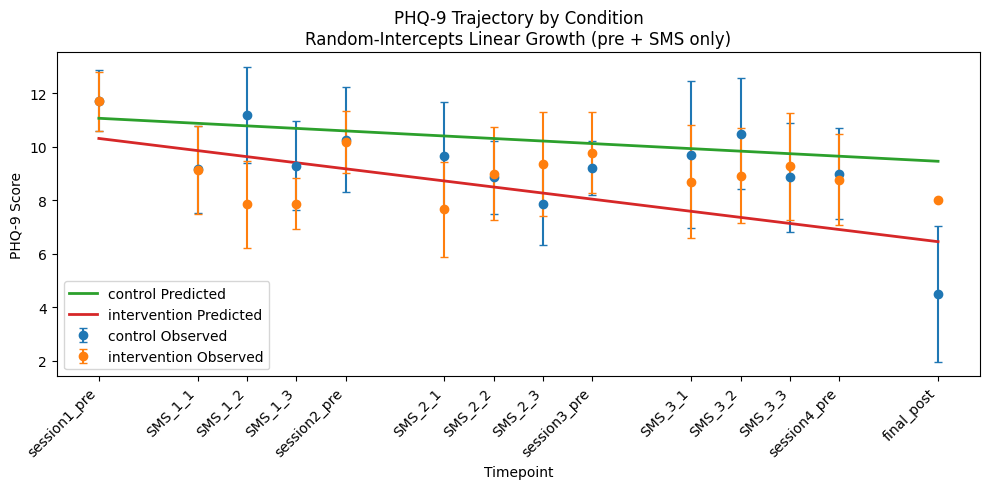

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

# --------------------------------------
# ── ASSUMPTION: df_long is your cleaned, concatenated DataFrame
# --------------------------------------

# 1) Define the ordered timepoints exactly as in your study
ordered_timepoints = [
    'session1_pre','session1_post',
    'SMS_1_1','SMS_1_2','SMS_1_3',
    'session2_pre','session2_post',
    'SMS_2_1','SMS_2_2','SMS_2_3',
    'session3_pre','session3_post',
    'SMS_3_1','SMS_3_2','SMS_3_3',
    'session4_pre','session4_post',
    'final_post'
]

# 2) Turn timepoint into a numeric index
df_long['timepoint'] = pd.Categorical(
    df_long['timepoint'],
    categories=ordered_timepoints,
    ordered=True
)
df_long['time_num'] = df_long['timepoint'].cat.codes

# 3) Subset to pre+SMS only (drop all sessionN_post)
mask_post = df_long['timepoint'].astype(str).str.match(r'^session\d+_post$')
df_model = df_long.loc[~mask_post].copy()

# 4) Drop any rows missing outcome or predictors, reset index
df_model = (
    df_model
    .dropna(subset=['phq9_sum','condition'])
    .reset_index(drop=True)
)

# 5) Center time_num (so intercept ≈ mean PHQ‑9 at midpoint)
df_model['tc'] = df_model['time_num'] - df_model['time_num'].mean()

# 6) Make sure condition is categorical
df_model['condition'] = df_model['condition'].astype('category')

# 7) Fit random‐intercepts linear growth model
model0 = smf.mixedlm(
    "phq9_sum ~ tc * condition",
    data=df_model,
    groups="part_id",
    re_formula="~1"          # random intercept only
)
res0 = model0.fit(method='lbfgs')
print(res0.summary())

# --------------------------------------
# ── PLOTTING OBSERVED ± SEM & FIXED EFFECTS
# --------------------------------------

# a) observed means + SEM
obs = (
    df_model
    .groupby(['condition','time_num'])['phq9_sum']
    .agg(['mean','sem'])
    .reset_index()
)

# b) build prediction grid
fe = res0.fe_params
mean_time = df_model['time_num'].mean()
conds = df_model['condition'].cat.categories
time_vals = sorted(df_model['time_num'].unique())

preds = []
for cond in conds:
    is_int = int(cond == 'intervention')
    for t in time_vals:
        tc = t - mean_time
        pred = (
            fe['Intercept']
            + fe.get('condition[T.intervention]', 0) * is_int
            + fe['tc'] * tc
            + fe.get('tc:condition[T.intervention]', 0) * tc * is_int
        )
        preds.append({'condition': cond, 'time_num': t, 'predicted': pred})
pred_df = pd.DataFrame(preds)

# c) plot
plt.figure(figsize=(10,5))
for cond, grp in obs.groupby('condition'):
    plt.errorbar(
        grp['time_num'], grp['mean'], yerr=grp['sem'],
        fmt='o', capsize=3, label=f"{cond} Observed"
    )
for cond in conds:
    sub = pred_df[pred_df['condition']==cond]
    plt.plot(
        sub['time_num'], sub['predicted'], '-',
        lw=2, label=f"{cond} Predicted"
    )

# label x‐axis with your timepoint names
labels = [ordered_timepoints[i] for i in time_vals]
plt.xticks(time_vals, labels, rotation=45, ha='right')

plt.xlabel("Timepoint")
plt.ylabel("PHQ-9 Score")
plt.title("PHQ-9 Trajectory by Condition\nRandom‐Intercepts Linear Growth (pre + SMS only)")
plt.legend()
plt.tight_layout()
plt.show()

## End Junkyard

In [33]:
# ─── 1. IMPORTS & FILE DEFINITIONS ─────────────────────────────────────────
import zipfile
import pandas as pd
from pathlib import Path

# Two exports: (path, forced_session_n)
files = [
    (Path('/content/wp2_post_sessions_1-3_July 29, 2025_08.55.csv'), None),
    (Path('/content/wp2_post_session_4_July 29, 2025_08.56.csv'), 4),
]

# ─── 2. LOAD & TAG SESSIONS ────────────────────────────────────────────────
dfs = []
for fp, forced in files:
    if fp.suffix == '.zip':
        with zipfile.ZipFile(fp) as z:
            csvs = [f for f in z.namelist() if f.lower().endswith('.csv')]
            assert len(csvs)==1, f"Expected 1 CSV in {fp}, got {csvs}"
            tmp = pd.read_csv(z.open(csvs[0]), header=0)
    else:
        tmp = pd.read_csv(fp, header=0)

    tmp = tmp.iloc[1:].copy()         # drop the Qualtrics metadata row
    if forced is not None:
        tmp['session_n'] = forced     # force session 4 → 4
    dfs.append(tmp)

df = pd.concat(dfs, ignore_index=True)

# ─── 3. STANDARDIZE part_id & MERGE CONDITIONS ─────────────────────────────
df['part_id'] = df['part_id'].astype(str)
assign = pd.read_csv('/content/wp2_assignments.csv')
assign['part_id'] = assign['part_id'].astype(str)
df = df.merge(assign[['part_id','condition']], on='part_id', how='left')

df['session_n'] = pd.to_numeric(df['session_n'], errors='coerce')

# ─── 4. DEFINE SUBSCALES ─────────────────────────────────────────────────────
vhq_defs = {
    "Geometric":   ['6d_vhq_1','6d_vhq_2','6d_vhq_3'],
    "Semantic":    ['6d_vhq_4','6d_vhq_5','6d_vhq_6'],
    "Detail":      ['6d_vhq_7','6d_vhq_8','6d_vhq_9'],
    "Vividness":   ['6d_vhq_10','6d_vhq_11','6d_vhq_12'],
    "Entropy":     ['6d_vhq_13','6d_vhq_14','6d_vhq_15'],
    "Focality":    ['6d_vhq_16','6d_vhq_17','6d_vhq_18'],
}

asc_defs = {
    "Experience_of_Unity": [
        'asc_18_4','asc_34_4','asc_41_4','asc_42_4','asc_52_4'
    ],
    "Spiritual_Experience": [
        'asc_9_4','asc_81_4','asc_94_4'
    ],
    "Blissful_State": [
        'asc_12_4','asc_86_4','asc_91_4'
    ],
    "Insightfulness": [
        'asc_50_4','asc_69_4','asc_77_4'      # asc_72_4 is Visionary, not Insight
    ],
    "Disembodiment": [
        'asc_26_4','asc_62_4','asc_63_4'
    ],
    "Impaired_Control_and_Cognition": [
        'asc_8_4','asc_27_4','asc_38_4','asc_47_4','asc_64_4','asc_67_4','asc_78_4'
    ],
    "Anxiety": [
        'asc_32_4','asc_43_4','asc_44_4','asc_46_4','asc_56_4','asc_89_4'
    ],
    "Complex_Imagery": [
        'asc_39_4','asc_72_4','asc_82_4'
    ],
    "Elementary_Imagery": [
        'asc_14_4','asc_22_4','asc_33_4'
    ],
    "Audio_Visual_Synesthesia": [
        'asc_20_4','asc_23_4','asc_75_4'
    ],
    "Changed_Meaning_of_Percepts": [
        'asc_28_4','asc_31_4','asc_54_4'
    ]
}

exp4_defs = [
    'exp4_engagement_1',
    'exp4_pleasure_1',
    'exp4_discomfort_1',
    'exp4_arousal_1',
]

# ─── 5. INTERSECT & CAST TO NUMERIC ──────────────────────────────────────────
def intersect(name, items):
    pres = [c for c in items if c in df.columns]
    miss = set(items) - set(pres)
    if miss:
        print(f"⚠️ {name}: dropped {len(miss)} missing → {sorted(miss)}")
    return pres

vhq = {k: intersect(k, v) for k, v in vhq_defs.items()}
asc = {k: intersect(k, v) for k, v in asc_defs.items()}
exp4 = intersect("EXP4", exp4_defs)

# dedupe and convert
all_cols = sum(vhq.values(), []) + sum(asc.values(), []) + exp4
unique_cols = []
for c in all_cols:
    if c in df.columns and c not in unique_cols:
        unique_cols.append(c)

df[unique_cols] = df[unique_cols].apply(pd.to_numeric, errors='coerce')

# ─── 5.5 REVERSE‑CODE VIVIDNESS ITEMS (1–5 scale) ────────────────────────────
min_score, max_score = 1, 5
for item in vhq['Vividness']:
    df[item] = (max_score + min_score) - df[item]

# ─── 6. COMPUTE PARTICIPANT×SESSION SCORES ──────────────────────────────────
records = []
for (pid, sess), sub in df.groupby(['part_id', 'session_n']):
    rec = {'part_id': pid, 'session_n': sess, 'condition': sub['condition'].iloc[0]}
    # VHQ
    for d, cols in vhq.items():
        rec[f'VHQ_{d}'] = sub[cols].mean(axis=1).mean()
    # ASC
    for d, cols in asc.items():
        rec[f'ASC_{d}'] = sub[cols].mean(axis=1).mean()
    # EXP4
    for col in exp4:
        key = col.replace('exp4_', '').replace('_1', '').capitalize()
        rec[f'EXP4_{key}'] = sub[col].mean()
    records.append(rec)

df_scores = pd.DataFrame(records)

# ─── 7. SESSION & SESSION×CONDITION MEANS ──────────────────────────────────
session_means      = df_scores.groupby('session_n',    as_index=False).mean(numeric_only=True)
session_cond_means = df_scores.groupby(['session_n','condition'], as_index=False).mean(numeric_only=True)

print("session_means:\n", session_means)
print("\nsession×condition means:\n", session_cond_means)

session_means:
    session_n  VHQ_Geometric  VHQ_Semantic  VHQ_Detail  VHQ_Vividness  \
0        1.0       3.441667      2.805556    3.060185       3.607843   
1        2.0       3.508772      2.814103    2.989899       3.316667   
2        3.0       3.568182      2.850877    3.097701       3.094203   
3        4.0       3.650000      2.944444    2.969697       3.516667   

   VHQ_Entropy  VHQ_Focality  ASC_Experience_of_Unity  \
0     3.009524      2.816667                28.569231   
1     3.133333      2.833333                32.828571   
2     3.230769      2.727273                28.427586   
3     3.143939      2.868421                28.376000   

   ASC_Spiritual_Experience  ASC_Blissful_State  ...  \
0                 30.299145           34.239316  ...   
1                 28.447619           34.771429  ...   
2                 24.126437           30.678161  ...   
3                 28.013333           35.053333  ...   

   ASC_Impaired_Control_and_Cognition  ASC_Anxiety  ASC_

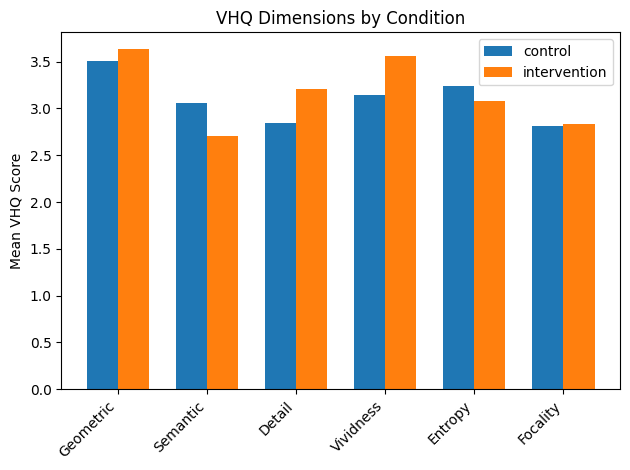

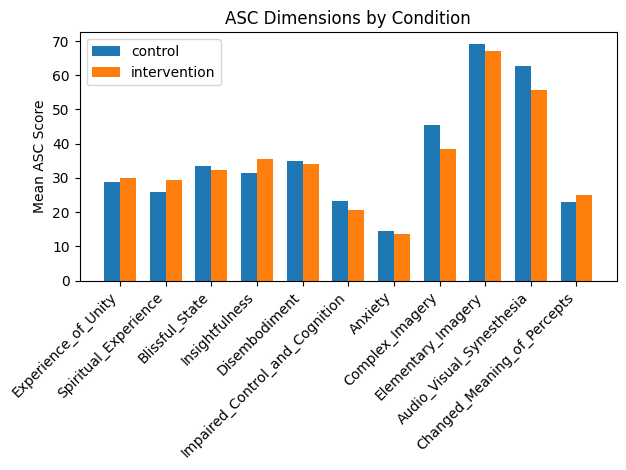

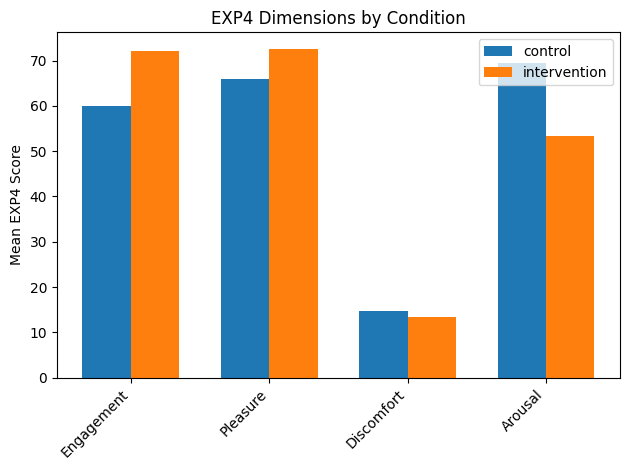

In [34]:
import matplotlib.pyplot as plt

# Compute overall means per condition across all sessions
overall = df_scores.groupby('condition').mean(numeric_only=True)
conds   = overall.index.tolist()
width   = 0.35

# 1) VHQ bar chart
vhq_cols   = [c for c in overall.columns if c.startswith('VHQ_')]
vhq_labels = [c.replace('VHQ_', '') for c in vhq_cols]
x = range(len(vhq_cols))

plt.figure()
for i, cond in enumerate(conds):
    plt.bar([pos + i*width for pos in x],
            overall.loc[cond, vhq_cols],
            width,
            label=cond)
plt.xticks([pos + width*(len(conds)-1)/2 for pos in x],
           vhq_labels, rotation=45, ha='right')
plt.ylabel('Mean VHQ Score')
plt.title('VHQ Dimensions by Condition')
plt.legend()
plt.tight_layout()

# 2) ASC bar chart
asc_cols   = [c for c in overall.columns if c.startswith('ASC_')]
asc_labels = [c.replace('ASC_', '') for c in asc_cols]
x = range(len(asc_cols))

plt.figure()
for i, cond in enumerate(conds):
    plt.bar([pos + i*width for pos in x],
            overall.loc[cond, asc_cols],
            width,
            label=cond)
plt.xticks([pos + width*(len(conds)-1)/2 for pos in x],
           asc_labels, rotation=45, ha='right')
plt.ylabel('Mean ASC Score')
plt.title('ASC Dimensions by Condition')
plt.legend()
plt.tight_layout()

# 3) EXP4 bar chart
exp4_cols   = [c for c in overall.columns if c.startswith('EXP4_')]
exp4_labels = [c.replace('EXP4_', '') for c in exp4_cols]
x = range(len(exp4_cols))

plt.figure()
for i, cond in enumerate(conds):
    plt.bar([pos + i*width for pos in x],
            overall.loc[cond, exp4_cols],
            width,
            label=cond)
plt.xticks([pos + width*(len(conds)-1)/2 for pos in x],
           exp4_labels, rotation=45, ha='right')
plt.ylabel('Mean EXP4 Score')
plt.title('EXP4 Dimensions by Condition')
plt.legend()
plt.tight_layout()

plt.show()

### Mean Differences (Intervention minus Control) ###
                         Dimension  Mean Difference
                         session_n         0.115468
                     VHQ_Geometric         0.124145
                      VHQ_Semantic        -0.362383
                        VHQ_Detail         0.362281
                     VHQ_Vividness         0.413255
                       VHQ_Entropy        -0.150808
                      VHQ_Focality         0.020833
           ASC_Experience_of_Unity         1.323638
          ASC_Spiritual_Experience         3.543210
                ASC_Blissful_State        -1.304648
                ASC_Insightfulness         4.227487
                 ASC_Disembodiment        -0.888889
ASC_Impaired_Control_and_Cognition        -2.824308
                       ASC_Anxiety        -0.849492
               ASC_Complex_Imagery        -6.890704
            ASC_Elementary_Imagery        -1.893972
      ASC_Audio_Visual_Synesthesia        -6.797023
   ASC_Cha

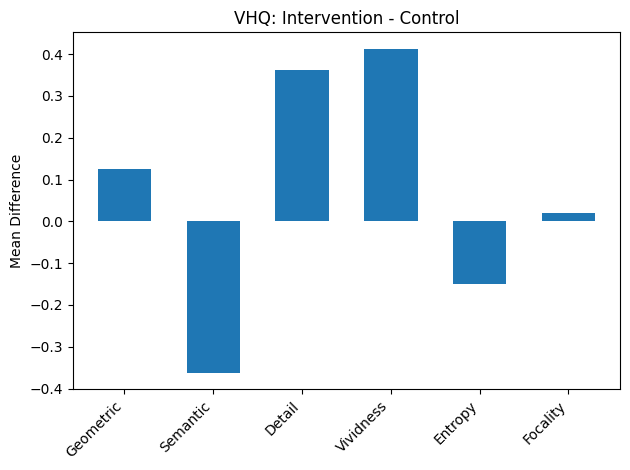

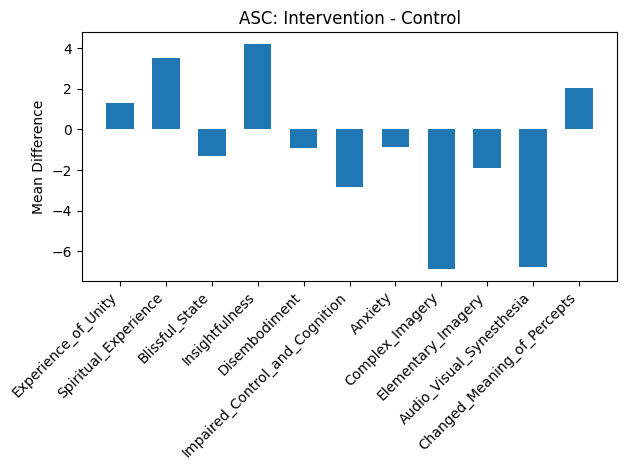

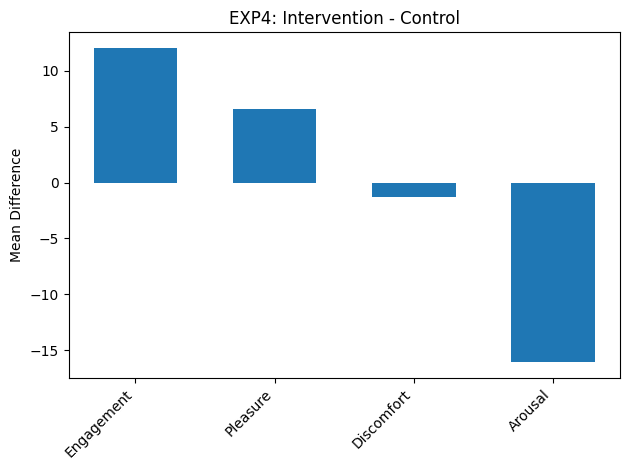

### Intervention − Control: Mean Differences & p‑values ###


Dimension   MeanDiff   p_value
0                        VHQ_Geometric   0.124145  0.581290
1                         VHQ_Semantic  -0.362383  0.230495
2                           VHQ_Detail   0.362281  0.067147
3                        VHQ_Vividness   0.413255  0.008549
4                          VHQ_Entropy  -0.150808  0.269931
5                         VHQ_Focality   0.020833  0.646773
6              ASC_Experience_of_Unity   1.323638  0.889562
7             ASC_Spiritual_Experience   3.543210  0.699052
8                   ASC_Blissful_State  -1.304648  0.996016
9                   ASC_Insightfulness   4.227487  0.570846
10                   ASC_Disembodiment  -0.888889  0.951262
11  ASC_Impaired_Control_and_Cognition  -2.824308  0.350593
12                         ASC_Anxiety  -0.849492  0.551215
13                 ASC_Complex_Imagery  -6.890704  0.259279
14              ASC_Elementary_Imagery  -1.893972  0.984117
15        ASC_Audio_Visual_Synesthesia  -6.797023  0.503934
16     ASC_Changed_Meaning_of_Percepts   2.065723  0.839242
17                     EXP4_Engagement  12.032680  0.198845
18                       EXP4_Pleasure   6.588235  0.460268
19                     EXP4_Discomfort  -1.332789  0.520719
20                        EXP4_Arousal -16.055011  0.020934

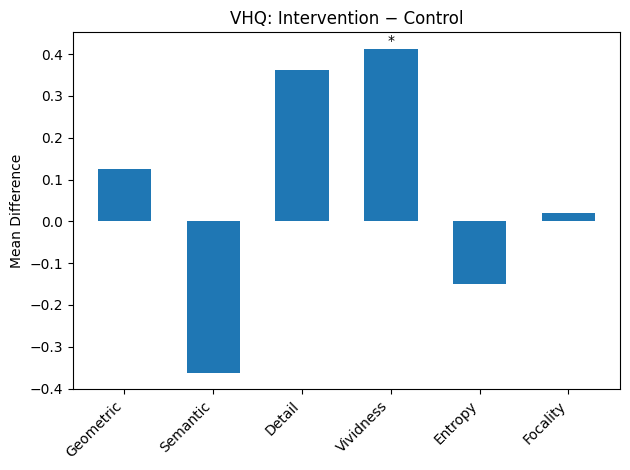

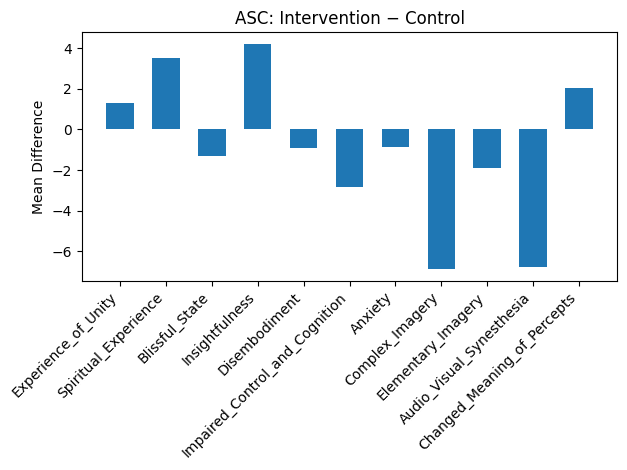

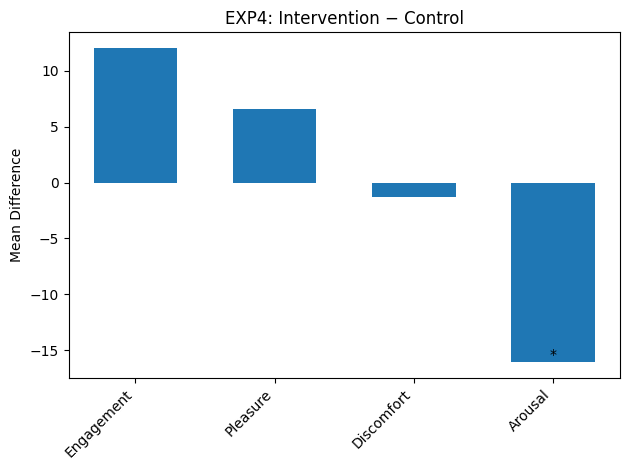

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Compute overall means per condition across all sessions
overall = df_scores.groupby('condition').mean(numeric_only=True)

# 2. Determine which condition is Control vs. Intervention
conds = sorted(overall.index.tolist())

# 3. Compute the difference (Intervention – Control)
diff = overall.loc[conds[1]] - overall.loc[conds[0]]

# 4. Display the numeric table of differences
diff_df = pd.DataFrame({
    'Dimension': diff.index,
    'Mean Difference': diff.values
})
print("### Mean Differences (Intervention minus Control) ###")
print(diff_df.to_string(index=False))

# 5. Plot the differences by scale

width = 0.6

# VHQ
vhq_cols   = [c for c in diff.index if c.startswith('VHQ_')]
vhq_labels = [c.replace('VHQ_', '') for c in vhq_cols]
x = range(len(vhq_cols))

plt.figure()
plt.bar(x, diff[vhq_cols], width)
plt.xticks(x, vhq_labels, rotation=45, ha='right')
plt.ylabel('Mean Difference')
plt.title('VHQ: Intervention - Control')
plt.tight_layout()

# ASC
asc_cols   = [c for c in diff.index if c.startswith('ASC_')]
asc_labels = [c.replace('ASC_', '') for c in asc_cols]
x = range(len(asc_cols))

plt.figure()
plt.bar(x, diff[asc_cols], width)
plt.xticks(x, asc_labels, rotation=45, ha='right')
plt.ylabel('Mean Difference')
plt.title('ASC: Intervention - Control')
plt.tight_layout()

# EXP4
exp4_cols   = [c for c in diff.index if c.startswith('EXP4_')]
exp4_labels = [c.replace('EXP4_', '') for c in exp4_cols]
x = range(len(exp4_cols))

plt.figure()
plt.bar(x, diff[exp4_cols], width)
plt.xticks(x, exp4_labels, rotation=45, ha='right')
plt.ylabel('Mean Difference')
plt.title('EXP4: Intervention - Control')
plt.tight_layout()

plt.show()

import pandas as pd
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt

# 1. Identify all VHQ, ASC, EXP4 dimensions
dim_cols = [c for c in df_scores.columns if c.startswith(('VHQ_','ASC_','EXP4_'))]

# 2. Compute overall condition means and differences
cond_means = df_scores.groupby('condition')[dim_cols].mean()
conds = sorted(cond_means.index.tolist())
diff = cond_means.loc[conds[1]] - cond_means.loc[conds[0]]

# 3. Independent t-tests between conditions on participant means
part_means = (
    df_scores
    .groupby(['part_id','condition'])[dim_cols]
    .mean()
    .reset_index()
)
p_vals = {}
for dim in dim_cols:
    g1 = part_means.loc[part_means['condition']==conds[0], dim]
    g2 = part_means.loc[part_means['condition']==conds[1], dim]
    _, p = ttest_ind(g1, g2, nan_policy='omit')
    p_vals[dim] = p

# 4. Assemble results
results = pd.DataFrame({
    'Dimension': dim_cols,
    'MeanDiff': [diff[d] for d in dim_cols],
    'p_value': [p_vals[d] for d in dim_cols]
})

# 5. Display full results
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
print("### Intervention − Control: Mean Differences & p‑values ###")
display(results)

# 6. Plot with significance asterisks
width = 0.6
for scale, prefix in [('VHQ','VHQ_'), ('ASC','ASC_'), ('EXP4','EXP4_')]:
    cols   = [d for d in results['Dimension'] if d.startswith(prefix)]
    labs   = [c.replace(prefix,'') for c in cols]
    vals   = results.set_index('Dimension').loc[cols,'MeanDiff']
    pvs    = results.set_index('Dimension').loc[cols,'p_value']

    x = range(len(cols))
    fig, ax = plt.subplots()
    ax.bar(x, vals, width)
    ax.set_xticks(x)
    ax.set_xticklabels(labs, rotation=45, ha='right')
    ax.set_ylabel('Mean Difference')
    ax.set_title(f'{scale}: Intervention − Control')

    y_max = vals.max()
    for i, p in enumerate(pvs):
        if p < 0.05:
            ax.text(i, vals.iloc[i] + 0.02*y_max, '*', ha='center')
    plt.tight_layout()
plt.show()

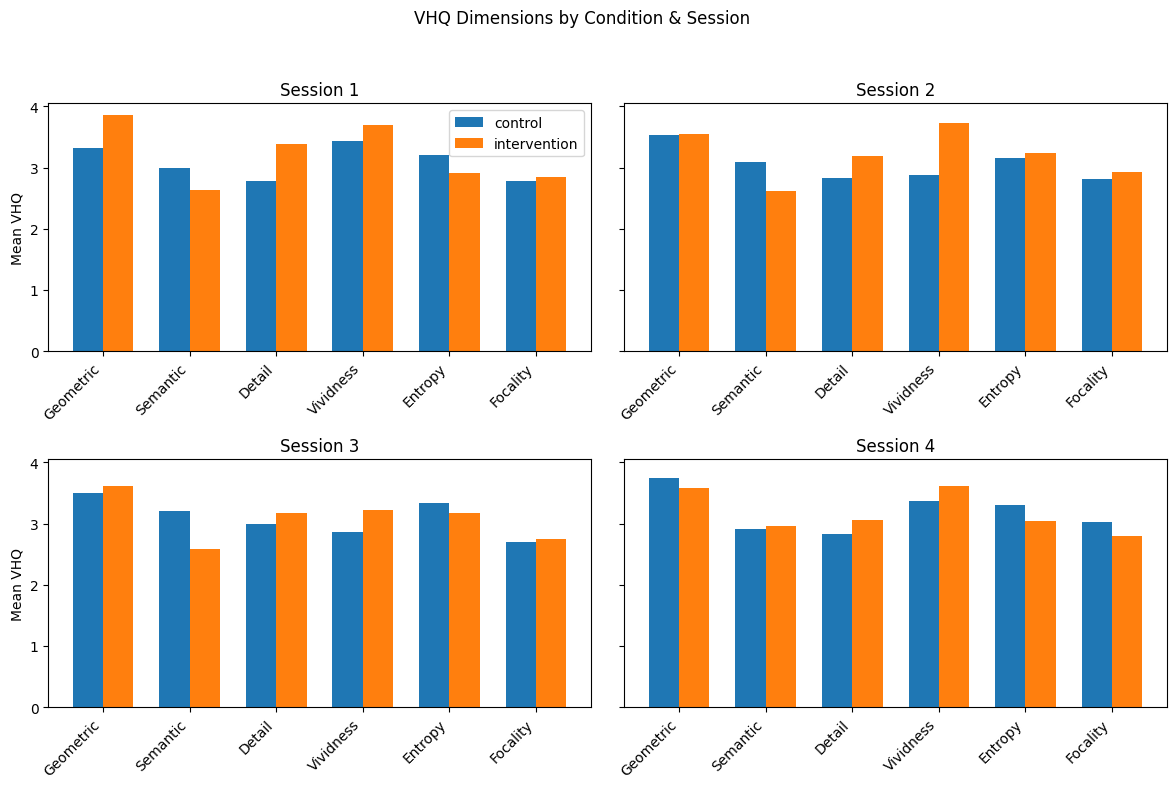

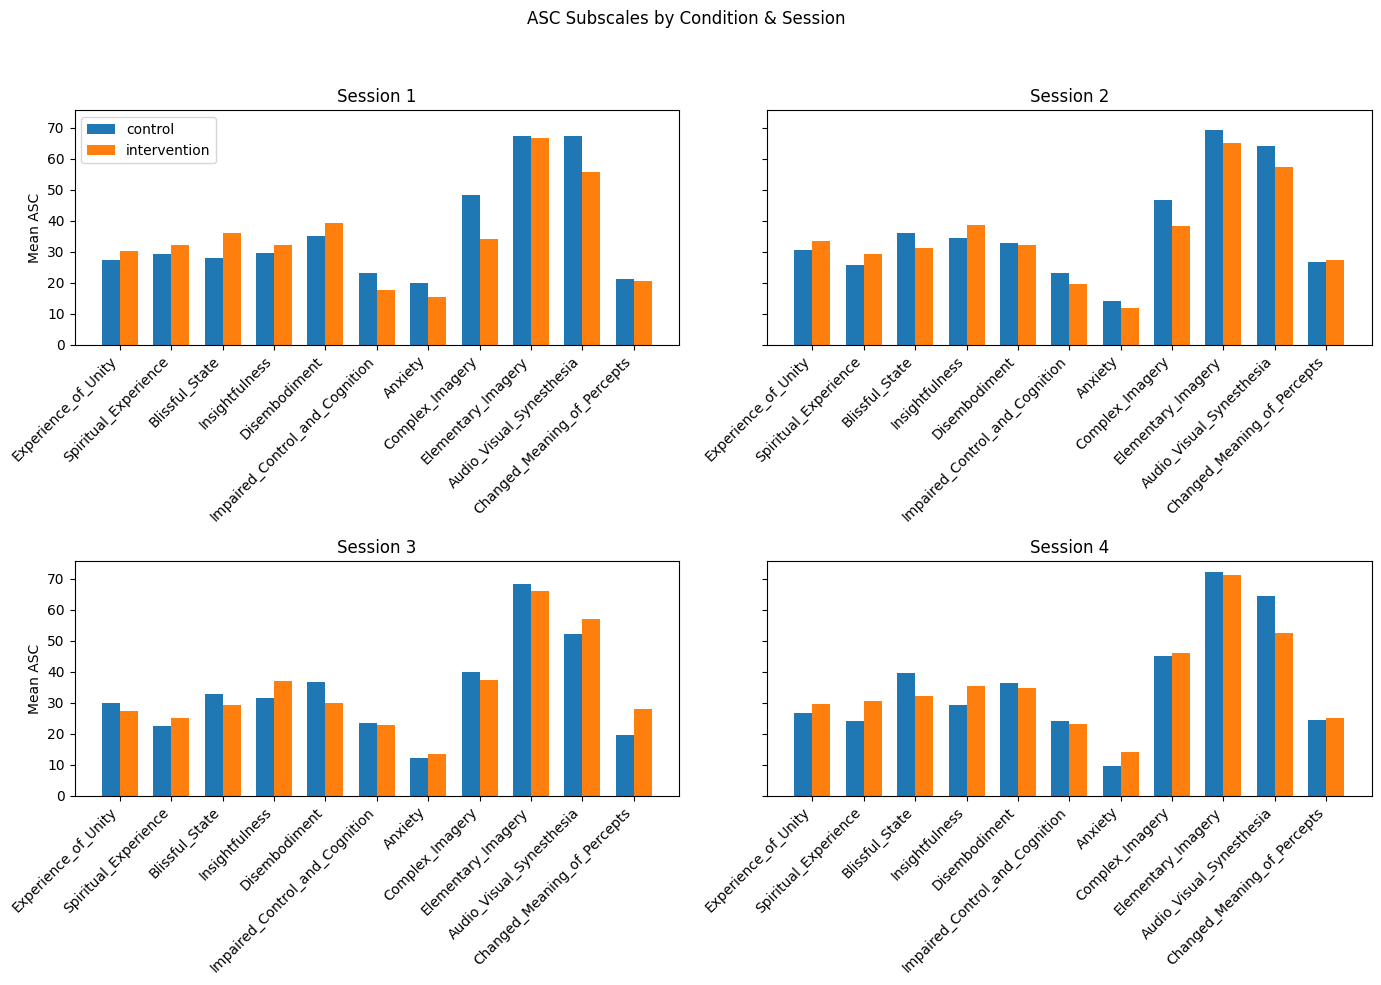

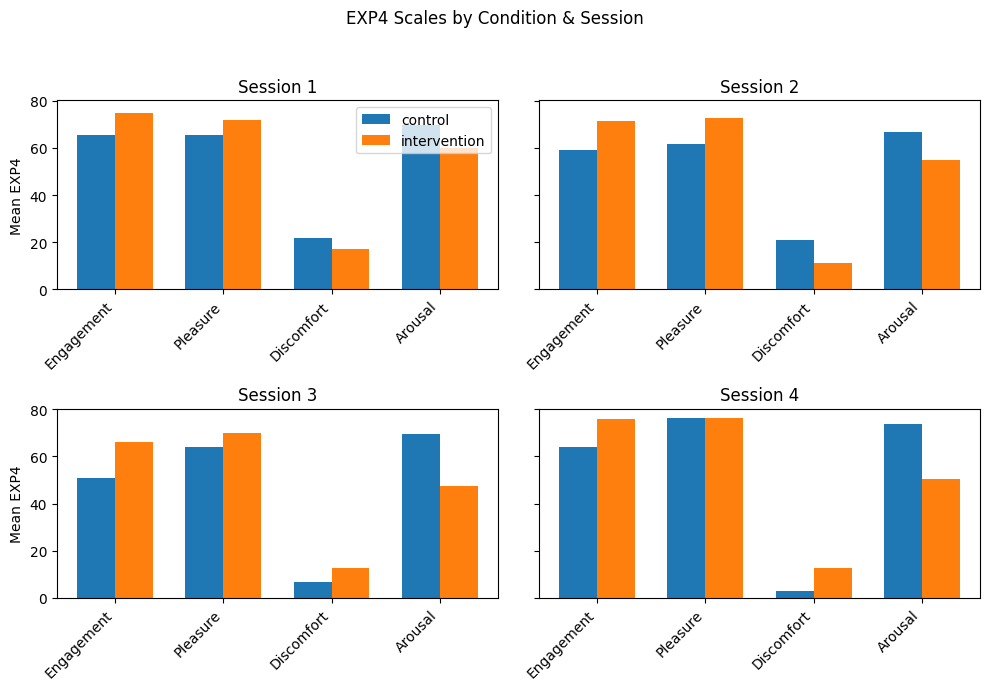

In [36]:
import matplotlib.pyplot as plt

# 1. Grab your existing session×condition means
#    It should have columns like VHQ_Geometric, ASC_Unity, EXP4_Engagement, etc.
#    and an index or columns ['session_n','condition']
session_cond = session_cond_means.set_index(['session_n','condition'])

sessions = sorted(session_cond.index.get_level_values('session_n').unique())
conds    = sorted(session_cond.index.get_level_values('condition').unique())
width    = 0.35

# 2. VHQ Dimensions
vhq_cols   = [c for c in session_cond.columns if c.startswith('VHQ_')]
vhq_labels = [c.replace('VHQ_','') for c in vhq_cols]

fig, axes = plt.subplots(2,2, figsize=(12,8), sharey=True)
axes = axes.flatten()
x = range(len(vhq_cols))

for i, sess in enumerate(sessions):
    ax = axes[i]
    for j, cond in enumerate(conds):
        vals = session_cond.loc[(sess,cond), vhq_cols]
        ax.bar([pos + j*width for pos in x], vals, width, label=cond)
    ax.set_title(f"Session {int(sess)}")
    ax.set_xticks([pos + width*(len(conds)-1)/2 for pos in x])
    ax.set_xticklabels(vhq_labels, rotation=45, ha='right')
    if i%2==0: ax.set_ylabel("Mean VHQ")
    if i==0:  ax.legend()
fig.suptitle("VHQ Dimensions by Condition & Session")
plt.tight_layout(rect=[0,0,1,0.95])

# 3. ASC Subscales
asc_cols   = [c for c in session_cond.columns if c.startswith('ASC_')]
asc_labels = [c.replace('ASC_','') for c in asc_cols]

fig, axes = plt.subplots(2,2, figsize=(14,10), sharey=True)
axes = axes.flatten()
x = range(len(asc_cols))

for i, sess in enumerate(sessions):
    ax = axes[i]
    for j, cond in enumerate(conds):
        vals = session_cond.loc[(sess,cond), asc_cols]
        ax.bar([pos + j*width for pos in x], vals, width, label=cond)
    ax.set_title(f"Session {int(sess)}")
    ax.set_xticks([pos + width*(len(conds)-1)/2 for pos in x])
    ax.set_xticklabels(asc_labels, rotation=45, ha='right')
    if i%2==0: ax.set_ylabel("Mean ASC")
    if i==0:  ax.legend()
fig.suptitle("ASC Subscales by Condition & Session")
plt.tight_layout(rect=[0,0,1,0.95])

# 4. EXP4 Scales
exp4_cols   = [c for c in session_cond.columns if c.startswith('EXP4_')]
exp4_labels = [c.replace('EXP4_','') for c in exp4_cols]

fig, axes = plt.subplots(2,2, figsize=(10,7), sharey=True)
axes = axes.flatten()
x = range(len(exp4_cols))

for i, sess in enumerate(sessions):
    ax = axes[i]
    for j, cond in enumerate(conds):
        vals = session_cond.loc[(sess,cond), exp4_cols]
        ax.bar([pos + j*width for pos in x], vals, width, label=cond)
    ax.set_title(f"Session {int(sess)}")
    ax.set_xticks([pos + width*(len(conds)-1)/2 for pos in x])
    ax.set_xticklabels(exp4_labels, rotation=45, ha='right')
    if i%2==0: ax.set_ylabel("Mean EXP4")
    if i==0:  ax.legend()
fig.suptitle("EXP4 Scales by Condition & Session")
plt.tight_layout(rect=[0,0,1,0.95])

plt.show()

/tmp/ipython-input-37-2372926287.py:28: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


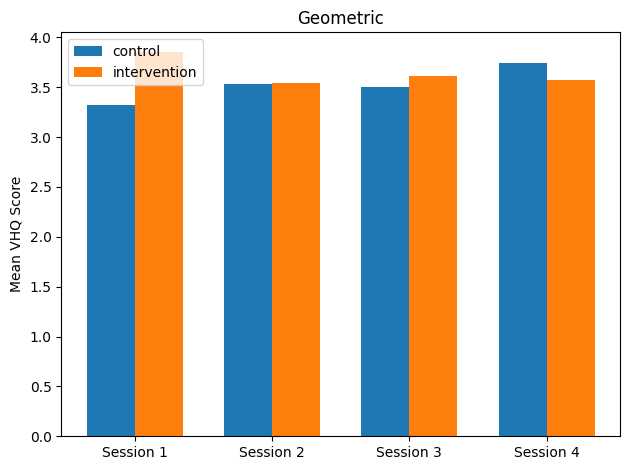

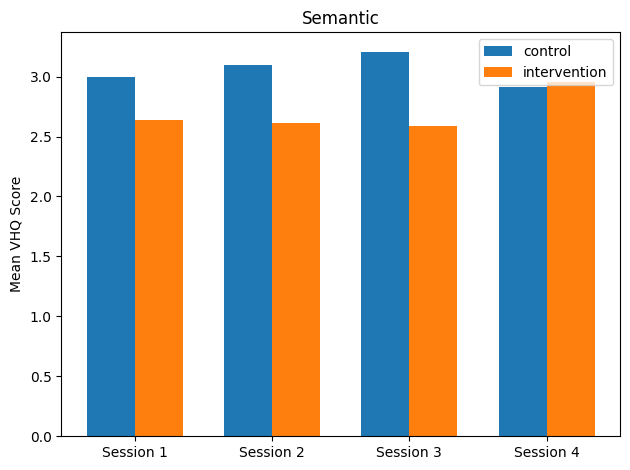

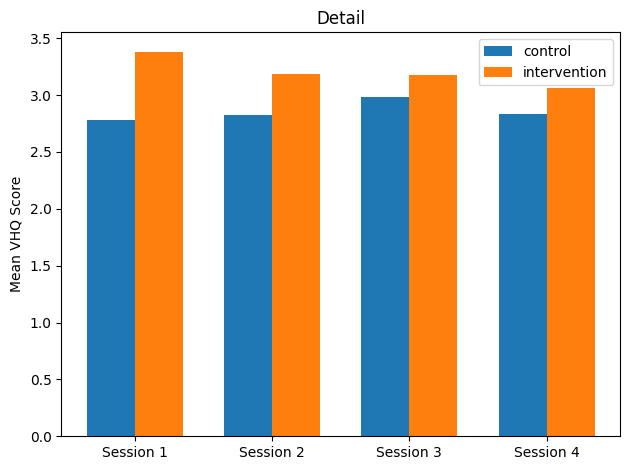

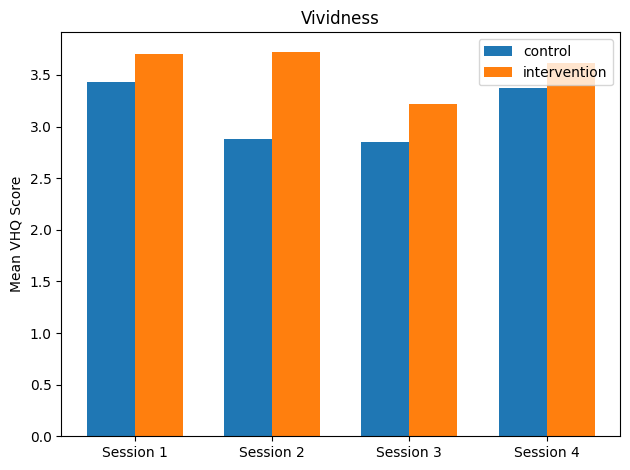

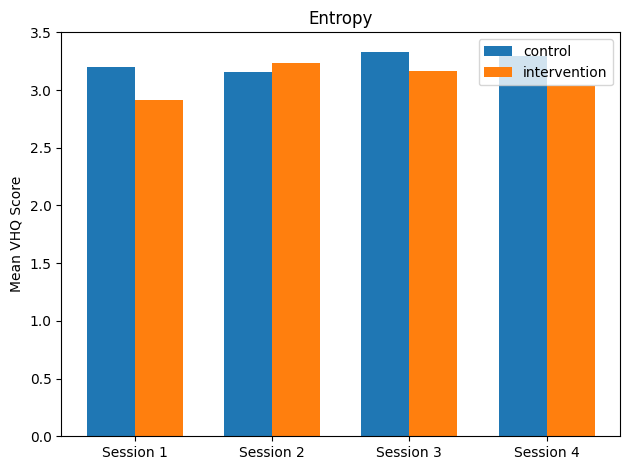

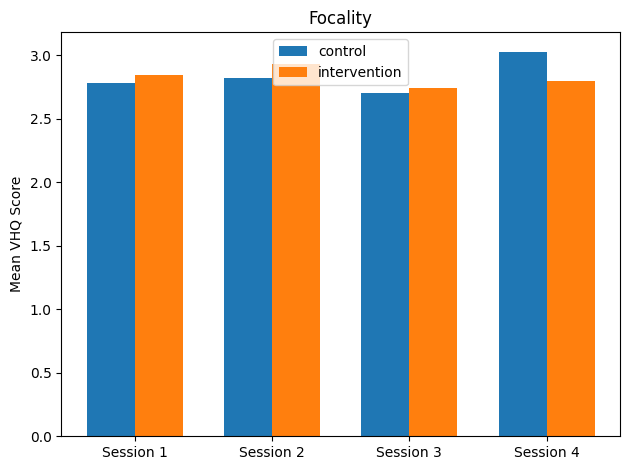

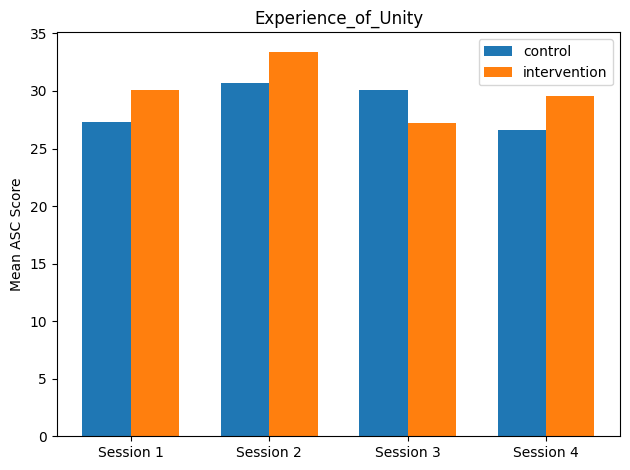

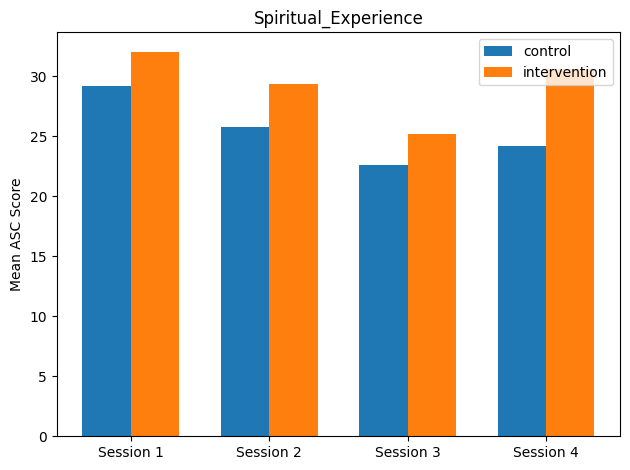

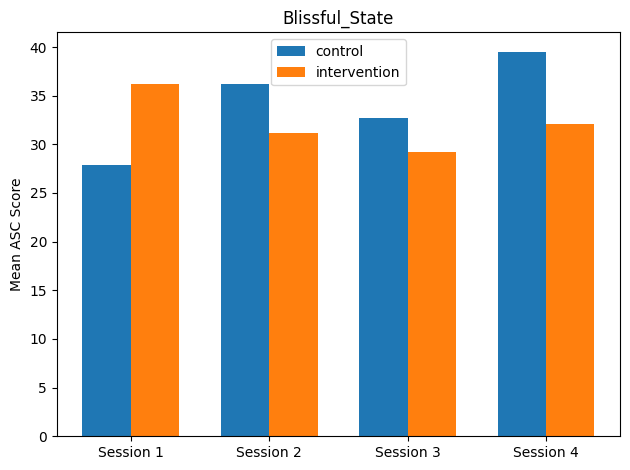

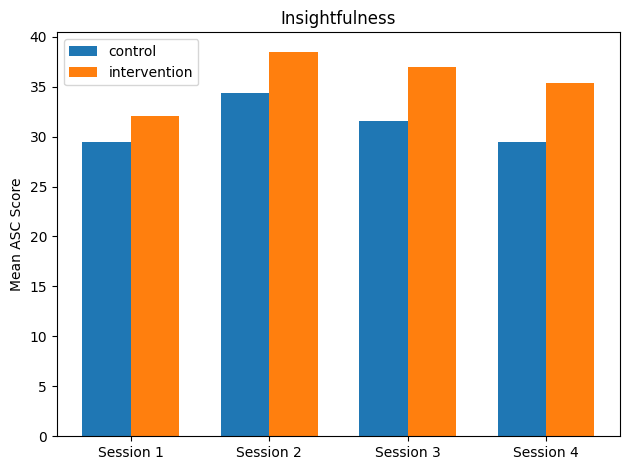

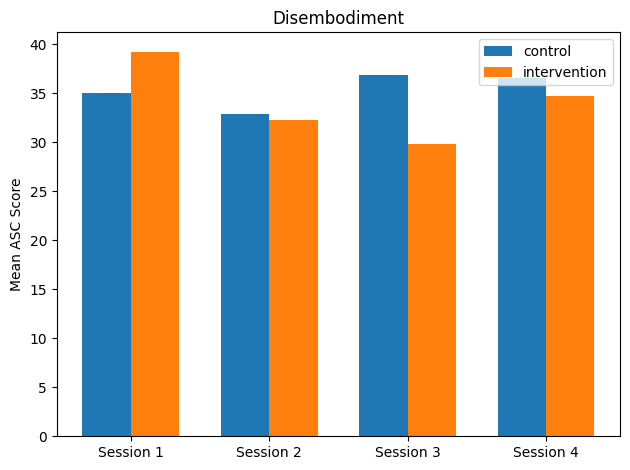

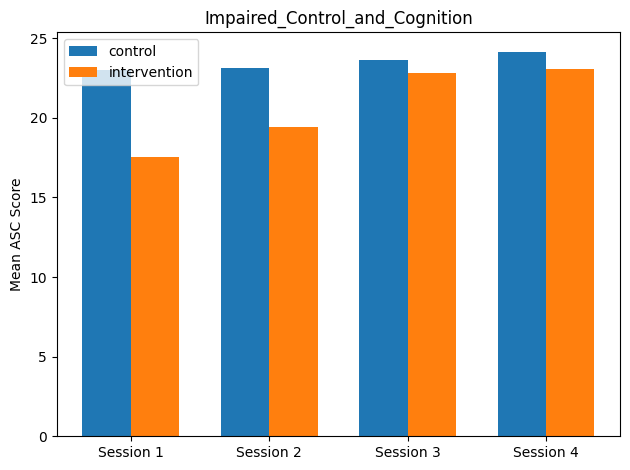

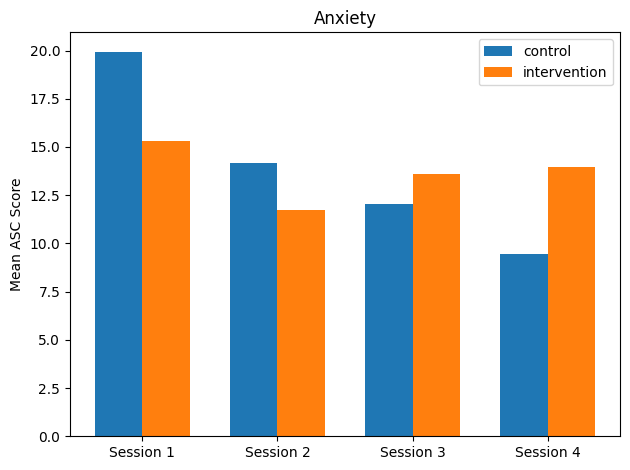

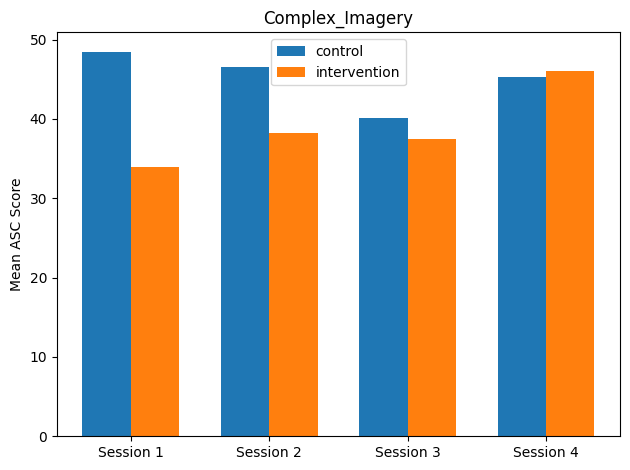

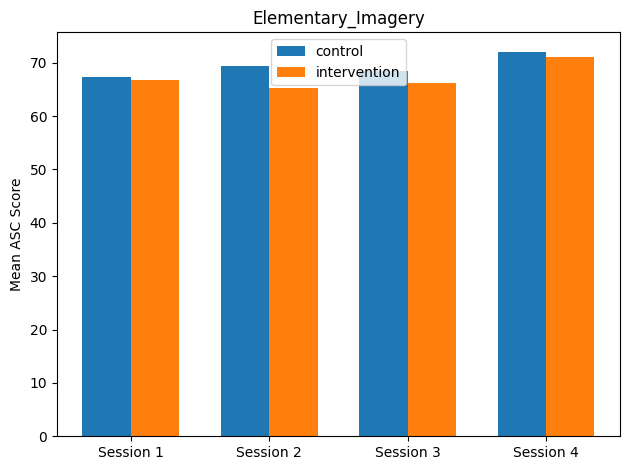

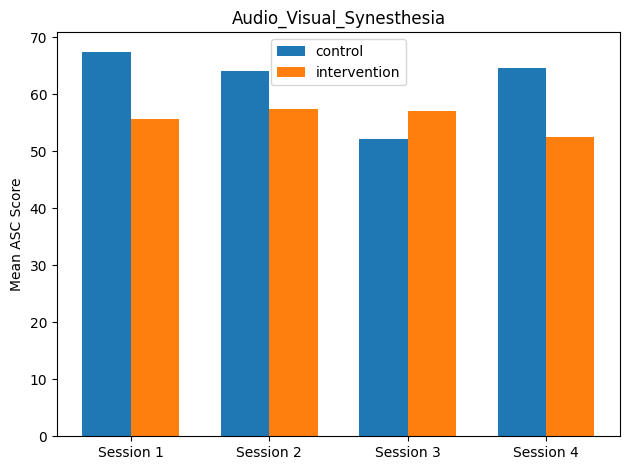

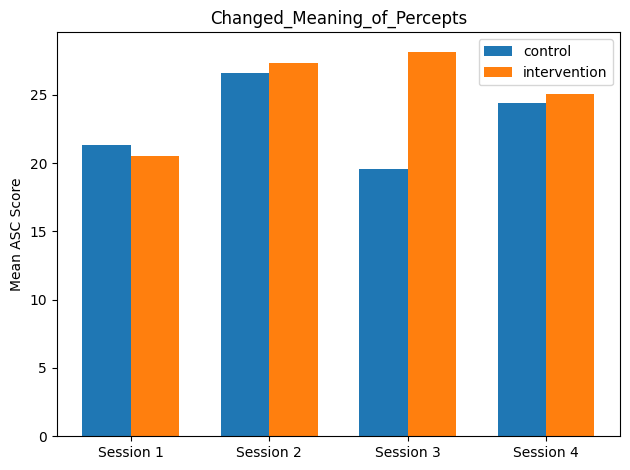

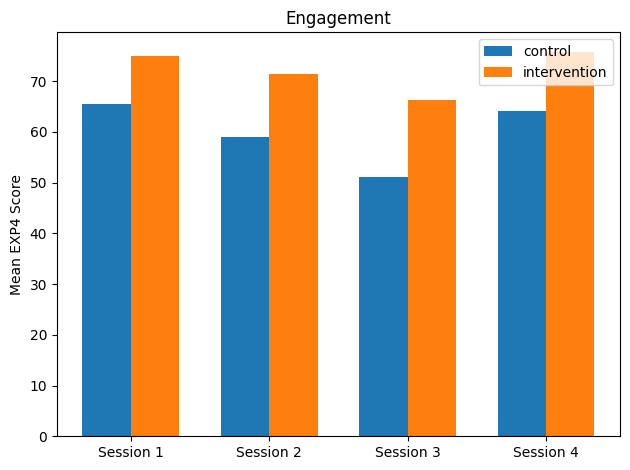

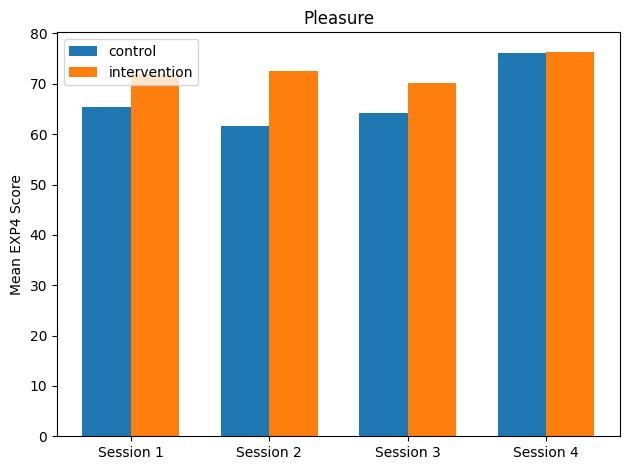

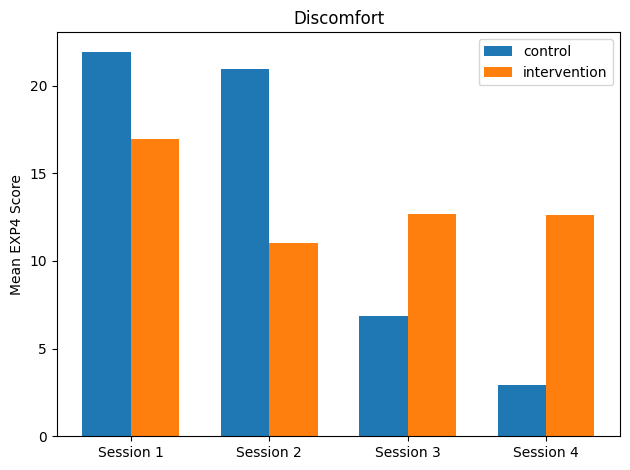

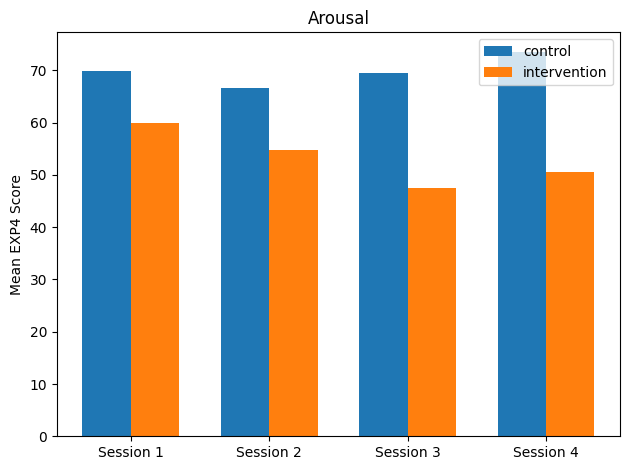

In [37]:
import matplotlib.pyplot as plt

# Make sure you’ve already got:
#   df_scores with columns ['part_id','session_n','condition', 'VHQ_*', 'ASC_*', 'EXP4_*']

# 1. Compute session×condition means
session_cond = (
    df_scores
    .groupby(['session_n','condition'], as_index=False)
    .mean(numeric_only=True)
    .set_index(['session_n','condition'])
)

sessions = sorted(session_cond.index.get_level_values('session_n').unique())
conds    = sorted(session_cond.index.get_level_values('condition').unique())
width    = 0.35

# 2. Lists of your dimension columns
vhq_cols  = [c for c in session_cond.columns if c.startswith('VHQ_')]
asc_cols  = [c for c in session_cond.columns if c.startswith('ASC_')]
exp4_cols = [c for c in session_cond.columns if c.startswith('EXP4_')]

# 3. Plot function
def plot_by_session(cols, prefix, ylabel):
    labels = [c.replace(prefix, '') for c in cols]
    x = range(len(sessions))
    for dim, lab in zip(cols, labels):
        fig, ax = plt.subplots()
        for i, cond in enumerate(conds):
            vals = [session_cond.loc[(s,cond), dim] for s in sessions]
            ax.bar([pos + i*width for pos in x], vals, width, label=cond)
        ax.set_xticks([pos + width*(len(conds)-1)/2 for pos in x])
        ax.set_xticklabels([f"Session {int(s)}" for s in sessions])
        ax.set_ylabel(ylabel)
        ax.set_title(lab)
        ax.legend()
        fig.tight_layout()

# 4. Make the three sets of plots
plot_by_session(vhq_cols,  'VHQ_',  'Mean VHQ Score')
plot_by_session(asc_cols,  'ASC_',  'Mean ASC Score')
plot_by_session(exp4_cols, 'EXP4_', 'Mean EXP4 Score')

plt.show()

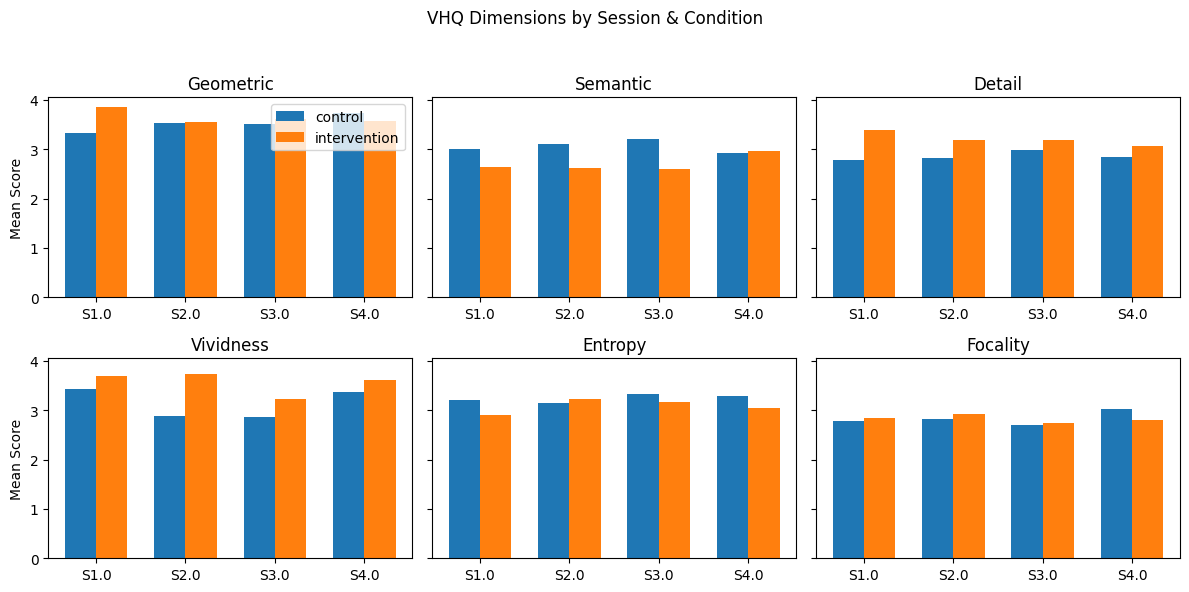

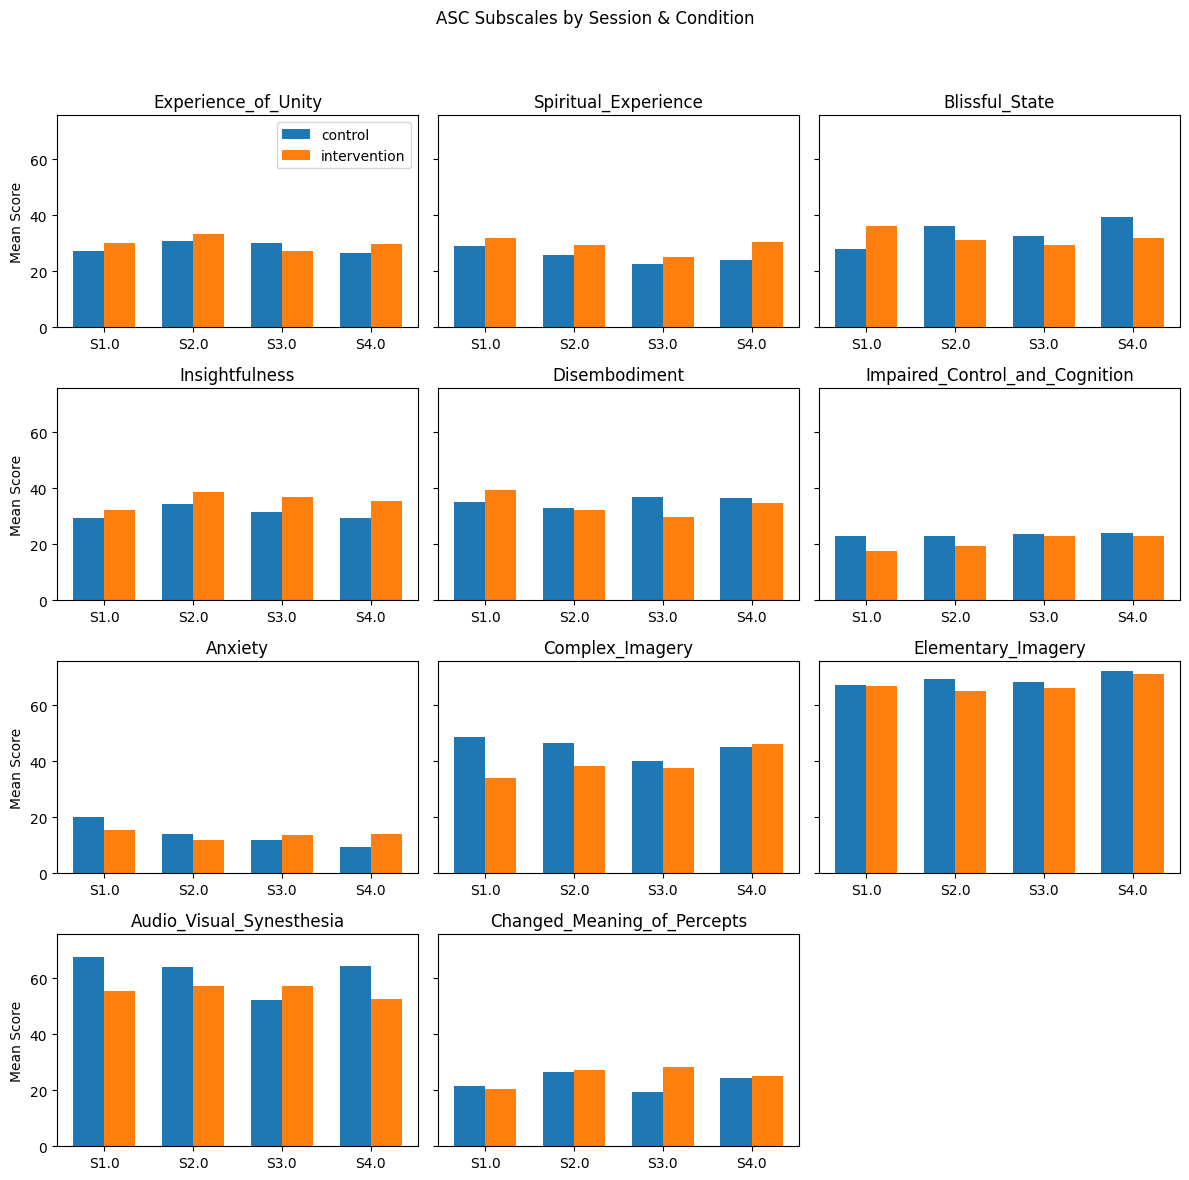

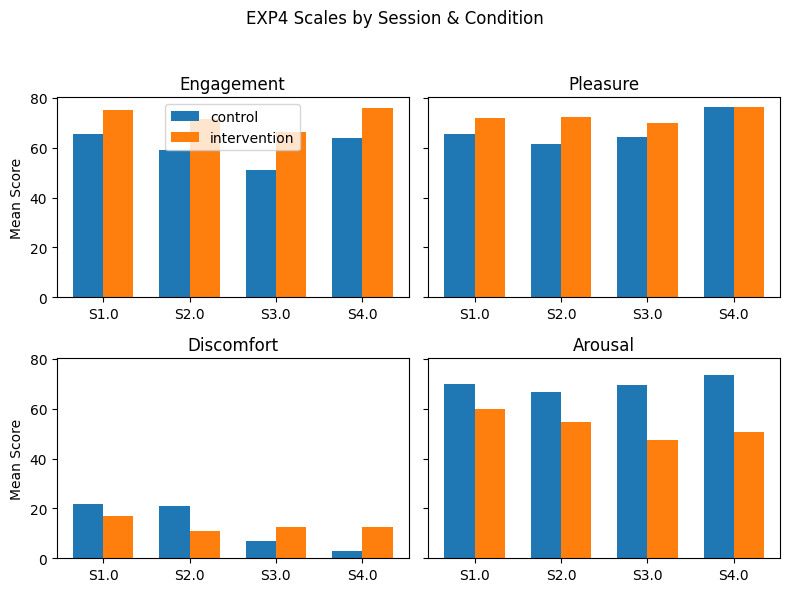

In [38]:
import matplotlib.pyplot as plt

# 1. Build the session×condition means table
session_cond = (
    df_scores
    .groupby(['session_n','condition'], as_index=False)
    .mean(numeric_only=True)
    .set_index(['session_n','condition'])
)

sessions = sorted(session_cond.index.get_level_values('session_n').unique())
conds    = sorted(session_cond.index.get_level_values('condition').unique())
width    = 0.35

# Helpers to pull out columns
vhq_cols   = [c for c in session_cond.columns if c.startswith('VHQ_')]
asc_cols   = [c for c in session_cond.columns if c.startswith('ASC_')]
exp4_cols  = [c for c in session_cond.columns if c.startswith('EXP4_')]

# Plotting function for one scale
def plot_scale(cols, prefix, rows, cols_per_row, title):
    labels = [c.replace(prefix, '') for c in cols]
    fig, axes = plt.subplots(rows, cols_per_row, figsize=(4*cols_per_row, 3*rows), sharey=True)
    axes_flat = axes.flatten()
    for idx, col in enumerate(cols):
        ax = axes_flat[idx]
        x = range(len(sessions))
        for i, cond in enumerate(conds):
            vals = [session_cond.loc[(s,cond), col] for s in sessions]
            ax.bar([pos + i*width for pos in x], vals, width, label=cond)
        ax.set_title(labels[idx])
        ax.set_xticks([pos + width*(len(conds)-1)/2 for pos in x])
        ax.set_xticklabels([f"S{s}" for s in sessions])
        if idx % cols_per_row == 0:
            ax.set_ylabel("Mean Score")
        if idx == 0:
            ax.legend()
    # Remove any empty subplots
    for j in range(len(cols), rows*cols_per_row):
        fig.delaxes(axes_flat[j])
    fig.suptitle(title)
    plt.tight_layout(rect=[0,0,1,0.95])

# 2x3 grid for the 6 VHQ dimensions
plot_scale(vhq_cols,  'VHQ_', 2, 3, "VHQ Dimensions by Session & Condition")

# 4x3 grid for the 11 ASC subscales
plot_scale(asc_cols,  'ASC_', 4, 3, "ASC Subscales by Session & Condition")

# 2x2 grid for the 4 EXP4 scales
plot_scale(exp4_cols, 'EXP4_', 2, 2, "EXP4 Scales by Session & Condition")

plt.show()

In [39]:
import pandas as pd
from scipy.stats import ttest_ind
from statsmodels.stats.anova import AnovaRM
from IPython.display import display

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# 1. Dimension columns
dim_cols = [c for c in df_scores.columns if c.startswith(('VHQ_','ASC_','EXP4_'))]

# 2. Independent t‑tests Control vs. Intervention (across all sessions)
part_means = (
    df_scores
    .groupby(['part_id','condition'])[dim_cols]
    .mean()
    .reset_index()
)
conds = sorted(part_means['condition'].unique())

t_results = []
for dim in dim_cols:
    g1 = part_means.loc[part_means['condition']==conds[0], dim]
    g2 = part_means.loc[part_means['condition']==conds[1], dim]
    t_stat, p_val = ttest_ind(g1, g2, nan_policy='omit')
    t_results.append({'Dimension': dim, 't_stat': t_stat, 'p_value': p_val})
t_results_df = pd.DataFrame(t_results)

print("### Independent t‑tests (Control vs. Intervention) ###")
display(t_results_df)

# 3. Filter to participants present in *all* sessions
n_sessions = df_scores['session_n'].nunique()
complete_ids = (
    df_scores
    .groupby('part_id')['session_n']
    .nunique()
    .loc[lambda s: s==n_sessions]
    .index
)
df_balanced = df_scores[df_scores['part_id'].isin(complete_ids)]

# 4. Repeated‑measures ANOVA Across Sessions
anova_results = []
for dim in dim_cols:
    aov = AnovaRM(df_balanced, depvar=dim, subject='part_id', within=['session_n']).fit()
    f_val = aov.anova_table.loc['session_n', 'F Value']
    p_val = aov.anova_table.loc['session_n', 'Pr > F']
    anova_results.append({'Dimension': dim, 'F_stat': f_val, 'p_value': p_val})
anova_df = pd.DataFrame(anova_results)

print("\n### Repeated‑measures ANOVA Across Sessions ###")
display(anova_df)

### Independent t‑tests (Control vs. Intervention) ###


Dimension    t_stat   p_value
0                        VHQ_Geometric -0.558227  0.581290
1                         VHQ_Semantic  1.224832  0.230495
2                           VHQ_Detail -1.893065  0.067147
3                        VHQ_Vividness -2.802055  0.008549
4                          VHQ_Entropy  1.122669  0.269931
5                         VHQ_Focality  0.462478  0.646773
6              ASC_Experience_of_Unity -0.139935  0.889562
7             ASC_Spiritual_Experience -0.389987  0.699052
8                   ASC_Blissful_State  0.005031  0.996016
9                   ASC_Insightfulness -0.572526  0.570846
10                   ASC_Disembodiment  0.061588  0.951262
11  ASC_Impaired_Control_and_Cognition  0.946858  0.350593
12                         ASC_Anxiety  0.602111  0.551215
13                 ASC_Complex_Imagery  1.147861  0.259279
14              ASC_Elementary_Imagery  0.020059  0.984117
15        ASC_Audio_Visual_Synesthesia  0.675709  0.503934
16     ASC_Changed_Meaning_of_Percepts -0.204470  0.839242
17                     EXP4_Engagement -1.311187  0.198845
18                       EXP4_Pleasure -0.747143  0.460268
19                     EXP4_Discomfort  0.649174  0.520719
20                        EXP4_Arousal  2.425214  0.020934


### Repeated‑measures ANOVA Across Sessions ###


Dimension    F_stat   p_value
0                        VHQ_Geometric       NaN       NaN
1                         VHQ_Semantic       NaN       NaN
2                           VHQ_Detail       NaN       NaN
3                        VHQ_Vividness       NaN       NaN
4                          VHQ_Entropy       NaN       NaN
5                         VHQ_Focality       NaN       NaN
6              ASC_Experience_of_Unity  0.755202  0.522935
7             ASC_Spiritual_Experience  0.985556  0.404519
8                   ASC_Blissful_State  0.433482  0.729673
9                   ASC_Insightfulness  0.382626  0.765820
10                   ASC_Disembodiment  0.962785  0.415106
11  ASC_Impaired_Control_and_Cognition  0.594031  0.620932
12                         ASC_Anxiety  2.896456  0.040936
13                 ASC_Complex_Imagery  0.913446  0.438872
14              ASC_Elementary_Imagery  0.525742  0.665994
15        ASC_Audio_Visual_Synesthesia  0.290500  0.832121
16     ASC_Changed_Meaning_of_Percepts  1.027694  0.385549
17                     EXP4_Engagement  3.182782  0.028929
18                       EXP4_Pleasure  1.806335  0.153678
19                     EXP4_Discomfort  2.710934  0.051285
20                        EXP4_Arousal  1.332761  0.270460

In [40]:
import pandas as pd
from scipy.stats import ttest_ind, ttest_rel
from IPython.display import display

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# 1. Dimension columns
dim_cols = [c for c in df_scores.columns if c.startswith(('VHQ_','ASC_','EXP4_'))]

# 2. Independent t‑tests (Control vs. Intervention)
part_means = (
    df_scores
    .groupby(['part_id','condition'])[dim_cols]
    .mean()
    .reset_index()
)
conds = sorted(part_means['condition'].unique())

t_results = []
for dim in dim_cols:
    g1 = part_means.loc[part_means['condition']==conds[0], dim]
    g2 = part_means.loc[part_means['condition']==conds[1], dim]
    t_stat, p_val = ttest_ind(g1, g2, nan_policy='omit')
    t_results.append({'Dimension':dim, 't_stat':t_stat, 'p_value':p_val})
t_df = pd.DataFrame(t_results)

print("### Independent t‑tests Between Conditions ###")
display(t_df)

# 3. Paired t‑tests between consecutive sessions
#    Pivot so rows are part_id, cols are session_n
wide = df_scores.pivot(index='part_id', columns='session_n', values=dim_cols)

paired_results = []
for dim in dim_cols:
    for s1, s2 in [(1,2),(2,3),(3,4)]:
        # drop any NaNs in the pair
        a = wide[dim][s1]
        b = wide[dim][s2]
        mask = a.notna() & b.notna()
        t_stat, p_val = ttest_rel(a[mask], b[mask])
        paired_results.append({
            'Dimension': dim,
            'Comparison': f'S{s1} vs. S{s2}',
            't_stat': t_stat,
            'p_value': p_val
        })

paired_df = pd.DataFrame(paired_results)
print("\n### Paired t‑tests Between Sessions ###")
display(paired_df)

### Independent t‑tests Between Conditions ###


Dimension    t_stat   p_value
0                        VHQ_Geometric -0.558227  0.581290
1                         VHQ_Semantic  1.224832  0.230495
2                           VHQ_Detail -1.893065  0.067147
3                        VHQ_Vividness -2.802055  0.008549
4                          VHQ_Entropy  1.122669  0.269931
5                         VHQ_Focality  0.462478  0.646773
6              ASC_Experience_of_Unity -0.139935  0.889562
7             ASC_Spiritual_Experience -0.389987  0.699052
8                   ASC_Blissful_State  0.005031  0.996016
9                   ASC_Insightfulness -0.572526  0.570846
10                   ASC_Disembodiment  0.061588  0.951262
11  ASC_Impaired_Control_and_Cognition  0.946858  0.350593
12                         ASC_Anxiety  0.602111  0.551215
13                 ASC_Complex_Imagery  1.147861  0.259279
14              ASC_Elementary_Imagery  0.020059  0.984117
15        ASC_Audio_Visual_Synesthesia  0.675709  0.503934
16     ASC_Changed_Meaning_of_Percepts -0.204470  0.839242
17                     EXP4_Engagement -1.311187  0.198845
18                       EXP4_Pleasure -0.747143  0.460268
19                     EXP4_Discomfort  0.649174  0.520719
20                        EXP4_Arousal  2.425214  0.020934


### Paired t‑tests Between Sessions ###


Dimension Comparison    t_stat   p_value
0                        VHQ_Geometric  S1 vs. S2  0.590032  0.566114
1                        VHQ_Geometric  S2 vs. S3 -2.642686  0.020292
2                        VHQ_Geometric  S3 vs. S4  0.509492  0.616957
3                         VHQ_Semantic  S1 vs. S2 -0.244587  0.809543
4                         VHQ_Semantic  S2 vs. S3  0.772328  0.450524
5                         VHQ_Semantic  S3 vs. S4 -0.549841  0.591093
6                           VHQ_Detail  S1 vs. S2  0.585880  0.562338
7                           VHQ_Detail  S2 vs. S3 -0.276303  0.784420
8                           VHQ_Detail  S3 vs. S4  1.655032  0.112788
9                        VHQ_Vividness  S1 vs. S2  2.213073  0.035876
10                       VHQ_Vividness  S2 vs. S3  2.091290  0.049471
11                       VHQ_Vividness  S3 vs. S4 -1.937926  0.069425
12                         VHQ_Entropy  S1 vs. S2 -0.993010  0.329858
13                         VHQ_Entropy  S2 vs. S3 -0.230574  0.819877
14                         VHQ_Entropy  S3 vs. S4  0.403473  0.690881
15                        VHQ_Focality  S1 vs. S2  0.281905  0.780433
16                        VHQ_Focality  S2 vs. S3  1.256562  0.223391
17                        VHQ_Focality  S3 vs. S4 -0.333519  0.743074
18             ASC_Experience_of_Unity  S1 vs. S2 -1.118514  0.271188
19             ASC_Experience_of_Unity  S2 vs. S3  1.679850  0.104112
20             ASC_Experience_of_Unity  S3 vs. S4  0.479912  0.635635
21            ASC_Spiritual_Experience  S1 vs. S2  0.741393  0.463546
22            ASC_Spiritual_Experience  S2 vs. S3  1.221585  0.232050
23            ASC_Spiritual_Experience  S3 vs. S4 -0.783354  0.441082
24                  ASC_Blissful_State  S1 vs. S2 -0.341185  0.735064
25                  ASC_Blissful_State  S2 vs. S3  1.021159  0.315922
26                  ASC_Blissful_State  S3 vs. S4 -0.745059  0.463470
27                  ASC_Insightfulness  S1 vs. S2 -1.784816  0.083216
28                  ASC_Insightfulness  S2 vs. S3  1.058802  0.298739
29                  ASC_Insightfulness  S3 vs. S4  1.004184  0.325308
30                   ASC_Disembodiment  S1 vs. S2  1.563188  0.127270
31                   ASC_Disembodiment  S2 vs. S3  0.221698  0.826158
32                   ASC_Disembodiment  S3 vs. S4 -0.759511  0.454943
33  ASC_Impaired_Control_and_Cognition  S1 vs. S2 -0.082614  0.934643
34  ASC_Impaired_Control_and_Cognition  S2 vs. S3 -0.878661  0.387063
35  ASC_Impaired_Control_and_Cognition  S3 vs. S4  0.044013  0.965258
36                         ASC_Anxiety  S1 vs. S2  2.250515  0.030996
37                         ASC_Anxiety  S2 vs. S3 -0.189221  0.851284
38                         ASC_Anxiety  S3 vs. S4  1.488194  0.149723
39                 ASC_Complex_Imagery  S1 vs. S2 -0.126289  0.900247
40                 ASC_Complex_Imagery  S2 vs. S3  1.040426  0.307043
41                 ASC_Complex_Imagery  S3 vs. S4 -1.592342  0.124395
42              ASC_Elementary_Imagery  S1 vs. S2 -0.286057  0.776570
43              ASC_Elementary_Imagery  S2 vs. S3  0.626431  0.536107
44              ASC_Elementary_Imagery  S3 vs. S4 -1.322344  0.198518
45        ASC_Audio_Visual_Synesthesia  S1 vs. S2 -0.309150  0.759094
46        ASC_Audio_Visual_Synesthesia  S2 vs. S3  1.393034  0.174572
47        ASC_Audio_Visual_Synesthesia  S3 vs. S4 -0.685878  0.499363
48     ASC_Changed_Meaning_of_Percepts  S1 vs. S2 -2.249298  0.031081
49     ASC_Changed_Meaning_of_Percepts  S2 vs. S3  1.083131  0.287990
50     ASC_Changed_Meaning_of_Percepts  S3 vs. S4  0.345707  0.732575
51                     EXP4_Engagement  S1 vs. S2  1.349990  0.185939
52                     EXP4_Engagement  S2 vs. S3  1.076459  0.290910
53                     EXP4_Engagement  S3 vs. S4 -1.961109  0.061569
54                       EXP4_Pleasure  S1 vs. S2  0.786454  0.437049
55                       EXP4_Pleasure  S2 vs. S3  0.009489  0.992496
56                       EXP4_Pleasure 

Loaded 'pre_session_1' from wp2_pre_session_1_July 29, 2025_08.55.csv
Loaded 'pre_sessions_2-4' from wp2_pre_sessions_2-4_July 29, 2025_08.55.csv
Loaded 'post_sessions_1-3' from wp2_post_sessions_1-3_July 29, 2025_08.55.csv
Loaded 'post_session_4' from wp2_post_session_4_July 29, 2025_08.56.csv
Loaded 'sms_day1,3,5' from wp2_sms_day1,3,5_July 29, 2025_08.55.csv
Trimmed df_sms.part_id
Loaded 'sms_post' from wp2_sms_post_July 29, 2025_08.54.csv
Loaded 'wp2_assignments' from wp2_assignments.csv
Loaded 'post_sessions_1-3' from wp2_post_sessions_1-3_July 29, 2025_08.55.csv
Loaded 'post_session_4' from wp2_post_session_4_July 29, 2025_08.56.csv


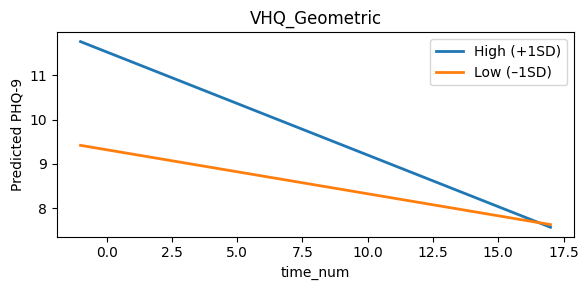

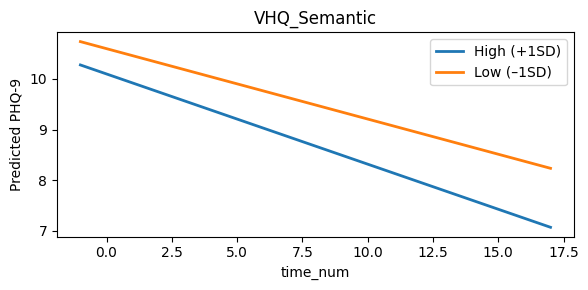

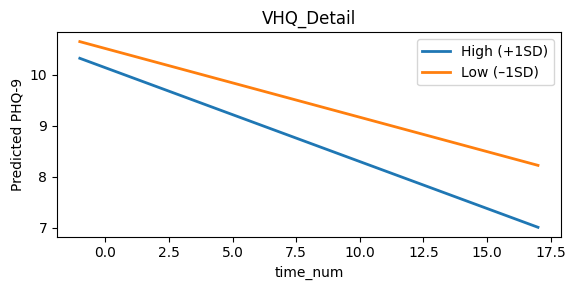

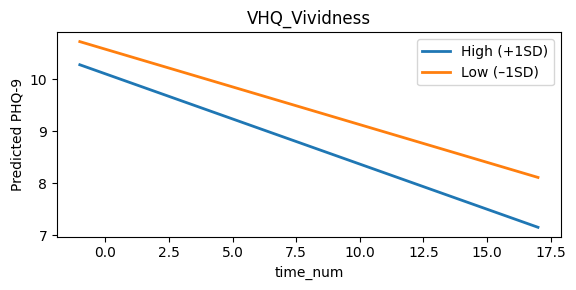

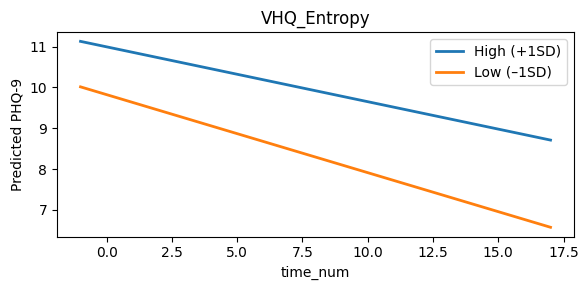

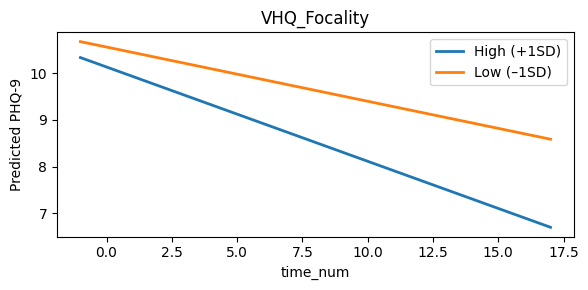

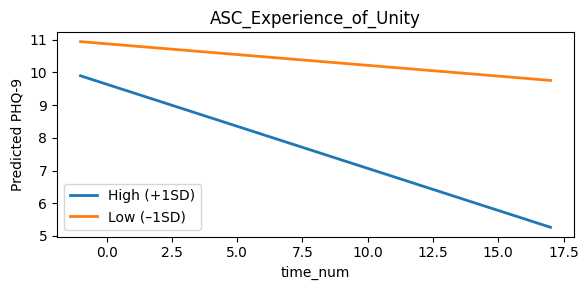

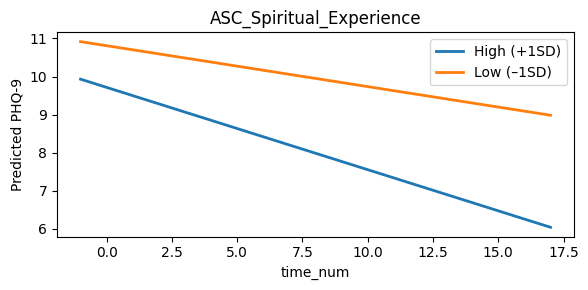

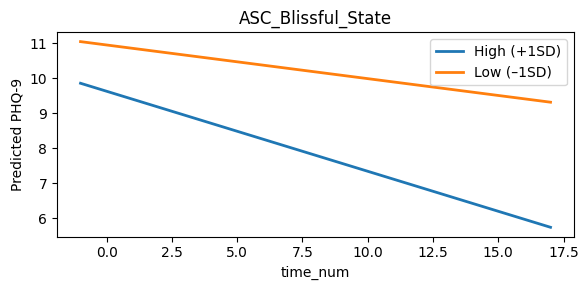

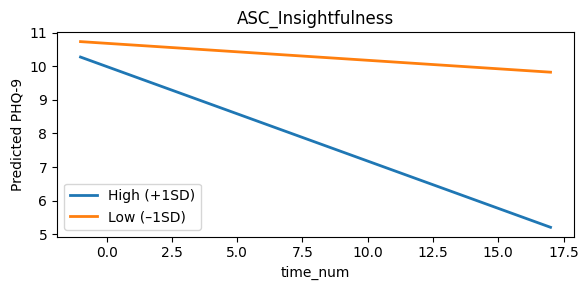

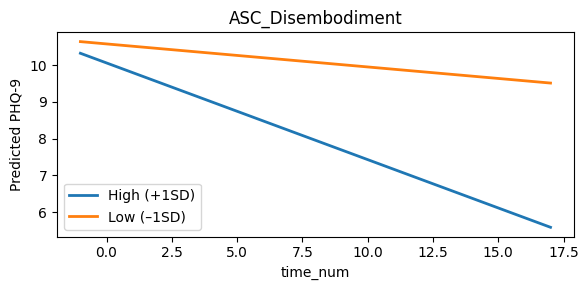

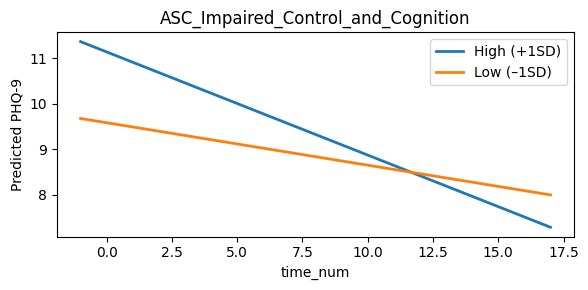

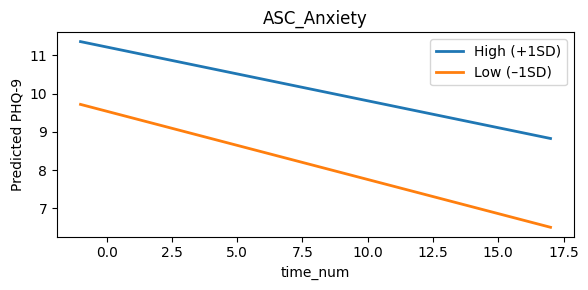

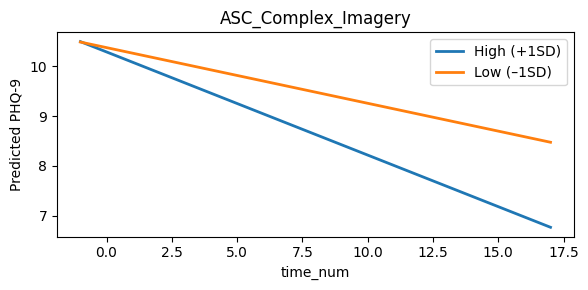

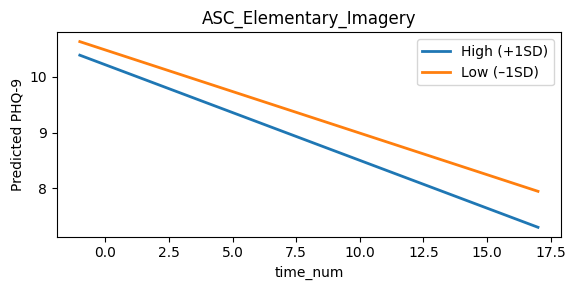

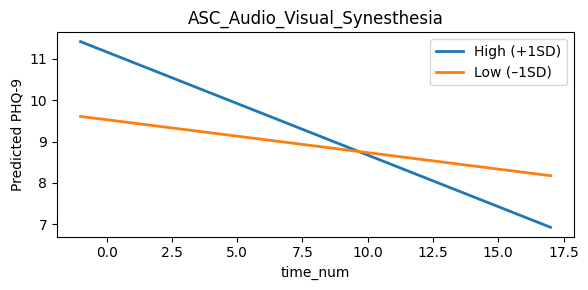

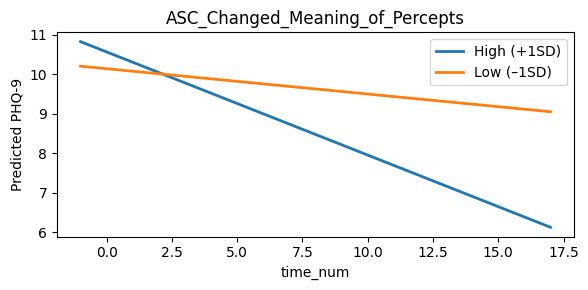

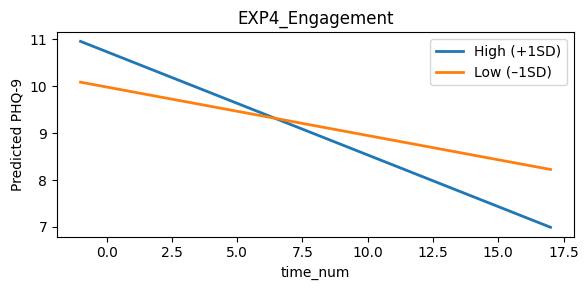

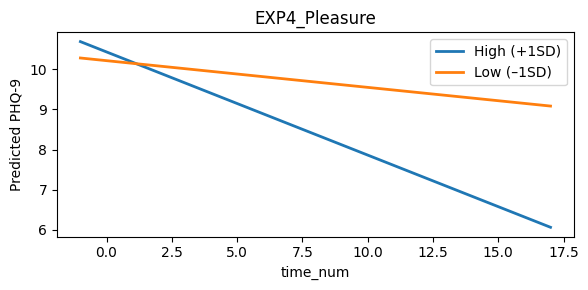

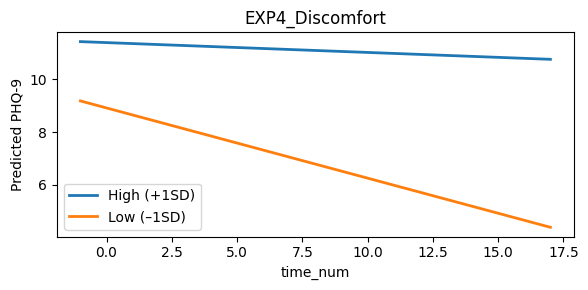

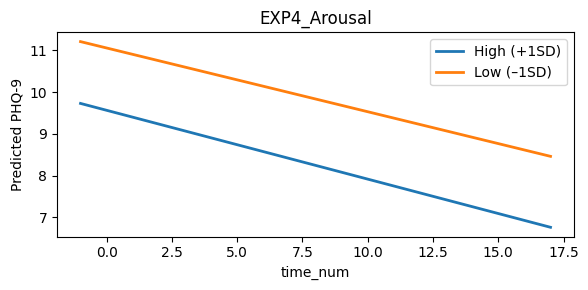

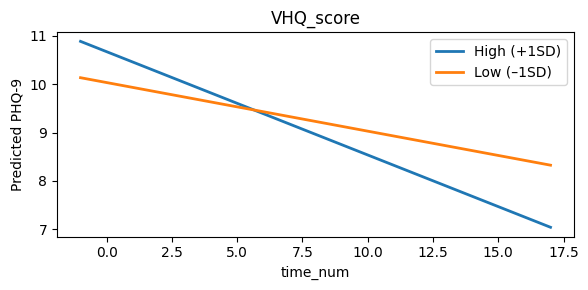

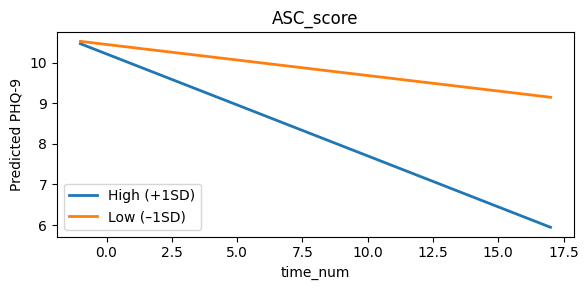

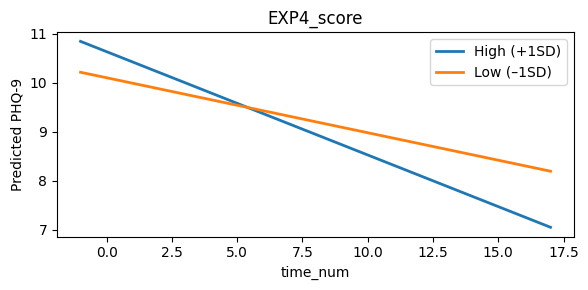


Moderator × Time effects:

                         Moderator      Coef  p-value
                     VHQ_Geometric -0.091684 0.021955
                      VHQ_Semantic -0.019923 0.538449
                        VHQ_Detail -0.029622 0.449061
                     VHQ_Vividness -0.023864 0.655371
                       VHQ_Entropy  0.037531 0.386988
                      VHQ_Focality -0.088926 0.156395
           ASC_Experience_of_Unity -0.004223 0.002554
          ASC_Spiritual_Experience -0.003005 0.070433
                ASC_Blissful_State -0.002890 0.033040
                ASC_Insightfulness -0.005013 0.000220
                 ASC_Disembodiment -0.003826 0.001332
ASC_Impaired_Control_and_Cognition -0.004989 0.033642
                       ASC_Anxiety  0.001602 0.558145
               ASC_Complex_Imagery -0.002753 0.108064
            ASC_Elementary_Imagery -0.000539 0.717614
      ASC_Audio_Visual_Synesthesia -0.003305 0.005515
   ASC_Changed_Meaning_of_Percepts -0.005407 0.001110


Moderator      Coef   p-value
0                        VHQ_Geometric -0.091684  0.021955
1                         VHQ_Semantic -0.019923  0.538449
2                           VHQ_Detail -0.029622  0.449061
3                        VHQ_Vividness -0.023864  0.655371
4                          VHQ_Entropy  0.037531  0.386988
5                         VHQ_Focality -0.088926  0.156395
6              ASC_Experience_of_Unity -0.004223  0.002554
7             ASC_Spiritual_Experience -0.003005  0.070433
8                   ASC_Blissful_State -0.002890  0.033040
9                   ASC_Insightfulness -0.005013  0.000220
10                   ASC_Disembodiment -0.003826  0.001332
11  ASC_Impaired_Control_and_Cognition -0.004989  0.033642
12                         ASC_Anxiety  0.001602  0.558145
13                 ASC_Complex_Imagery -0.002753  0.108064
14              ASC_Elementary_Imagery -0.000539  0.717614
15        ASC_Audio_Visual_Synesthesia -0.003305  0.005515
16     ASC_Changed_Meaning_of_Percepts -0.005407  0.001110
17                     EXP4_Engagement -0.002816  0.060207
18                       EXP4_Pleasure -0.005080  0.001691
19                     EXP4_Discomfort  0.008404  0.000777
20                        EXP4_Arousal -0.000265  0.856513
21                           VHQ_score -0.173003  0.078109
22                           ASC_score -0.005737  0.003583
23                          EXP4_score -0.005571  0.094885

In [41]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from pathlib import Path
from IPython.display import display

# ─── 0) SETTINGS ──────────────────────────────────────────────────────────
DATA_DIR = Path('/content')

# ─── 1) CSV LOADER UTILITIES ──────────────────────────────────────────────
def find_csv(substring: str) -> Path:
    matches = list(DATA_DIR.glob(f'*{substring}*.csv'))
    if not matches:
        raise FileNotFoundError(f"No file matching '{substring}' in {DATA_DIR}")
    if len(matches) > 1:
        raise ValueError(f"Multiple files match '{substring}': {matches}")
    return matches[0]

def try_load(substring: str) -> pd.DataFrame | None:
    try:
        p = find_csv(substring)
    except (FileNotFoundError, ValueError) as e:
        print(f"Skipping '{substring}': {e}")
        return None
    print(f"Loaded '{substring}' from {p.name}")
    return pd.read_csv(p, dtype=str)

# ─── 2) LOAD WELLBEING & SMS CSVs ─────────────────────────────────────────
df_s1_pre     = try_load('pre_session_1')
df_s2to4_pre  = try_load('pre_sessions_2-4')
df_s2to4_post = try_load('post_sessions_1-3')
df_s4_post    = try_load('post_session_4')
df_sms        = try_load('sms_day1,3,5')
if df_sms is not None:
    df_sms['part_id'] = df_sms['part_id'].astype(str).str.strip().str[:5]
    print("Trimmed df_sms.part_id")
df_final      = try_load('sms_post')

all_wb = [df for df in (df_s1_pre, df_s2to4_pre, df_s2to4_post, df_s4_post, df_sms, df_final) if df is not None]
if not all_wb:
    raise RuntimeError("No wellbeing/SMS files found")

# ─── 3) CLEAN & SUM SCALES ────────────────────────────────────────────────
def sum_scale(df, cols, out):
    df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')
    df[out]  = df[cols].sum(axis=1)

def get_scale_cols(df, prefix, n, allow_suffix=False):
    cols=[]
    for i in range(1, n+1):
        m,a = f"{prefix}_{i}", f"{prefix}_{i}_1"
        if m in df.columns: cols.append(m)
        elif allow_suffix and a in df.columns: cols.append(a)
    return cols

for df in all_wb:
    df.columns = df.columns.str.strip()
    # BDI items
    for c in df.columns:
        if re.fullmatch(r"bdi_\d+(?:_1)?", c):
            df[c] = pd.to_numeric(df[c].astype(str).str.extract(r"^(\d+)")[0], errors='coerce')
    # sum BAI, BDI, MADRS
    for pref,cnt,suf,out in [
        ('bai',21,False,'bai_sum'),
        ('bdi',21,False,'bdi_sum'),
        ('madrs',9, True,'MADRS_S_sum')
    ]:
        cols = get_scale_cols(df, pref, cnt, allow_suffix=suf)
        if cols:
            sum_scale(df, cols, out)
    # standardize m3vas
    for var in ('mood','pleasure','suicidal'):
        raw = next((c for c in df if re.fullmatch(f"m3vas_{var}(?:_1)?", c)), None)
        ch  = next((c for c in df if re.fullmatch(f"m3vas_ch_{var}(?:_1)?", c)), None)
        if var=='suicidal':
            if raw: df['m3vas_suicidal'] = pd.to_numeric(df[raw], errors='coerce') - 50
            elif ch: df['m3vas_suicidal'] = pd.to_numeric(df[ch], errors='coerce') - 50
        else:
            if raw: df[f"m3vas_{var}"] = 50 - pd.to_numeric(df[raw], errors='coerce')
            elif ch: df[f"m3vas_{var}"] = pd.to_numeric(df[ch], errors='coerce') - 50
    df.drop(columns=[c for c in df if re.fullmatch(r"m3vas_(?:ch_)?(?:mood|pleasure|suicidal)(?:_1)?",c)],
            errors='ignore', inplace=True)
    # fisber
    for c in ('fisber_1','fisber_2','fisber_3'):
        if c in df.columns:
            df[c] = pd.to_numeric(df[c].astype(str).str.extract(r"(\d+)$")[0], errors='coerce')
    # other numeric
    for c in ['phq9_sum','spane_p','spane_n',
              'm3vas_mood','m3vas_pleasure','m3vas_suicidal',
              'fisber_1','fisber_2','fisber_3',
              'bai_sum','bdi_sum','MADRS_S_sum']:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors='coerce')

# ─── 4) TAG & BUILD df_model ─────────────────────────────────────────────
for df in all_wb:
    if 'part_id' not in df.columns and 'ProlificID' in df.columns:
        df.rename(columns={'ProlificID':'part_id'}, inplace=True)
    df['part_id'] = df['part_id'].astype(str).str.strip()

if df_s1_pre     is not None: df_s1_pre['timepoint']     = 'session1_pre'
if df_s2to4_pre  is not None: df_s2to4_pre ['timepoint'] = df_s2to4_pre.apply(lambda r: f"session{r.session_n}_pre", axis=1)
if df_s2to4_post is not None: df_s2to4_post['timepoint'] = df_s2to4_post.apply(lambda r: f"session{r.session_n}_post",axis=1)
if df_s4_post    is not None: df_s4_post   ['timepoint'] = 'session4_post'
if df_sms        is not None: df_sms       ['timepoint'] = df_sms.apply(lambda r: f"SMS_{r.session_n}_{r.sms_n}",axis=1)
if df_final      is not None: df_final     ['timepoint'] = 'final_post'

df_long = pd.concat(all_wb, ignore_index=True)
df_long = df_long[df_long['part_id'].str.match(r'^\d+$', na=False)].copy()

df_assign = try_load('wp2_assignments')
if df_assign is not None:
    df_long = df_long.merge(df_assign[['part_id','condition']],
                            on='part_id', how='left')

ordered = [
    'session1_pre','session1_post',
    'SMS_1_1','SMS_1_2','SMS_1_3',
    'session2_pre','session2_post',
    'SMS_2_1','SMS_2_2','SMS_2_3',
    'session3_pre','session3_post',
    'SMS_3_1','SMS_3_2','SMS_3_3',
    'session4_pre','session4_post',
    'final_post'
]
df_long['timepoint'] = pd.Categorical(df_long['timepoint'], categories=ordered, ordered=True)
df_long['time_num']  = df_long['timepoint'].cat.codes
df_model = df_long.loc[~df_long['timepoint'].astype(str).str.match(r'^session\d+_post$')].copy()
df_model['tc'] = df_model['time_num'] - df_model['time_num'].mean()
df_model = df_model.dropna(subset=['phq9_sum','tc']).reset_index(drop=True)

# ─── 5) DEFINE VHQ, EXP4 & ASC_11D ───────────────────────────────────────
VHQ_DEFS = {
    "Geometric": ['6d_vhq_1','6d_vhq_2','6d_vhq_3'],
    "Semantic":  ['6d_vhq_4','6d_vhq_5','6d_vhq_6'],
    "Detail":    ['6d_vhq_7','6d_vhq_8','6d_vhq_9'],
    "Vividness": ['6d_vhq_10','6d_vhq_11','6d_vhq_12'],
    "Entropy":   ['6d_vhq_13','6d_vhq_14','6d_vhq_15'],
    "Focality":  ['6d_vhq_16','6d_vhq_17','6d_vhq_18'],
}
EXP4_DEFS = ['exp4_engagement_1','exp4_pleasure_1','exp4_discomfort_1','exp4_arousal_1']

asc_defs = {
    "Experience_of_Unity": [
        'asc_18_4','asc_34_4','asc_41_4','asc_42_4','asc_52_4'
    ],
    "Spiritual_Experience": [
        'asc_9_4','asc_81_4','asc_94_4'
    ],
    "Blissful_State": [
        'asc_12_4','asc_86_4','asc_91_4'
    ],
    "Insightfulness": [
        'asc_50_4','asc_69_4','asc_77_4'      # asc_72_4 is Visionary, not Insight
    ],
    "Disembodiment": [
        'asc_26_4','asc_62_4','asc_63_4'
    ],
    "Impaired_Control_and_Cognition": [
        'asc_8_4','asc_27_4','asc_38_4','asc_47_4','asc_64_4','asc_67_4','asc_78_4'
    ],
    "Anxiety": [
        'asc_32_4','asc_43_4','asc_44_4','asc_46_4','asc_56_4','asc_89_4'
    ],
    "Complex_Imagery": [
        'asc_39_4','asc_72_4','asc_82_4'
    ],
    "Elementary_Imagery": [
        'asc_14_4','asc_22_4','asc_33_4'
    ],
    "Audio_Visual_Synesthesia": [
        'asc_20_4','asc_23_4','asc_75_4'
    ],
    "Changed_Meaning_of_Percepts": [
        'asc_28_4','asc_31_4','asc_54_4'
    ]
}

# ─── 6) LOAD ITEMS & COMPUTE MODERATORS ─────────────────────────────────
import re
import numpy as np

df_it1 = try_load('post_sessions_1-3')
df_it2 = try_load('post_session_4')
df_it1 = df_it1.iloc[1:].copy() if df_it1 is not None else pd.DataFrame()
df_it2 = df_it2.iloc[1:].copy() if df_it2 is not None else pd.DataFrame()
if not df_it2.empty:
    df_it2['session_n'] = 4

df_items = pd.concat([df_it1, df_it2], ignore_index=True)
df_items['part_id'] = df_items['part_id'].astype(str)

def extract_num(x):
    m = re.search(r'(\d+)$', str(x).strip())
    return float(m.group(1)) if m else np.nan

# numeric conversion for all item cols
for col in sum(VHQ_DEFS.values(), []) + sum(asc_defs.values(), []) + EXP4_DEFS:
    if col in df_items.columns:
        df_items[col] = df_items[col].apply(extract_num)

# ─── 6.1) REVERSE‑CODE VIVIDNESS ITEMS (1–5 scale) ─────────────────────────
# (max + min = 5 + 1 = 6)
for col in VHQ_DEFS['Vividness']:
    if col in df_items.columns:
        df_items[col] = 6 - df_items[col]

# now compute your per‑participant moderators
records = []
for (pid, sess), grp in df_items.groupby(['part_id', 'session_n']):
    rec = {'part_id': pid}
    # VHQ subscales (using reversed vividness)
    for nm, cols in VHQ_DEFS.items():
        present = [c for c in cols if c in grp]
        rec[f'VHQ_{nm}'] = grp[present].mean(axis=1).mean() if present else np.nan
    # ASC 11D subscales
    for nm, cols in asc_defs.items():
        present = [c for c in cols if c in grp]
        rec[f'ASC_{nm}'] = grp[present].mean(axis=1).mean() if present else np.nan
    # EXP4 scales
    for col in EXP4_DEFS:
        if col in grp:
            key = col.replace('exp4_', '').replace('_1', '').capitalize()
            rec[f'EXP4_{key}'] = grp[col].mean()
        else:
            rec[f'EXP4_{col}'] = np.nan
    records.append(rec)

df_scores = pd.DataFrame(records)

# aggregate across sessions to get participant‑level moderators
df_partmods = df_scores.groupby('part_id').mean(numeric_only=True).reset_index()
df_partmods['VHQ_score']  = df_partmods.filter(like='VHQ_').mean(axis=1)
df_partmods['ASC_score']  = df_partmods.filter(like='ASC_').mean(axis=1)
df_partmods['EXP4_score'] = df_partmods.filter(like='EXP4_').mean(axis=1)

# ─── 7) MERGE & FIT MODELS ───────────────────────────────────────────────
df_model = df_model.merge(df_partmods, on='part_id', how='left')
results=[]

mods = [c for c in df_partmods.columns if c!='part_id']
for mod in mods:
    sub = df_model.dropna(subset=[mod]).copy()
    if sub.empty:
        results.append((mod,np.nan,np.nan)); continue
    sub[f'{mod}_c'] = sub[mod] - sub[mod].mean()
    sd = sub[mod].std()
    try:
        mdl = smf.mixedlm(f"phq9_sum ~ tc * {mod}_c", sub,
                          groups='part_id', re_formula='~1')
        res = mdl.fit(method='lbfgs', reml=True)
    except Exception as e:
        print(f"Skipping {mod}: {e}")
        results.append((mod,np.nan,np.nan)); continue
    coef = res.params.get(f'tc:{mod}_c',np.nan)
    pval = res.pvalues.get(f'tc:{mod}_c',np.nan)
    results.append((mod,coef,pval))
    # plot ±1SD
    tvals = sorted(sub['time_num'].unique()); mt=sub['time_num'].mean()
    grid = pd.DataFrame({
        'time_num': np.tile(tvals,2),
        'tc':        np.tile(tvals-mt,2),
        f'{mod}_c':  np.repeat([sd,-sd],len(tvals)),
        'part_id':   sub['part_id'].iloc[0]
    })
    grid['pred']=res.predict(grid)
    plt.figure(figsize=(6,3))
    for val,lbl,col in zip([sd,-sd],['High (+1SD)','Low (–1SD)'],['tab:blue','tab:orange']):
        d=grid[grid[f'{mod}_c']==val]
        plt.plot(d['time_num'],d['pred'],color=col,lw=2,label=lbl)
    plt.title(mod); plt.xlabel("time_num"); plt.ylabel("Predicted PHQ‑9")
    plt.legend(); plt.tight_layout(); plt.show()

# ─── 8) DISPLAY RESULTS ──────────────────────────────────────────────────
df_results=pd.DataFrame(results,columns=['Moderator','Coef','p-value'])
print("\nModerator × Time effects:\n"); print(df_results.to_string(index=False))
print("\nFormatted:"); display(df_results)

In [42]:
# — assume df_results exists with columns ['Moderator','Coef','p-value']

# 1) filter for p < .05
sig_df = df_results[df_results['p-value'] < 0.05].copy()

# 2) sort by p‑value (optional)
sig_df = sig_df.sort_values('p-value')

# 3) round for readability
sig_df['Coef']    = sig_df['Coef'].round(4)
sig_df['p-value'] = sig_df['p-value'].round(4)

# 4) display
print("Significant Moderator × Time interactions (p < .05):")
print(sig_df.to_string(index=False))

Significant Moderator × Time interactions (p < .05):
                         Moderator    Coef  p-value
                ASC_Insightfulness -0.0050   0.0002
                   EXP4_Discomfort  0.0084   0.0008
   ASC_Changed_Meaning_of_Percepts -0.0054   0.0011
                 ASC_Disembodiment -0.0038   0.0013
                     EXP4_Pleasure -0.0051   0.0017
           ASC_Experience_of_Unity -0.0042   0.0026
                         ASC_score -0.0057   0.0036
      ASC_Audio_Visual_Synesthesia -0.0033   0.0055
                     VHQ_Geometric -0.0917   0.0220
                ASC_Blissful_State -0.0029   0.0330
ASC_Impaired_Control_and_Cognition -0.0050   0.0336


In [43]:
# assuming df_partmods and df_results exist:
sd = df_partmods.set_index('part_id').std()
per_sd = []
for mod, coef, p in df_results.itertuples(index=False):
    # skip non‑numeric or p>=.05 if you like
    if mod in sd.index:
        per_sd.append((mod, coef * sd[mod]))
per_sd_df = pd.DataFrame(per_sd, columns=['Moderator','Coef_per_1SD'])
print(per_sd_df.round(4))

                             Moderator  Coef_per_1SD
0                        VHQ_Geometric       -0.0725
1                         VHQ_Semantic       -0.0221
2                           VHQ_Detail       -0.0263
3                        VHQ_Vividness       -0.0149
4                          VHQ_Entropy        0.0299
5                         VHQ_Focality       -0.0416
6              ASC_Experience_of_Unity       -0.0984
7             ASC_Spiritual_Experience       -0.0525
8                   ASC_Blissful_State       -0.0679
9                   ASC_Insightfulness       -0.1250
10                   ASC_Disembodiment       -0.1009
11  ASC_Impaired_Control_and_Cognition       -0.0674
12                         ASC_Anxiety        0.0183
13                 ASC_Complex_Imagery       -0.0470
14              ASC_Elementary_Imagery       -0.0111
15        ASC_Audio_Visual_Synesthesia       -0.0865
16     ASC_Changed_Meaning_of_Percepts       -0.0965
17                     EXP4_Engagement       -

In [44]:
import numpy as np
import pandas as pd
from scipy import stats

# 1) Reload or reuse your assignments file to get each part_id→condition
assign = pd.read_csv('/content/wp2_assignments.csv', dtype=str)
assign = assign[['part_id','condition']]

# 2) Merge condition into df_partmods
df_comp = df_partmods.merge(assign, on='part_id', how='left')

# 3) Define which composites to test
cols = ['VHQ_score','ASC_score','EXP4_score']
df_comp = df_comp.dropna(subset=cols + ['condition'])

# 4) Run Welch’s t‑tests
results = []
for col in cols:
    ctrl = df_comp.loc[df_comp['condition']=='control', col]
    intv = df_comp.loc[df_comp['condition']=='intervention', col]
    tstat, pval = stats.ttest_ind(ctrl, intv, equal_var=False, nan_policy='omit')
    results.append({
        'Composite':            col,
        'Control Mean (SD)':    f"{ctrl.mean():.2f} ({ctrl.std():.2f})",
        'Intervention Mean (SD)': f"{intv.mean():.2f} ({intv.std():.2f})",
        't‑stat':               f"{tstat:.2f}",
        'p‑value':              f"{pval:.3f}"
    })

# 5) Display results
res_df = pd.DataFrame(results)
print("Group Comparisons of Composite Scores by Condition (Welch’s t‑test):")
print(res_df.to_string(index=False))

Group Comparisons of Composite Scores by Condition (Welch’s t‑test):
 Composite Control Mean (SD) Intervention Mean (SD) t‑stat p‑value
 VHQ_score       3.08 (0.26)            3.25 (0.32)  -1.80   0.082
 ASC_score     35.48 (10.53)          34.46 (18.06)   0.21   0.837
EXP4_score      52.77 (6.95)          51.44 (14.66)   0.35   0.728


In [45]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf

# ─── 1) DEFINE & ALIGN MODERATOR NAMES ───────────────────────────────────
# VHQ keys (already uppercase)
vhq_mods  = [f"VHQ_{nm}" for nm in VHQ_DEFS.keys()]
# ASC keys
asc_mods  = [f"ASC_{nm}" for nm in asc_defs.keys()]
# EXP4 keys: strip both prefix and trailing '_1', then title‑case
exp4_mods = [f"EXP4_{col.replace('exp4_','').replace('_1','').capitalize()}"
             for col in EXP4_DEFS]
# Composite scores
comp_mods = ['VHQ_score','ASC_score','EXP4_score']

moderators = vhq_mods + asc_mods + exp4_mods + comp_mods

# ─── 2) CENTER EACH MODERATOR ─────────────────────────────────────────────
for mod in moderators:
    df_model[f"{mod}_c"] = df_model[mod] - df_model[mod].mean()

# ─── 3) LOOP & FIT 3‑WAY MODELS ───────────────────────────────────────────
results = []
for mod in moderators:
    formula = f"phq9_sum ~ tc * condition * {mod}_c"
    sub = df_model.dropna(subset=[f"{mod}_c",'phq9_sum','tc','condition'])
    try:
        m3 = smf.mixedlm(
            formula,
            data=sub,
            groups='part_id',
            re_formula='~1'
        ).fit(method='lbfgs')
        coef = m3.params.get(f"tc:condition[T.intervention]:{mod}_c", np.nan)
        pval = m3.pvalues.get(f"tc:condition[T.intervention]:{mod}_c", np.nan)
    except Exception:
        coef, pval = np.nan, np.nan
    results.append({'Moderator':mod,'3way_Coef':coef,'3way_p':pval})

# ─── 4) SUMMARIZE ─────────────────────────────────────────────────────────
res_df = pd.DataFrame(results)
res_df = res_df.sort_values('3way_p').reset_index(drop=True)
res_df[['3way_Coef','3way_p']] = res_df[['3way_Coef','3way_p']].round(4)

print("Three‑Way (tc × condition × moderator) Interaction Results:\n")
print(res_df.to_string(index=False))

Three‑Way (tc × condition × moderator) Interaction Results:

                         Moderator  3way_Coef  3way_p
                     VHQ_Vividness     0.3245  0.0034
                      VHQ_Focality    -0.3511  0.0068
ASC_Impaired_Control_and_Cognition     0.0108  0.0727
                     VHQ_Geometric    -0.1423  0.1275
          ASC_Spiritual_Experience    -0.0049  0.1441
               ASC_Complex_Imagery     0.0043  0.2018
                     EXP4_Pleasure    -0.0037  0.2576
                         ASC_score     0.0051  0.2630
                 ASC_Disembodiment     0.0026  0.2966
                   EXP4_Engagement    -0.0031  0.3628
                ASC_Blissful_State     0.0022  0.4252
                        EXP4_score    -0.0061  0.4621
   ASC_Changed_Meaning_of_Percepts     0.0024  0.5095
                ASC_Insightfulness     0.0017  0.5537
                   EXP4_Discomfort     0.0029  0.5763
            ASC_Elementary_Imagery    -0.0015  0.6019
                     

VHQ_score ↔ ASC_score:  r = 0.37, p = 0.019


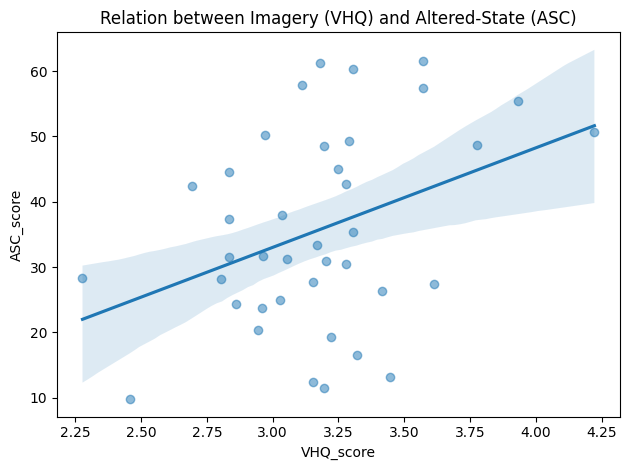

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# 1a) Correlation between composites
r, p = pearsonr(df_partmods['VHQ_score'].dropna(), df_partmods['ASC_score'].dropna())
print(f"VHQ_score ↔ ASC_score:  r = {r:.2f}, p = {p:.3f}")

# 1b) Scatterplot
sns.regplot(x='VHQ_score', y='ASC_score', data=df_partmods, scatter_kws={'alpha':0.5})
plt.xlabel("VHQ_score")
plt.ylabel("ASC_score")
plt.title("Relation between Imagery (VHQ) and Altered‑State (ASC)")
plt.tight_layout()
plt.show()

In [47]:
import pandas as pd
import statsmodels.formula.api as smf

# 1) Read in assignments & merge
assign = pd.read_csv('/content/wp2_assignments.csv', dtype=str)[['part_id','condition']]
df_pm  = df_partmods.merge(assign, on='part_id', how='left')

# 2) Center composites
df_pm['VHQ_c'] = df_pm['VHQ_score'] - df_pm['VHQ_score'].mean()
df_pm['ASC_c'] = df_pm['ASC_score'] - df_pm['ASC_score'].mean()

# 3) Drop missing
d = df_pm.dropna(subset=['VHQ_c','ASC_c','condition'])

# 4) Fit OLS: does imagery (VHQ) predict ASC, and does that differ by condition?
m = smf.ols("ASC_c ~ VHQ_c * condition", data=d).fit()
print(m.summary())

                            OLS Regression Results                            
Dep. Variable:                  ASC_c   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     2.003
Date:                Tue, 29 Jul 2025   Prob (F-statistic):              0.134
Time:                        08:20:03   Log-Likelihood:                -140.58
No. Observations:                  35   AIC:                             289.2
Df Residuals:                      31   BIC:                             295.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

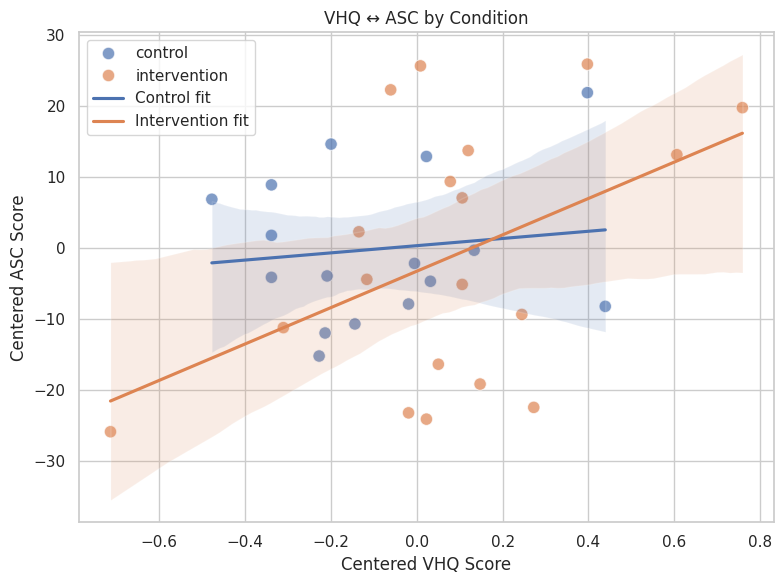

In [48]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Merge in condition
assign = pd.read_csv('/content/wp2_assignments.csv', dtype=str)[['part_id','condition']]
df_pm = df_partmods.merge(assign, on='part_id', how='left')

# 2) Center composites
df_pm['VHQ_c'] = df_pm['VHQ_score'] - df_pm['VHQ_score'].mean()
df_pm['ASC_c'] = df_pm['ASC_score'] - df_pm['ASC_score'].mean()

# 3) Drop missing
plot_df = df_pm.dropna(subset=['VHQ_c','ASC_c','condition'])

# 4) Plot
sns.set(style="whitegrid")
plt.figure(figsize=(8,6))
# raw points
sns.scatterplot(
    data=plot_df,
    x='VHQ_c', y='ASC_c',
    hue='condition', palette='deep', s=80, alpha=0.7
)
# control fit
sns.regplot(
    data=plot_df[plot_df['condition']=='control'],
    x='VHQ_c', y='ASC_c',
    scatter=False, label='Control fit',
    color=sns.color_palette('deep')[0]
)
# intervention fit
sns.regplot(
    data=plot_df[plot_df['condition']=='intervention'],
    x='VHQ_c', y='ASC_c',
    scatter=False, label='Intervention fit',
    color=sns.color_palette('deep')[1]
)
plt.xlabel("Centered VHQ Score")
plt.ylabel("Centered ASC Score")
plt.title("VHQ ↔ ASC by Condition")
plt.legend()
plt.tight_layout()
plt.show()

In [49]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.stats import norm

# 1) Estimate each participant’s PHQ‑9 slope via OLS of phq9_sum ~ time_num
slopes = []
for pid, grp in df_model.groupby('part_id'):
    if grp['time_num'].nunique() < 2:
        continue
    X = sm.add_constant(grp['time_num'])
    ols = sm.OLS(grp['phq9_sum'], X).fit()
    slopes.append({'part_id': pid, 'phq_slope': ols.params['time_num']})
df_slopes = pd.DataFrame(slopes)

# 2) Merge in mediator (ASC_score) and condition
assign    = pd.read_csv('/content/wp2_assignments.csv', dtype=str)[['part_id','condition']]
df_med    = df_slopes.merge(df_partmods[['part_id','ASC_score']], on='part_id')
df_med    = df_med.merge(assign, on='part_id')
df_med['cond_num'] = (df_med['condition']=='intervention').astype(int)

# 3) Path a: condition → mediator
Ma = sm.OLS(df_med['ASC_score'], sm.add_constant(df_med['cond_num'])).fit()
a_coef, sa = Ma.params['cond_num'], Ma.bse['cond_num']

# 4) Path b (+ c′): slope ~ mediator + condition
Mb = sm.OLS(df_med['phq_slope'],
            sm.add_constant(df_med[['ASC_score','cond_num']])
           ).fit()
b_coef, sb = Mb.params['ASC_score'], Mb.bse['ASC_score']
cprime, sc = Mb.params['cond_num'], Mb.bse['cond_num']

# 5) Sobel test (indirect = a*b)
indirect = a_coef * b_coef
se_ind   = np.sqrt(a_coef**2 * sb**2 + b_coef**2 * sa**2)
z_val    = indirect / se_ind
p_val    = 2*(1 - norm.cdf(abs(z_val)))

# 6) Report
print("Path a (cond → ASC):    coef = {:.3f}, SE = {:.3f}, p = {:.3f}"
      .format(a_coef, sa, Ma.pvalues['cond_num']))
print("Path b (ASC → slope):   coef = {:.3f}, SE = {:.3f}, p = {:.3f}"
      .format(b_coef, sb, Mb.pvalues['ASC_score']))
print("Direct c′ (cond → slope): coef = {:.3f}, SE = {:.3f}, p = {:.3f}"
      .format(cprime, sc, Mb.pvalues['cond_num']))
print("Indirect a×b:           {:.4f}".format(indirect))
print("Sobel z = {:.3f}, p = {:.3f}".format(z_val, p_val))

Path a (cond → ASC):    coef = -0.176, SE = 5.185, p = 0.973
Path b (ASC → slope):   coef = -0.005, SE = 0.004, p = 0.204
Direct c′ (cond → slope): coef = -0.072, SE = 0.122, p = 0.558
Indirect a×b:           0.0009
Sobel z = 0.034, p = 0.973


NARRATIVE SUMMARIZER

Two‑way moderators (p<.05):


Moderator    Coef  p-value
3                        VHQ_Vividness -0.1779   0.0393
9                   ASC_Insightfulness -0.0053   0.0200
10                   ASC_Disembodiment -0.0053   0.0090
11  ASC_Impaired_Control_and_Cognition -0.0139   0.0112
13                 ASC_Complex_Imagery -0.0052   0.0300
16     ASC_Changed_Meaning_of_Percepts -0.0067   0.0309
22                           ASC_score -0.0092   0.0201

Three‑way moderators (p<.05):


Moderator  3way_Coef  3way_p
3  VHQ_Vividness     0.3245  0.0034
5   VHQ_Focality    -0.3511  0.0068

Imagery ↔ ASC: r=0.33, p=0.055


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  ASC_c   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     2.003
Date:                Tue, 29 Jul 2025   Prob (F-statistic):              0.134
Time:                        08:20:28   Log-Likelihood:                -140.58
No. Observations:                  35   AIC:                             289.2
Df Residuals:                      31   BIC:                             295.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                           1.0352      3.816      0.271      0.788      -6.748       8.818
condition[T.intervention]          -3.5501      5.100     -0.696      0.492     -13.951       6.850
VHQ_c                               5.0669     14.230      0.356      0.724     -23.955      34.089
VHQ_c:condition[T.intervention]    20.5235     17.740      1.157      0.256     -15.657      56.704
==============================================================================
Omnibus:                        0.542   Durbin-Watson:                   2.053
Prob(Omnibus):                  0.763   Jarque-Bera (JB):                0.664
Skew:                           0.178   Prob(JB):                        0.717
Kurtosis:                       2.427   Cond. No.                         10.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Mediation (Sobel): z=0.03, p=0.973
Growth model fixed effects:
                               Coef. Std.Err.       z  P>|z|  [0.025  0.975]
Intercept                     10.076    1.199   8.402  0.000   7.725  12.426
condition[T.intervention]     -1.513    1.628  -0.929  0.353  -4.704   1.678
tc                            -0.107    0.047  -2.251  0.024  -0.200  -0.014
tc:condition[T.intervention]  -0.078    0.062  -1.257  0.209  -0.200   0.044
part_id Var                   22.013    2.143                               
Interaction test: β_diff=-0.0782, SE=0.0622, z=-1.2570, p=0.2088


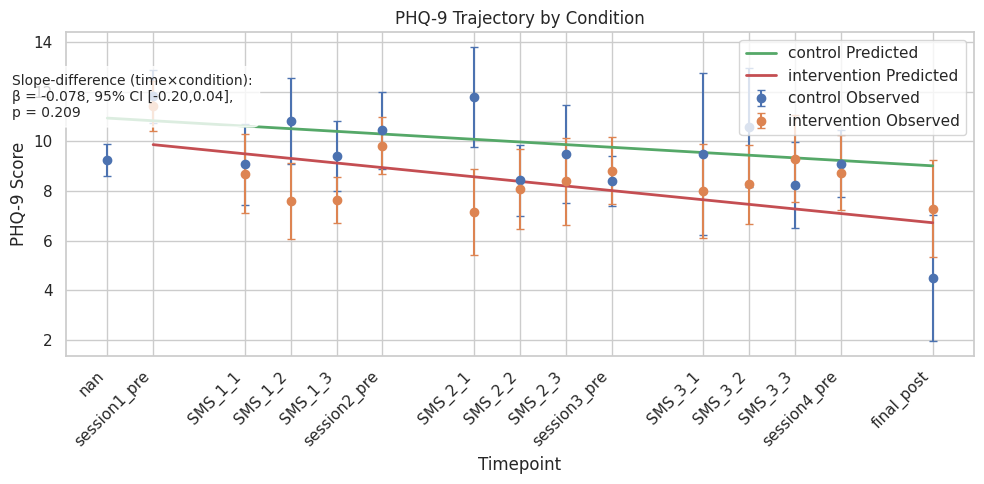

In [50]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from pathlib import Path
from scipy import stats
from scipy.stats import norm
from IPython.display import display

# ─── 0) SETTINGS, PATHS & UTILITY FUNCTIONS ─────────────────────────────────
DATA_DIR = Path('/content')

def find_csv(substring: str) -> Path:
    matches = list(DATA_DIR.glob(f'*{substring}*.csv'))
    if not matches:
        raise FileNotFoundError(f"No file matching '{substring}' in {DATA_DIR}")
    if len(matches) > 1:
        raise ValueError(f"Multiple files match '{substring}': {matches}")
    return matches[0]

# Define key files
POST13 = find_csv('post_sessions_1-3')
POST4  = find_csv('post_session_4')

data_files = {
    'pre1':     'pre_session_1',
    'pre2to4':  'pre_sessions_2-4',
    'post1to3': 'post_sessions_1-3',
    'post4':    'post_session_4',
    'sms':      'sms_day1,3,5',
    'sms_post': 'sms_post',
    'signup':   'sign_up',
    'retention':'retention',
    'demo':     'demographics',
    'assign':   'wp2_assignments'
}

# Load all dataframes
dfs = {}
for key, name in data_files.items():
    try:
        dfs[key] = pd.read_csv(find_csv(name), dtype=str)
    except Exception:
        dfs[key] = None

(df_s1_pre, df_s2to4_pre, df_s2to4_post, df_s4_post,
 df_sms, df_final, df_signup, df_retention,
 df_demo, df_assign) = (
    dfs['pre1'], dfs['pre2to4'], dfs['post1to3'], dfs['post4'],
    dfs['sms'], dfs['sms_post'], dfs['signup'], dfs['retention'],
    dfs['demo'], dfs['assign']
)

# ─── 1) RETENTION & DEMOGRAPHIC SUMMARIES ───────────────────────────────────
if df_retention is not None:
    df_retention['attended'] = df_retention['attended'].astype(int)
    retention = df_retention.groupby('session_n')['attended'].mean().reset_index()
    print("Retention rates by session:")
    display(retention)

if df_demo is not None:
    df_demo['age'] = pd.to_numeric(df_demo['age'], errors='coerce')
    print("Demographics summary:")
    display(df_demo[['age','gender']].describe(include='all'))

# ─── 2) CLEAN WELLBEING & SMS DATA ───────────────────────────────────────────
def sum_scale(df, cols, out):
    df[out] = df[cols].apply(pd.to_numeric, errors='coerce').sum(axis=1)

def get_scale_cols(df, prefix, n, allow_suffix=False):
    cols = []
    for i in range(1, n+1):
        m, a = f"{prefix}_{i}", f"{prefix}_{i}_1"
        if m in df.columns:
            cols.append(m)
        elif allow_suffix and a in df.columns:
            cols.append(a)
    return cols

if df_sms is not None:
    df_sms['part_id'] = df_sms['part_id'].str.strip().str[:5]

all_wb = [
    df for df in (
        df_s1_pre, df_s2to4_pre, df_s2to4_post,
        df_s4_post, df_sms, df_final
    ) if df is not None
]
if not all_wb:
    raise RuntimeError("No wellbeing/SMS data loaded!")

for df in all_wb:
    df.columns = df.columns.str.strip()
    # BDI numeric
    for c in df.columns:
        if re.fullmatch(r"bdi_\d+(?:_1)?", c):
            df[c] = pd.to_numeric(df[c].astype(str).str.extract(r"^(\d+)")[0], errors='coerce')
    # Sum scales
    for prefix, count, allow, out in [
        ('bai', 21, False, 'bai_sum'),
        ('bdi', 21, False, 'bdi_sum'),
        ('madrs',9,  True,  'MADRS_S_sum')
    ]:
        cols = get_scale_cols(df, prefix, count, allow_suffix=allow)
        if cols:
            sum_scale(df, cols, out)
    # m3vas standardization
    for var in ('mood','pleasure','suicidal'):
        raw = next((c for c in df.columns if re.fullmatch(f"m3vas_{var}(?:_1)?", c)), None)
        ch  = next((c for c in df.columns if re.fullmatch(f"m3vas_ch_{var}(?:_1)?", c)), None)
        tgt = raw or ch
        if tgt:
            vals = pd.to_numeric(df[tgt], errors='coerce')
            if var == 'suicidal':
                df['m3vas_suicidal'] = vals - 50
            else:
                df[f"m3vas_{var}"] = (50 - vals) if raw else (vals - 50)
    df.drop(columns=[
        c for c in df.columns
        if re.fullmatch(r"m3vas_(?:ch_)?(?:mood|pleasure|suicidal)(?:_1)?", c)
    ], errors='ignore', inplace=True)
    # Clean FISBER
    for c in ('fisber_1','fisber_2','fisber_3'):
        if c in df.columns:
            df[c] = pd.to_numeric(df[c].astype(str).str.extract(r"(\d+)$")[0], errors='coerce')
    # Ensure sums numeric
    for c in ['phq9_sum','spane_p','spane_n','bai_sum','bdi_sum','MADRS_S_sum']:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors='coerce')

# ─── 3) TAG, CONCATENATE, MERGE, ORDER, MODEL DF ─────────────────────────────

# 3.1 Tag each dataframe with its appropriate timepoint label
if df_s1_pre is not None:
    df_s1_pre['timepoint'] = 'session1_pre'
if df_s2to4_pre is not None:
    df_s2to4_pre['timepoint'] = df_s2to4_pre.apply(lambda r: f"session{r.session_n}_pre", axis=1)
if df_s2to4_post is not None:
    df_s2to4_post['timepoint'] = df_s2to4_post.apply(lambda r: f"session{r.session_n}_post", axis=1)
if df_s4_post is not None:
    df_s4_post['timepoint'] = 'session4_post'
if df_sms is not None:
    df_sms['timepoint'] = df_sms.apply(lambda r: f"SMS_{r.session_n}_{r.sms_n}", axis=1)
if df_final is not None:
    df_final['timepoint'] = 'final_post'

# 3.2 Concatenate all wellbeing & SMS data into one long dataframe
all_wb = [
    df for df in (
        df_s1_pre, df_s2to4_pre, df_s2to4_post,
        df_s4_post, df_sms, df_final
    ) if df is not None
]
df_long = pd.concat(all_wb, ignore_index=True)

# 3.3 Keep only valid numeric participant IDs
df_long = df_long[df_long['part_id'].str.match(r'^\d+$', na=False)]

# 3.4 Merge in assignment condition
df_long = df_long.merge(df_assign[['part_id','condition']], on='part_id', how='left')

# 3.5 Define the chronological order of timepoints (including final_post)
ordered = [
    'session1_pre','session1_post',
    'SMS_1_1','SMS_1_2','SMS_1_3',
    'session2_pre','session2_post',
    'SMS_2_1','SMS_2_2','SMS_2_3',
    'session3_pre','session3_post',
    'SMS_3_1','SMS_3_2','SMS_3_3',
    'session4_pre','session4_post',
    'final_post'
]
df_long['timepoint'] = pd.Categorical(df_long['timepoint'],
                                      categories=ordered,
                                      ordered=True)
df_long['time_num'] = df_long['timepoint'].cat.codes

# 3.6 Build the modelling dataframe: exclude only sessionX_post (keep final_post)
mask_session_post = df_long['timepoint'].astype(str).str.match(r'^session\d+_post$')
df_model = df_long[~mask_session_post].copy()

# 3.7 Center the time variable
df_model['tc'] = df_model['time_num'] - df_model['time_num'].mean()

# 3.8 Drop any remaining missing key data
df_model = df_model.dropna(subset=['phq9_sum','tc','condition']).reset_index(drop=True)

# ─── 4) COMPOSITE SCORING ───────────────────────────────────────────────────

VHQ_DEFS = {
    "Geometric": ['6d_vhq_1','6d_vhq_2','6d_vhq_3'],
    "Semantic":  ['6d_vhq_4','6d_vhq_5','6d_vhq_6'],
    "Detail":    ['6d_vhq_7','6d_vhq_8','6d_vhq_9'],
    "Vividness": ['6d_vhq_10','6d_vhq_11','6d_vhq_12'],
    "Entropy":   ['6d_vhq_13','6d_vhq_14','6d_vhq_15'],
    "Focality":  ['6d_vhq_16','6d_vhq_17','6d_vhq_18']
}
EXP4_DEFS = [
    'exp4_engagement_1','exp4_pleasure_1',
    'exp4_discomfort_1','exp4_arousal_1'
]
asc_defs = {
    "Experience_of_Unity":            ['asc_18_4','asc_34_4','asc_41_4','asc_42_4','asc_52_4'],
    "Spiritual_Experience":           ['asc_9_4','asc_81_4','asc_94_4'],
    "Blissful_State":                 ['asc_12_4','asc_86_4','asc_91_4'],
    "Insightfulness":                 ['asc_50_4','asc_69_4','asc_77_4'],
    "Disembodiment":                  ['asc_26_4','asc_62_4','asc_63_4'],
    "Impaired_Control_and_Cognition": ['asc_8_4','asc_27_4','asc_38_4','asc_47_4','asc_64_4','asc_67_4','asc_78_4'],
    "Anxiety":                        ['asc_32_4','asc_43_4','asc_44_4','asc_46_4','asc_56_4','asc_89_4'],
    "Complex_Imagery":                ['asc_39_4','asc_72_4','asc_82_4'],
    "Elementary_Imagery":             ['asc_14_4','asc_22_4','asc_33_4'],
    "Audio_Visual_Synesthesia":       ['asc_20_4','asc_23_4','asc_75_4'],
    "Changed_Meaning_of_Percepts":    ['asc_28_4','asc_31_4','asc_54_4']
}

def extract_num(x):
    m = re.search(r'(\d+)$', str(x).strip())
    return float(m.group(1)) if m else np.nan

# load
df_it1 = pd.read_csv(POST13, header=0).iloc[1:].copy()
df_it2 = pd.read_csv(POST4,  header=0).iloc[1:].copy()
df_it2['session_n'] = 4
df_items = pd.concat([df_it1, df_it2], ignore_index=True)
df_items['part_id'] = df_items['part_id'].astype(str)

# numeric conversion
for col in sum(VHQ_DEFS.values(), []) + sum(asc_defs.values(), []) + EXP4_DEFS:
    if col in df_items.columns:
        df_items[col] = df_items[col].apply(extract_num)

# ─── 4.1) REVERSE‑CODE VIVIDNESS ITEMS (1–5 scale) ───────────────────────────
# formula: reversed = (max + min) - raw; here 5 + 1 = 6
for col in VHQ_DEFS['Vividness']:
    if col in df_items.columns:
        df_items[col] = 6 - df_items[col]

# compute subscores and composites
records = []
for (pid, sess), grp in df_items.groupby(['part_id','session_n']):
    rec = {'part_id': pid}
    # VHQ subscales
    for nm, cols in VHQ_DEFS.items():
        pres = [c for c in cols if c in grp.columns]
        rec[f'VHQ_{nm}'] = grp[pres].mean(axis=1).mean() if pres else np.nan
    # ASC subscales
    for nm, cols in asc_defs.items():
        pres = [c for c in cols if c in grp.columns]
        rec[f'ASC_{nm}'] = grp[pres].mean(axis=1).mean() if pres else np.nan
    # EXP4 scales
    for col in EXP4_DEFS:
        if col in grp.columns:
            nm = col.replace('exp4_','').replace('_1','').capitalize()
            rec[f'EXP4_{nm}'] = grp[col].mean()
    records.append(rec)

df_scores = pd.DataFrame(records)

# participant‑level composites
df_partmods = df_scores.groupby('part_id').mean(numeric_only=True).reset_index()
df_partmods['VHQ_score']  = df_partmods.filter(like='VHQ_').mean(axis=1)
df_partmods['ASC_score']  = df_partmods.filter(like='ASC_').mean(axis=1)
df_partmods['EXP4_score']= df_partmods.filter(like='EXP4_').mean(axis=1)

# ─── 5) TWO‑WAY & 6) THREE‑WAY MODERATION ───────────────────────────────────
two_way, three_way = [], []
for m in df_partmods.columns.drop('part_id'):
    sub = df_model.merge(df_partmods[['part_id', m]], on='part_id').dropna(subset=[m])
    sub[f'{m}_c'] = sub[m] - sub[m].mean()
    # two-way
    res2 = smf.mixedlm(f"phq9_sum ~ tc*condition*{m}_c",
                       sub, groups='part_id', re_formula='~1').fit()
    two_way.append((m,
                    round(res2.params.get(f'tc:{m}_c', np.nan),4),
                    round(res2.pvalues.get(f'tc:{m}_c', np.nan),4)))
    # three-way
    three_way.append((m,
                      round(res2.params.get(f'tc:condition[T.intervention]:{m}_c',np.nan),4),
                      round(res2.pvalues.get(f'tc:condition[T.intervention]:{m}_c',np.nan),4)))
df_tw = pd.DataFrame(two_way, columns=['Moderator','Coef','p-value'])
df_th = pd.DataFrame(three_way, columns=['Moderator','3way_Coef','3way_p']).sort_values('3way_p')
print("Two‑way moderators (p<.05):");  display(df_tw[df_tw['p-value']<0.05])
print("Three‑way moderators (p<.05):"); display(df_th[df_th['3way_p']<0.05])

# ─── 7) IMAGERY ↔ ASC LINKAGE ───────────────────────────────────────────────
assign = pd.read_csv(find_csv('wp2_assignments'), dtype=str)[['part_id','condition']]
df_pm = df_partmods.merge(assign, on='part_id')
df_pm['VHQ_c'] = df_pm['VHQ_score'] - df_pm['VHQ_score'].mean()
df_pm['ASC_c'] = df_pm['ASC_score'] - df_pm['ASC_score'].mean()
r, p_r = stats.pearsonr(df_pm['VHQ_score'], df_pm['ASC_score'])
m1 = smf.ols("ASC_c ~ VHQ_c*condition", data=df_pm).fit()
print(f"Imagery ↔ ASC: r={r:.2f}, p={p_r:.3f}")
display(m1.summary())

# ─── 8) MEDIATION TEST (Sobel) ──────────────────────────────────────────────
sl = []
for pid, grp in df_model.groupby('part_id'):
    if grp['time_num'].nunique() < 2: continue
    ols = sm.OLS(grp['phq9_sum'], sm.add_constant(grp['time_num'])).fit()
    sl.append((pid, ols.params['time_num']))
df_sl = pd.DataFrame(sl, columns=['part_id','phq_slope'])
df_med = df_sl.merge(df_partmods[['part_id','ASC_score']], on='part_id').merge(assign, on='part_id')
df_med['cond_num'] = (df_med['condition']=='intervention').astype(int)
Ma = sm.OLS(df_med['ASC_score'], sm.add_constant(df_med['cond_num'])).fit()
Mb = sm.OLS(df_med['phq_slope'], sm.add_constant(df_med[['ASC_score','cond_num']])).fit()
a, sa = Ma.params['cond_num'], Ma.bse['cond_num']
b, sb = Mb.params['ASC_score'], Mb.bse['ASC_score']
ind = a*b
se_ind = np.sqrt(a*a*sb*sb + b*b*sa*sa)
z_val = ind / se_ind
p_sobel = 2*(1 - norm.cdf(abs(z_val)))
print(f"Mediation (Sobel): z={z_val:.2f}, p={p_sobel:.3f}")

# ─── 9) GROWTH MODEL & PLOTS ────────────────────────────────────────────────
final_model = smf.mixedlm("phq9_sum ~ tc*condition", df_model,
                          groups='part_id', re_formula='~1').fit()

# Extract interaction coefficient and p
coef_int = final_model.params['tc:condition[T.intervention]']
se_int   = final_model.bse['tc:condition[T.intervention]']
z_int    = coef_int / se_int
p_int    = 2 * (1 - norm.cdf(abs(z_int)))

print("Growth model fixed effects:")
print(final_model.summary().tables[1])
print(f"Interaction test: β_diff={coef_int:.4f}, SE={se_int:.4f}, z={z_int:.4f}, p={p_int:.4f}")

# Prepare observed & predicted
obs = df_model.groupby(['condition','time_num']).phq9_sum.agg(['mean','sem']).reset_index()
pred_df = (df_model
    .assign(predicted=final_model.predict(df_model))
    .groupby(['condition','time_num'])['predicted']
    .mean().reset_index()
)

# Plot
time_vals = sorted(df_model['time_num'].unique())
label_map = df_model[['time_num','timepoint']].drop_duplicates().set_index('time_num')['timepoint'].to_dict()

plt.figure(figsize=(10,5))
for cond, grp in obs.groupby('condition'):
    plt.errorbar(grp['time_num'], grp['mean'], yerr=grp['sem'],
                 fmt='o', capsize=3, label=f"{cond} Observed")
for cond in pred_df['condition'].unique():
    sub = pred_df[pred_df['condition']==cond]
    plt.plot(sub['time_num'], sub['predicted'], '-', lw=2,
             label=f"{cond} Predicted")

# Annotate significant interaction (overall)
txt = (
    f"Slope‐difference (time×condition):\n"
    f"β = {coef_int:.3f}, 95% CI [{coef_int-1.96*se_int:.2f},{coef_int+1.96*se_int:.2f}],\n"
    f"p = {p_int:.3f}"
)
plt.gcf().text(0.02, 0.75, txt, fontsize=10,
               bbox=dict(boxstyle="round,pad=0.5", facecolor="white", alpha=0.8))

plt.xticks(time_vals, [label_map[t] for t in time_vals], rotation=45, ha='right')
plt.xlabel("Timepoint")
plt.ylabel("PHQ-9 Score")
plt.title("PHQ-9 Trajectory by Condition")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

Two‑way moderators (p<.05):


Moderator    Coef  p-value
3                        VHQ_Vividness -0.1779   0.0393
9                   ASC_Insightfulness -0.0053   0.0200
10                   ASC_Disembodiment -0.0053   0.0090
11  ASC_Impaired_Control_and_Cognition -0.0139   0.0112
13                 ASC_Complex_Imagery -0.0052   0.0300
16     ASC_Changed_Meaning_of_Percepts -0.0067   0.0309
22                           ASC_score -0.0092   0.0201

Three‑way moderators (p<.05):


Moderator  3way_Coef  3way_p
3  VHQ_Vividness     0.3245  0.0034
5   VHQ_Focality    -0.3511  0.0068

Imagery ↔ ASC: r=0.33, p=0.055


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  ASC_c   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     2.003
Date:                Tue, 29 Jul 2025   Prob (F-statistic):              0.134
Time:                        08:21:54   Log-Likelihood:                -140.58
No. Observations:                  35   AIC:                             289.2
Df Residuals:                      31   BIC:                             295.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                           1.0352      3.816      0.271      0.788      -6.748       8.818
condition[T.intervention]          -3.5501      5.100     -0.696      0.492     -13.951       6.850
VHQ_c                               5.0669     14.230      0.356      0.724     -23.955      34.089
VHQ_c:condition[T.intervention]    20.5235     17.740      1.157      0.256     -15.657      56.704
==============================================================================
Omnibus:                        0.542   Durbin-Watson:                   2.053
Prob(Omnibus):                  0.763   Jarque-Bera (JB):                0.664
Skew:                           0.178   Prob(JB):                        0.717
Kurtosis:                       2.427   Cond. No.                         10.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Mediation (Sobel): z=0.03, p=0.973
Growth model fixed effects:
                               Coef. Std.Err.       z  P>|z|  [0.025  0.975]
Intercept                     10.076    1.199   8.402  0.000   7.725  12.426
condition[T.intervention]     -1.513    1.628  -0.929  0.353  -4.704   1.678
tc                            -0.107    0.047  -2.251  0.024  -0.200  -0.014
tc:condition[T.intervention]  -0.078    0.062  -1.257  0.209  -0.200   0.044
part_id Var                   22.013    2.143                               
Interaction test: β_diff=-0.0782, SE=0.0622, z=-1.2570, p=0.2088


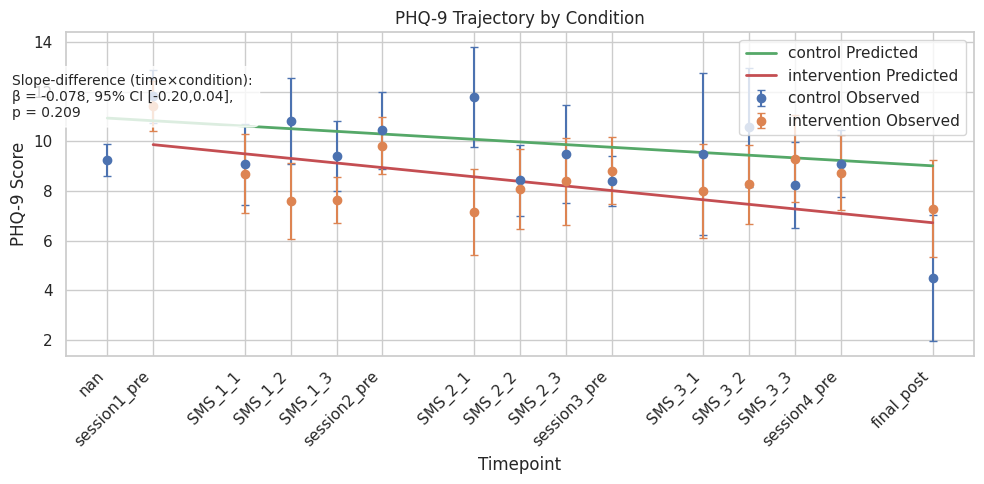

In [51]:
import warnings
warnings.filterwarnings("ignore")  # silence all warnings

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from pathlib import Path
from scipy import stats
from scipy.stats import norm
from numpy.linalg import LinAlgError
from IPython.display import display

# ─── 0) SETTINGS, PATHS & UTILITY FUNCTIONS ─────────────────────────────────
DATA_DIR = Path('/content')

def find_csv(substring: str) -> Path:
    matches = list(DATA_DIR.glob(f'*{substring}*.csv'))
    if not matches:
        raise FileNotFoundError(f"No file matching '{substring}' in {DATA_DIR}")
    if len(matches) > 1:
        raise ValueError(f"Multiple files match '{substring}': {matches}")
    return matches[0]

# Define key files
POST13 = find_csv('post_sessions_1-3')
POST4  = find_csv('post_session_4')

data_files = {
    'pre1':     'pre_session_1',
    'pre2to4':  'pre_sessions_2-4',
    'post1to3': 'post_sessions_1-3',
    'post4':    'post_session_4',
    'sms':      'sms_day1,3,5',
    'sms_post': 'sms_post',
    'signup':   'sign_up',
    'retention':'retention',
    'demo':     'demographics',
    'assign':   'wp2_assignments'
}

# Load all dataframes
dfs = {}
for key, name in data_files.items():
    try:
        dfs[key] = pd.read_csv(find_csv(name), dtype=str)
    except Exception:
        dfs[key] = None

(df_s1_pre, df_s2to4_pre, df_s2to4_post, df_s4_post,
 df_sms, df_final, df_signup, df_retention,
 df_demo, df_assign) = (
    dfs['pre1'], dfs['pre2to4'], dfs['post1to3'], dfs['post4'],
    dfs['sms'], dfs['sms_post'], dfs['signup'], dfs['retention'],
    dfs['demo'], dfs['assign']
)

# ─── 1) RETENTION & DEMOGRAPHIC SUMMARIES ───────────────────────────────────
if df_retention is not None:
    df_retention['attended'] = df_retention['attended'].astype(int)
    retention = df_retention.groupby('session_n')['attended'].mean().reset_index()
    print("Retention rates by session:")
    display(retention)

if df_demo is not None:
    df_demo['age'] = pd.to_numeric(df_demo['age'], errors='coerce')
    print("Demographics summary:")
    display(df_demo[['age','gender']].describe(include='all'))

# ─── 2) CLEAN WELLBEING & SMS DATA ───────────────────────────────────────────
def sum_scale(df, cols, out):
    df[out] = df[cols].apply(pd.to_numeric, errors='coerce').sum(axis=1)

def get_scale_cols(df, prefix, n, allow_suffix=False):
    cols = []
    for i in range(1, n+1):
        m, a = f"{prefix}_{i}", f"{prefix}_{i}_1"
        if m in df.columns:
            cols.append(m)
        elif allow_suffix and a in df.columns:
            cols.append(a)
    return cols

if df_sms is not None:
    df_sms['part_id'] = df_sms['part_id'].str.strip().str[:5]

all_wb = [df for df in (
    df_s1_pre, df_s2to4_pre, df_s2to4_post,
    df_s4_post, df_sms, df_final
) if df is not None]
if not all_wb:
    raise RuntimeError("No wellbeing/SMS data loaded!")

for df in all_wb:
    df.columns = df.columns.str.strip()
    # BDI numeric
    for c in df.columns:
        if re.fullmatch(r"bdi_\d+(?:_1)?", c):
            df[c] = pd.to_numeric(df[c].astype(str).str.extract(r"^(\d+)")[0], errors='coerce')
    # Sum scales
    for prefix, count, allow, out in [
        ('bai', 21, False, 'bai_sum'),
        ('bdi', 21, False, 'bdi_sum'),
        ('madrs',9,  True,  'MADRS_S_sum')
    ]:
        cols = get_scale_cols(df, prefix, count, allow_suffix=allow)
        if cols:
            sum_scale(df, cols, out)
    # m3vas standardization
    for var in ('mood','pleasure','suicidal'):
        raw = next((c for c in df.columns if re.fullmatch(f"m3vas_{var}(?:_1)?", c)), None)
        ch  = next((c for c in df.columns if re.fullmatch(f"m3vas_ch_{var}(?:_1)?", c)), None)
        tgt = raw or ch
        if tgt:
            vals = pd.to_numeric(df[tgt], errors='coerce')
            if var == 'suicidal':
                df['m3vas_suicidal'] = vals - 50
            else:
                df[f"m3vas_{var}"] = (50 - vals) if raw else (vals - 50)
    df.drop(columns=[c for c in df.columns
                     if re.fullmatch(r"m3vas_(?:ch_)?(?:mood|pleasure|suicidal)(?:_1)?", c)],
            errors='ignore', inplace=True)
    # Clean FISBER
    for c in ('fisber_1','fisber_2','fisber_3'):
        if c in df.columns:
            df[c] = pd.to_numeric(df[c].astype(str).str.extract(r"(\d+)$")[0], errors='coerce')
    # Ensure sums numeric
    for c in ['phq9_sum','spane_p','spane_n','bai_sum','bdi_sum','MADRS_S_sum']:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors='coerce')

# ─── 3) TAG, CONCATENATE, MERGE, ORDER, MODEL DF ─────────────────────────────
if df_s1_pre is not None:
    df_s1_pre['timepoint'] = 'session1_pre'
if df_s2to4_pre is not None:
    df_s2to4_pre['timepoint'] = df_s2to4_pre.apply(lambda r: f"session{r.session_n}_pre", axis=1)
if df_s2to4_post is not None:
    df_s2to4_post['timepoint'] = df_s2to4_post.apply(lambda r: f"session{r.session_n}_post", axis=1)
if df_s4_post is not None:
    df_s4_post['timepoint'] = 'session4_post'
if df_sms is not None:
    df_sms['timepoint'] = df_sms.apply(lambda r: f"SMS_{r.session_n}_{r.sms_n}", axis=1)
if df_final is not None:
    df_final['timepoint'] = 'final_post'

df_long = pd.concat([df for df in (
    df_s1_pre, df_s2to4_pre, df_s2to4_post,
    df_s4_post, df_sms, df_final
) if df is not None], ignore_index=True)

df_long = df_long[df_long['part_id'].str.match(r'^\d+$', na=False)]
df_long = df_long.merge(df_assign[['part_id','condition']], on='part_id', how='left')

ordered = [
    'session1_pre','session1_post',
    'SMS_1_1','SMS_1_2','SMS_1_3',
    'session2_pre','session2_post',
    'SMS_2_1','SMS_2_2','SMS_2_3',
    'session3_pre','session3_post',
    'SMS_3_1','SMS_3_2','SMS_3_3',
    'session4_pre','session4_post',
    'final_post'
]
df_long['timepoint'] = pd.Categorical(df_long['timepoint'], categories=ordered, ordered=True)
df_long['time_num'] = df_long['timepoint'].cat.codes

mask_session_post = df_long['timepoint'].astype(str).str.match(r'^session\d+_post$')
df_model = df_long[~mask_session_post].copy()
df_model['tc'] = df_model['time_num'] - df_model['time_num'].mean()
df_model = df_model.dropna(subset=['phq9_sum','tc','condition']).reset_index(drop=True)

# ─── 4) COMPOSITE SCORING ───────────────────────────────────────────────────
VHQ_DEFS = {
    "Geometric": ['6d_vhq_1','6d_vhq_2','6d_vhq_3'],
    "Semantic":  ['6d_vhq_4','6d_vhq_5','6d_vhq_6'],
    "Detail":    ['6d_vhq_7','6d_vhq_8','6d_vhq_9'],
    "Vividness": ['6d_vhq_10','6d_vhq_11','6d_vhq_12'],
    "Entropy":   ['6d_vhq_13','6d_vhq_14','6d_vhq_15'],
    "Focality":  ['6d_vhq_16','6d_vhq_17','6d_vhq_18']
}
EXP4_DEFS = [
    'exp4_engagement_1','exp4_pleasure_1',
    'exp4_discomfort_1','exp4_arousal_1'
]
asc_defs = {
    "Experience_of_Unity":            ['asc_18_4','asc_34_4','asc_41_4','asc_42_4','asc_52_4'],
    "Spiritual_Experience":           ['asc_9_4','asc_81_4','asc_94_4'],
    "Blissful_State":                 ['asc_12_4','asc_86_4','asc_91_4'],
    "Insightfulness":                 ['asc_50_4','asc_69_4','asc_77_4'],
    "Disembodiment":                  ['asc_26_4','asc_62_4','asc_63_4'],
    "Impaired_Control_and_Cognition": ['asc_8_4','asc_27_4','asc_38_4','asc_47_4','asc_64_4','asc_67_4','asc_78_4'],
    "Anxiety":                        ['asc_32_4','asc_43_4','asc_44_4','asc_46_4','asc_56_4','asc_89_4'],
    "Complex_Imagery":                ['asc_39_4','asc_72_4','asc_82_4'],
    "Elementary_Imagery":             ['asc_14_4','asc_22_4','asc_33_4'],
    "Audio_Visual_Synesthesia":       ['asc_20_4','asc_23_4','asc_75_4'],
    "Changed_Meaning_of_Percepts":    ['asc_28_4','asc_31_4','asc_54_4']
}

def extract_num(x):
    m = re.search(r'(\d+)$', str(x).strip())
    return float(m.group(1)) if m else np.nan

df_it1 = pd.read_csv(POST13, header=0).iloc[1:].copy()
df_it2 = pd.read_csv(POST4,  header=0).iloc[1:].copy()
df_it2['session_n'] = 4
df_items = pd.concat([df_it1, df_it2], ignore_index=True)
df_items['part_id'] = df_items['part_id'].astype(str)

for col in sum(VHQ_DEFS.values(), []) + sum(asc_defs.values(), []) + EXP4_DEFS:
    if col in df_items.columns:
        df_items[col] = df_items[col].apply(extract_num)

for col in VHQ_DEFS['Vividness']:
    if col in df_items.columns:
        df_items[col] = 6 - df_items[col]

records = []
for (pid, sess), grp in df_items.groupby(['part_id','session_n']):
    rec = {'part_id': pid}
    for nm, cols in VHQ_DEFS.items():
        pres = [c for c in cols if c in grp.columns]
        rec[f'VHQ_{nm}'] = grp[pres].mean(axis=1).mean() if pres else np.nan
    for nm, cols in asc_defs.items():
        pres = [c for c in cols if c in grp.columns]
        rec[f'ASC_{nm}'] = grp[pres].mean(axis=1).mean() if pres else np.nan
    for col in EXP4_DEFS:
        if col in grp.columns:
            nm = col.replace('exp4_','').replace('_1','').capitalize()
            rec[f'EXP4_{nm}'] = grp[col].mean()
    records.append(rec)

df_scores = pd.DataFrame(records)
df_partmods = df_scores.groupby('part_id').mean(numeric_only=True).reset_index()
df_partmods['VHQ_score']   = df_partmods.filter(like='VHQ_').mean(axis=1)
df_partmods['ASC_score']   = df_partmods.filter(like='ASC_').mean(axis=1)
df_partmods['EXP4_score']  = df_partmods.filter(like='EXP4_').mean(axis=1)

# ─── 5 & 6) TWO‑WAY & THREE‑WAY MODERATION ──────────────────────────────────
two_way, three_way = [], []
moderators = [c for c in df_partmods.columns if c != 'part_id']
for m in moderators:
    if m not in df_model.columns and m not in df_partmods.columns:
        continue
    sub = df_model.merge(df_partmods[['part_id', m]], on='part_id', how='left')
    if m not in sub.columns:
        continue
    sub = sub.dropna(subset=[m])
    if sub.empty:
        continue
    sub[f'{m}_c'] = sub[m] - sub[m].mean()

    try:
        res = smf.mixedlm(f"phq9_sum ~ tc*condition*{m}_c",
                          sub, groups='part_id', re_formula='~1').fit()
    except (LinAlgError, ValueError):
        continue

    two_way.append((
        m,
        round(res.params.get(f'tc:{m}_c', np.nan), 4),
        round(res.pvalues.get(f'tc:{m}_c', np.nan), 4)
    ))
    three_way.append((
        m,
        round(res.params.get(f'tc:condition[T.intervention]:{m}_c', np.nan), 4),
        round(res.pvalues.get(f'tc:condition[T.intervention]:{m}_c', np.nan), 4)
    ))

df_tw = pd.DataFrame(two_way, columns=['Moderator','Coef','p-value'])
df_th = pd.DataFrame(three_way, columns=['Moderator','3way_Coef','3way_p']).sort_values('3way_p')
print("Two‑way moderators (p<.05):"); display(df_tw[df_tw['p-value']<0.05])
print("Three‑way moderators (p<.05):"); display(df_th[df_th['3way_p']<0.05])

# ─── 7) IMAGERY ↔ ASC LINKAGE ───────────────────────────────────────────────
assign = pd.read_csv(find_csv('wp2_assignments'), dtype=str)[['part_id','condition']]
df_pm = df_partmods.merge(assign, on='part_id')
df_pm['VHQ_c'] = df_pm['VHQ_score'] - df_pm['VHQ_score'].mean()
df_pm['ASC_c'] = df_pm['ASC_score'] - df_pm['ASC_score'].mean()
r, p_r = stats.pearsonr(df_pm['VHQ_score'], df_pm['ASC_score'])
m1 = smf.ols("ASC_c ~ VHQ_c*condition", data=df_pm).fit()
print(f"Imagery ↔ ASC: r={r:.2f}, p={p_r:.3f}")
display(m1.summary())

# ─── 8) MEDIATION TEST (Sobel) ──────────────────────────────────────────────
sl = []
for pid, grp in df_model.groupby('part_id'):
    if grp['time_num'].nunique() < 2: continue
    ols = sm.OLS(grp['phq9_sum'], sm.add_constant(grp['time_num'])).fit()
    sl.append((pid, ols.params['time_num']))
df_sl = pd.DataFrame(sl, columns=['part_id','phq_slope'])
df_med = df_sl.merge(df_partmods[['part_id','ASC_score']], on='part_id').merge(assign, on='part_id')
df_med['cond_num'] = (df_med['condition']=='intervention').astype(int)
Ma = sm.OLS(df_med['ASC_score'], sm.add_constant(df_med['cond_num'])).fit()
Mb = sm.OLS(df_med['phq_slope'], sm.add_constant(df_med[['ASC_score','cond_num']])).fit()
a, sa = Ma.params['cond_num'], Ma.bse['cond_num']
b, sb = Mb.params['ASC_score'], Mb.bse['ASC_score']
ind = a*b
se_ind = np.sqrt(a*a*sb*sb + b*b*sa*sa)
z_val = ind / se_ind
p_sobel = 2*(1 - norm.cdf(abs(z_val)))
print(f"Mediation (Sobel): z={z_val:.2f}, p={p_sobel:.3f}")

# ─── 9) GROWTH MODEL & PLOTS ────────────────────────────────────────────────
final_model = smf.mixedlm("phq9_sum ~ tc*condition", df_model,
                          groups='part_id', re_formula='~1').fit()

coef_int = final_model.params['tc:condition[T.intervention]']
se_int   = final_model.bse['tc:condition[T.intervention]']
z_int    = coef_int / se_int
p_int    = 2 * (1 - norm.cdf(abs(z_int)))

print("Growth model fixed effects:")
print(final_model.summary().tables[1])
print(f"Interaction test: β_diff={coef_int:.4f}, SE={se_int:.4f}, z={z_int:.4f}, p={p_int:.4f}")

obs = df_model.groupby(['condition','time_num']).phq9_sum.agg(['mean','sem']).reset_index()
pred_df = (df_model.assign(predicted=final_model.predict(df_model))
           .groupby(['condition','time_num'])['predicted'].mean().reset_index())

time_vals = sorted(df_model['time_num'].unique())
label_map = df_model[['time_num','timepoint']].drop_duplicates().set_index('time_num')['timepoint'].to_dict()

plt.figure(figsize=(10,5))
for cond, grp in obs.groupby('condition'):
    plt.errorbar(grp['time_num'], grp['mean'], yerr=grp['sem'],
                 fmt='o', capsize=3, label=f"{cond} Observed")
for cond in pred_df['condition'].unique():
    sub = pred_df[pred_df['condition']==cond]
    plt.plot(sub['time_num'], sub['predicted'], '-', lw=2,
             label=f"{cond} Predicted")

txt = (
    f"Slope‐difference (time×condition):\n"
    f"β = {coef_int:.3f}, 95% CI [{coef_int-1.96*se_int:.2f},{coef_int+1.96*se_int:.2f}],\n"
    f"p = {p_int:.3f}"
)
plt.gcf().text(0.02, 0.75, txt, fontsize=10,
               bbox=dict(boxstyle="round,pad=0.5", facecolor="white", alpha=0.8))

plt.xticks(time_vals, [label_map[t] for t in time_vals], rotation=45, ha='right')
plt.xlabel("Timepoint")
plt.ylabel("PHQ-9 Score")
plt.title("PHQ-9 Trajectory by Condition")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

In [52]:
# full_analysis.py
# ---------------------------------------------------
# End-to-end pipeline: scale sums, composites, ANOVAs,
# mixed models with moderators (expectations, VHQ, ASC, EXP4), and plots
# ---------------------------------------------------

import warnings
warnings.filterwarnings("ignore")

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy.stats import norm, ttest_rel
from numpy.linalg import LinAlgError
from pathlib import Path

# ─── 0) SETTINGS & UTILITIES ─────────────────────────────────────────────
DATA_DIR = Path('/content')  # adjust as needed

def find_csv(substring: str) -> Path:
    matches = list(DATA_DIR.glob(f'*{substring}*.csv'))
    matches = [m for m in matches if not m.name.endswith('_scales.csv')]
    if not matches:
        raise FileNotFoundError(f"No file matching '{substring}' in {DATA_DIR}")
    if len(matches) > 1:
        raise ValueError(f"Multiple files match '{substring}': {matches}")
    return matches[0]

def try_load(substring: str) -> pd.DataFrame | None:
    try:
        df = pd.read_csv(find_csv(substring), dtype=str)
    except Exception:
        return None
    df.columns = df.columns.str.strip().str.lower()
    if 'part_id' not in df.columns:
        for alt in ('participantid','prolificid','externalreference','responseid'):
            if alt in df.columns:
                df = df.rename(columns={alt:'part_id'})
                break
    df['part_id'] = df['part_id'].astype(str).str.strip()
    return df

# ─── 1) LOAD DATA ─────────────────────────────────────────────────────────
df_pre1   = try_load('pre_session_1')       # has expectations
df_post4  = try_load('post_session_4')      # no expectations
df_sms    = try_load('sms_day1,3,5')        # only PHQ-9
df_it13   = try_load('post_sessions_1-3')   # VHQ/ASC/EXP4 S1-3
df_it4    = try_load('post_session_4')      # VHQ/ASC/EXP4 S4
df_assign = try_load('wp2_assignments')     # participant condition
df_sms_post = try_load('sms_post')          # final check-in

# ─── 2) SCORING HELPERS ───────────────────────────────────────────────────
def get_scale_cols(df, prefix, n, allow_suffix=False):
    cols = []
    for i in range(1, n+1):
        a, b = f"{prefix}_{i}", f"{prefix}_{i}_1"
        if a in df.columns:
            cols.append(a)
        elif allow_suffix and b in df.columns:
            cols.append(b)
    return cols

def sum_scale(df, prefix, n, allow_suffix=False):
    cols = get_scale_cols(df, prefix, n, allow_suffix)
    vals = df[cols].apply(pd.to_numeric, errors='coerce')
    df[f"{prefix}_sum"]  = vals.sum(axis=1)
    df[f"{prefix}_mean"] = vals.mean(axis=1)

phq_map = {'Not at all':0,'Several days':1,'More than half the days':2,'Nearly every day':4}
def map_phq9(df):
    cols = [c for c in df.columns if re.match(r'^phq9_\d+', c)]
    for c in cols:
        df[c] = df[c].map(phq_map).astype(float)
    df['phq9_sum']  = df[cols].sum(axis=1)
    df['phq9_mean'] = df[cols].mean(axis=1)

# ─── 3) APPLY SCORING ─────────────────────────────────────────────────────
for df in (df_pre1, df_post4, df_sms):
    if df is None: continue
    for prefix, count, allow in [('bdi',21,True),('bai',21,False),('madrs',9,True)]:
        cols = get_scale_cols(df, prefix, count, allow)
        df[cols] = df[cols].astype(str).apply(lambda col: col.str.extract(r'^(\d+)')[0].astype(float))
        sum_scale(df, prefix, count, allow_suffix=allow)
    map_phq9(df)
    if df is df_pre1:
        exp_cols = [f'treat_expct_{i}' for i in range(1,16) if f'treat_expct_{i}' in df]
        for i in range(7,12):
            c = f'treat_expct_{i}'
            if c in df:
                df[c] = 10 - pd.to_numeric(df[c], errors='coerce')
        vals = df[exp_cols].apply(pd.to_numeric, errors='coerce')
        df['expect_sum']  = vals.sum(axis=1)
        df['expect_mean'] = vals.mean(axis=1)

# ─── 4) PAIRED T‑TESTS PRE1→POST4 ──────────────────────────────────────
if df_pre1 is not None and df_post4 is not None:
    pre  = df_pre1[['part_id','bdi_sum','bai_sum','madrs_sum']].dropna()
    post = df_post4[['part_id','bdi_sum','bai_sum','madrs_sum']].dropna()
    paired = pre.merge(post, on='part_id', suffixes=('_pre','_post'))
    for scale in ['bdi','bai','madrs']:
        t, p = ttest_rel(paired[f'{scale}_sum_pre'], paired[f'{scale}_sum_post'], nan_policy='omit')
        print(f"{scale.upper()}_sum pre→post: t={t:.2f}, p={p:.3f}")

# ─── PHQ‑9 PAIRED T‑TEST & ANOVA BY CONDITION ─────────────────────────────
if df_pre1 is not None and df_sms_post is not None and df_assign is not None:
    # pull & rename
    pre  = (df_pre1[['part_id','phq9_sum']]
            .rename(columns={'phq9_sum':'phq9_sum_pre'}))
    post = (df_sms_post[['part_id','phq9_sum']]
            .rename(columns={'phq9_sum':'phq9_sum_post'}))

    # ensure numeric
    pre['phq9_sum_pre']   = pd.to_numeric(pre['phq9_sum_pre'], errors='coerce')
    post['phq9_sum_post'] = pd.to_numeric(post['phq9_sum_post'], errors='coerce')

    # merge and drop any rows still missing
    paired = (pre.merge(post, on='part_id')
                 .dropna(subset=['phq9_sum_pre','phq9_sum_post']))

    # paired t‑test
    t, p = ttest_rel(paired['phq9_sum_pre'],
                     paired['phq9_sum_post'],
                     nan_policy='omit')
    print(f"PHQ9_sum pre→post: t={t:.2f}, p={p:.3f}\n")

    # one‑way ANOVA on the POST score
    merged = paired.merge(df_assign[['part_id','condition']], on='part_id')
    model = smf.ols('phq9_sum_post ~ condition', merged).fit()
    print("ANOVA PHQ‑9 by condition:")
    print(sm.stats.anova_lm(model, typ=2))


# ─── 5) ANOVAS PRE1→POST4 BY CONDITION ────────────────────────────────
if df_pre1 is not None and df_post4 is not None and df_assign is not None:
    merged = (
        df_pre1[['part_id','bdi_sum','bai_sum','madrs_sum']]
        .merge(df_post4[['part_id','bdi_sum','bai_sum','madrs_sum']], on='part_id', suffixes=('_pre','_post'))
        .merge(df_assign[['part_id','condition']], on='part_id')
    )
    for scale in ['bdi','bai','madrs']:
        model = smf.ols(f"{scale}_sum_post ~ condition", merged).fit()
        print(f"ANOVA {scale.upper()} by condition:")
        print(sm.stats.anova_lm(model, typ=2), "\n")

# ─── 6) VHQ/ASC/EXP4 COMPOSITES ────────────────────────────────────────
if df_it13 is not None and df_it4 is not None:
    it1 = df_it13.iloc[1:].copy()
    it2 = df_it4.iloc[1:].copy(); it2['session_n'] = 4
    items = pd.concat([it1, it2], ignore_index=True)
    items.columns = items.columns.str.strip().str.lower()
    items['part_id'] = items['part_id'].astype(str)
    for c in items.columns:
        if re.match(r'6d_vhq_\d+|asc_\d+_4|exp4_\w+_1', c):
            items[c] = items[c].astype(str).str.extract(r'(\d+)')[0].astype(float)
    for i in (10,11,12):
        col = f'6d_vhq_{i}'
        if col in items:
            items[col] = 6 - items[col]
    VHQ = {'Geometric':[1,2,3],'Semantic':[4,5,6],'Detail':[7,8,9],
           'Vividness':[10,11,12],'Entropy':[13,14,15],'Focality':[16,17,18]}
    ASC = {
        'Experience_of_Unity':[18,34,41,42,52],
        'Spiritual_Experience':[9,81,94],
        'Blissful_State':[12,86,91],
        'Insightfulness':[50,69,77],
        'Disembodiment':[26,62,63],
        'Impaired_Control_and_Cognition':[8,27,38,47,64,67,78],
        'Complex_Imagery':[39,72,82]
    }
    EXP4 = ['engagement','pleasure','discomfort','arousal']
    recs = []
    for pid, grp in items.groupby('part_id'):
        r = {'part_id':pid}
        for nm, idxs in VHQ.items():
            cols = [f'6d_vhq_{i}' for i in idxs if f'6d_vhq_{i}' in grp]
            r[f'VHQ_{nm}'] = grp[cols].mean(axis=1).mean() if cols else np.nan
        for nm, idxs in ASC.items():
            cols = [f'asc_{i}_4' for i in idxs if f'asc_{i}_4' in grp]
            r[f'ASC_{nm}'] = grp[cols].mean(axis=1).mean() if cols else np.nan
        for d in EXP4:
            col = f'exp4_{d}_1'
            r[f'EXP4_{d.capitalize()}'] = grp[col].mean() if col in grp else np.nan
        recs.append(r)
    df_scores = pd.DataFrame(recs)

# ─── 7) BUILD LONG, MERGE BASELINE EXPECTATIONS & FILTER FOR GROWTH ─────
frames = []
if df_pre1 is not None:
    df0 = df_pre1[['part_id','phq9_sum']].copy()
    df0['time'] = 0
    frames.append(df0)
if df_sms is not None:
    df1 = df_sms[['part_id','phq9_sum']].copy()
    df1['time'] = 1
    frames.append(df1)
if df_post4 is not None:
    df2 = df_post4[['part_id','phq9_sum']].copy()
    df2['time'] = 2
    frames.append(df2)

df_long = pd.concat(frames, ignore_index=True)

# add condition
if df_assign is not None:
    df_long = df_long.merge(df_assign[['part_id','condition']], on='part_id', how='left')

# add VHQ/ASC/EXP4 composites if available
if 'df_scores' in locals():
    df_long = df_long.merge(df_scores, on='part_id', how='left')

# bring in baseline expectations for every row
if df_pre1 is not None:
    baseline = df_pre1[['part_id','expect_sum']].copy()
    df_long = df_long.merge(baseline, on='part_id', how='left')

# center expectation
df_long['expect_sum_c'] = df_long['expect_sum'] - df_long['expect_sum'].mean()

# keep only participants with >1 PHQ-9 observation
valid = df_long.groupby('part_id')['phq9_sum'].apply(lambda x: x.notna().sum()>1)
df_model = df_long[df_long['part_id'].isin(valid[valid].index)].copy()

# ─── 8) MODERATION MODELS ───────────────────────────────────────────────
df_model['tc'] = df_model['time'] - df_model['time'].mean()
mods = [c for c in ['expect_sum'] +
        [col for col in df_model if col.startswith('VHQ_') or col.startswith('ASC_') or col.startswith('EXP4_')]
        if c in df_model]
# center all moderators
for m in mods:
    df_model[f'{m}_c'] = df_model[m] - df_model[m].mean()

print("\nModerator tests (time×condition×moderator):")
for m in mods:
    sub = df_model.dropna(subset=['phq9_sum','condition',f'{m}_c'])
    try:
        md = smf.mixedlm(f"phq9_sum ~ tc*condition*{m}_c",
                         sub,
                         groups=sub['part_id'].astype('category').cat.codes).fit()
        coef = md.params.get(f'tc:condition[T.intervention]:{m}_c', np.nan)
        pval = md.pvalues.get(f'tc:condition[T.intervention]:{m}_c', np.nan)
        print(f"* {m}: coef={coef:.4f}, p={pval:.4f}")
    except LinAlgError:
        print(f"* {m}: model failed (singular)")

# ─── 9) BASE GROWTH MODEL & PLOT ────────────────────────────────────────

BDI_sum pre→post: t=5.27, p=0.000
BAI_sum pre→post: t=3.78, p=0.001
MADRS_sum pre→post: t=-6.53, p=0.000
PHQ9_sum pre→post: t=3.30, p=0.008

ANOVA PHQ‑9 by condition:
               sum_sq   df         F    PR(>F)
condition   19.753247  1.0  0.745629  0.410285
Residual   238.428571  9.0       NaN       NaN
ANOVA BDI by condition:
                sum_sq    df         F    PR(>F)
condition    74.906667   1.0  0.567226  0.459004
Residual   3037.333333  23.0       NaN       NaN 

ANOVA BAI by condition:
                sum_sq    df         F    PR(>F)
condition    66.666667   1.0  0.519892  0.478154
Residual   2949.333333  23.0       NaN       NaN 

ANOVA MADRS by condition:
               sum_sq    df         F    PR(>F)
condition   36.506667   1.0  1.983433  0.172404
Residual   423.333333  23.0       NaN       NaN 


Moderator tests (time×condition×moderator):
* expect_sum: coef=-0.0094, p=0.8346
* VHQ_Geometric: coef=-0.6398, p=0.6443
* VHQ_Semantic: coef=-0.5295, p=0.6158
* VHQ_Detail:

In [ ]:
# process_sessions_scales.py
# ---------------------------------------------------
# Load and compute scale sums for pre- and post-session data
# Supports 'pre_session_1' (with expectations) and 'post_session_4' (no expectations)
# ---------------------------------------------------

import warnings
warnings.filterwarnings("ignore")

import re
import pandas as pd
from pathlib import Path

# 0) SETTINGS & UTILITIES
DATA_DIR = Path("/content")  # adjust as needed

# Utility to find CSV by substring
def find_csv(substring: str) -> Path:
    matches = list(DATA_DIR.glob(f'*{substring}*.csv'))
    if not matches:
        raise FileNotFoundError(f"No file matching '{substring}' in {DATA_DIR}")
    if len(matches) > 1:
        raise ValueError(f"Multiple files match '{substring}': {matches}")
    return matches[0]

# 1) SUM/MAP FUNCTIONS

def sum_scale(df, prefixes, n, out, allow_suffix=False):
    cols = []
    for p in prefixes:
        for i in range(1, n+1):
            a, b = f"{p}_{i}", f"{p}_{i}_1"
            if a in df.columns:
                cols.append(a)
            elif allow_suffix and b in df.columns:
                cols.append(b)
    cols = list(dict.fromkeys(cols))
    num = df[cols].apply(pd.to_numeric, errors='coerce')
    df[f"{out}_sum"]  = num.sum(axis=1)
    df[f"{out}_mean"] = num.mean(axis=1)
    print(f"Scaled {out}: sum/mean from {len(cols)} cols")
    return df

phq_map = {
    'Not at all': 0,
    'Several days': 1,
    'More than half the days': 2,
    'Nearly every day': 4
}

def map_phq9(df):
    cols = [c for c in df.columns if re.match(r'^phq9_\d+', c)]
    for c in cols:
        df[c + '_num'] = df[c].map(phq_map).astype(float)
    df['phq9_sum']  = df[[c + '_num' for c in cols]].sum(axis=1)
    df['phq9_mean'] = df[[c + '_num' for c in cols]].mean(axis=1)
    print(f"Mapped PHQ-9: {len(cols)} items → sum/mean")
    return df

# 2) PROCESS SESSION

def process_session(substring, has_expect=False):
    # load
    path = find_csv(substring)
    print(f"\nProcessing {substring}: {path}")
    raw = pd.read_csv(path, dtype=str)
    df = raw.iloc[2:].reset_index(drop=True)  # drop two metadata rows
    # clean names
    df.columns = (
        df.columns
          .str.strip()
          .str.lower()
          .str.replace(r'mards_', 'madrs_', regex=True)
    )
    # scales
    df = sum_scale(df, ['bdi'],   21, 'bdi',  allow_suffix=True)
    df = sum_scale(df, ['bai'],   21, 'bai',  allow_suffix=True)
    df = sum_scale(df, ['madrs','mards'], 9, 'madrs', allow_suffix=True)
    df = map_phq9(df)
    # expectations
    if has_expect:
        exp_cols = [f"treat_expct_{i}" for i in range(1, 16) if f"treat_expct_{i}" in df]
        for i in range(7, 12):
            col = f"treat_expct_{i}"
            if col in df:
                df[col] = 10 - pd.to_numeric(df[col], errors='coerce')
        num = df[exp_cols].apply(pd.to_numeric, errors='coerce')
        df['expect_sum']  = num.sum(axis=1)
        df['expect_mean'] = num.mean(axis=1)
        print(f"Summed expectations: {len(exp_cols)} items → sum/mean")
    # save
    out = DATA_DIR / f"{substring}_scales.csv"
    df.to_csv(out, index=False)
    print(f"Saved output to {out}")
    return df

# 3) RUN BOTH
if __name__ == '__main__':
    # pre-session-1 has expectations
    df_pre  = process_session('pre_session_1',   has_expect=True)
    # post-session-4 has no expectations
    df_post = process_session('post_session_4',  has_expect=False)


Processing pre_session_1: /content/wp2_pre_session_1_July 21, 2025_07.21.csv
Scaled bdi: sum/mean from 21 cols
Scaled bai: sum/mean from 21 cols
Scaled madrs: sum/mean from 9 cols
Mapped PHQ-9: 9 items → sum/mean
Summed expectations: 15 items → sum/mean
Saved output to /content/pre_session_1_scales.csv

Processing post_session_4: /content/wp2_post_session_4_July 21, 2025_07.20.csv
Scaled bdi: sum/mean from 21 cols
Scaled bai: sum/mean from 21 cols
Scaled madrs: sum/mean from 9 cols
Mapped PHQ-9: 9 items → sum/mean
Saved output to /content/post_session_4_scales.csv
